<h1>Experiment 1</h1>
<h3>Test the number of layers acquired to output promising NODDI measure for three networks</h3>

In [1]:
import nibabel as nib
import numpy as np

from FormatData import generate_data, parser as data_parser
from Training import train_network
from utils.model import parser as model_parser
from Testing import test_model
from utils.nii_utils import mask_nii_data

2022-04-09 16:09:29.517861: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_subject = 's01_still'
# test_subjects = ['s02_still', 's03_still_reg', 's04_still_reg']
test_subjects = ['s02_still']

In [3]:
class Namespace:
    """
    a class generate parser for cmd line args
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [4]:
"""
packages that handle graphs
"""
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from skimage.metrics import structural_similarity as compare_ssim
from utils import calc_ssim
%matplotlib inline
def plot_loss(cmd):
    """
    A function that used to plot the loss curve for the trained network.
    Args:
        cmd: String, the command line in the terminal
    """
    args = model_parser().parse_args(cmd.split())
    history = train_network(args)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def show_slices(slices, grayscale=True):
    """
    Function to display the slices

    Args:
        slices (list): a list of 2d ndarray that contains the data to be displayed
        grayscale (bool, optional): True, if diplay grayscale img. Defaults to True.
    """    
    fig, axes = plt.subplots(1, len(slices), figsize=(10,10))
    cax = fig.add_axes([0, 0, .3, .3])
    for i, slice in enumerate(slices):
        # use grayscale for displaying ref and pred imgs:
        if grayscale:
            cmap = plt.get_cmap('gray')
            cmaplist = [cmap(i) for i in range(cmap.N)]
            cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
            bounds = np.arange(0, 1.01, .01)
            idx = np.searchsorted(bounds, 0)
            bounds = np.insert(bounds, idx, 0)
            norm = BoundaryNorm(bounds, cmap.N)
            im = axes[i].imshow(slice.T, cmap=cmap, origin="lower", interpolation='none', norm=norm)
        else:
            # define the colormap
            cmap = plt.get_cmap('bwr')
            # extract all colors from the .jet map
            cmaplist = [cmap(i) for i in range(cmap.N)]
            # create the new map
            cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
            # define the bins and normalize and forcing 0 to be part of the colorbar
            # define the min and max to be -1 and +1 respectively
            bounds = np.arange(-0.11, 0.11, .01)
            idx = np.searchsorted(bounds, 0)
            bounds = np.insert(bounds, idx, 0)
            norm = BoundaryNorm(bounds, cmap.N)
            im = axes[i].imshow(slice.T, cmap=cmap, origin="lower", interpolation='none', norm=norm)
        fig.colorbar(im, cax=cax, orientation='vertical')

def scale(img):
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         img[i][j] = ((img[i][j]+1)/2)*255
    return img

def compare_simi(pred, ref):
    return calc_ssim(pred, ref)

In [5]:
def visualise0(ref):
    """
    Function to visualise the ref imgs

    Args:
        ref (ndarray): the reference data
    """
    # visualise the ref imgs
    ref0 = ref[26, :, :]
    ref1 = ref[:, 30, :]
    ref2 = ref[:, :, 16]
    show_slices([ref0, ref1, ref2])
    plt.suptitle("Center slices for reference image")


def visualise1(ref_ndi, retained_vol, subject, model, layer, affine):
    """
    Function to visualise the NDI imgs and store the difference map

    Args:
        ref_ndi (ndarray): the reference NDI data
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
        retained_vol (int): the number of volumes used
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refNDI0 = ref_ndi[26, :, :]
    refNDI1 = ref_ndi[:, 30, :]
    refNDI2 = ref_ndi[:, :, 16]

    # visualise the pred imgs produced at varied input size
    ndi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDIsynthetic.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle('Center slices for NDI predicted image by '+model+', input size='+str(retained_vol))
    (score, ndidiff) = compare_ssim(ndi_data, ref_ndi, full=True)
    print(str(retained_vol)+'input size the ssim score for ndi is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = scale(refNDI0 - ndi0)
    ndidiff1 = scale(refNDI1 - ndi1)
    ndidiff2 = scale(refNDI2 - ndi2)
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI")

    diff_img_np = ref_ndi - ndi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDI_difference_synthetic.nii')

def visualise2(ref_odi, retained_vol, subject, model, layer, affine):
    """
    Function to visualise the ODI imgs and difference maps

    Args:
        ref_odi (ndarray): the reference ODI data
        retained_vol (int): the number of volumes retained after rejection
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refODI0 = ref_odi[26, :, :]
    refODI1 = ref_odi[:, 30, :]
    refODI2 = ref_odi[:, :, 16]

    # visualise the pred imgs produced at varied input size
    odi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODIsynthetic.nii'
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle('Center slices for ODI predicted image by '+model+', input size='+str(retained_vol))
    (score, odidiff) = compare_ssim(odi_data, ref_odi, full=True)
    print(str(retained_vol)+'input size the ssim score for odi is: ' + str(score))

    odidiff0 = scale(refODI0 - odi0)
    odidiff1 = scale(refODI1 - odi1)
    odidiff2 = scale(refODI2 - odi2)
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI")

    diff_img_np = ref_odi - odi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODI_difference_synthetic.nii')

def visualise3(ref_fwf, retained_vol, subject, model, layer, affine):
    """
    Function to visualise the fwf imgs and difference maps

    Args:
        ref_fwf (ndarray): the reference FWF data
        retained_vol (int): the number of volumes retained after rejection
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refFWF0 = ref_fwf[26, :, :]
    refFWF1 = ref_fwf[:, 30, :]
    refFWF2 = ref_fwf[:, :, 16]

    # visualise the pred imgs produced at varied input size
    fwf_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWFsynthetic.nii'
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle('Center slices for FWF predicted image by '+model+', input size='+str(retained_vol))
    (score, fwfdiff) = compare_ssim(fwf_data, ref_fwf, full=True)
    print(str(retained_vol)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    fwfdiff0 = scale(refFWF0 - fwf0)
    fwfdiff1 = scale(refFWF1 - fwf1)
    fwfdiff2 = scale(refFWF2 - fwf2)
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF")

    diff_img_np = ref_fwf - fwf_data
    diff_img = nib.Nifti1Image(diff_img_np, affine)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWF_difference_synthetic.nii')

def visualise4(ref_ndi, ref_odi, ref_fwf, retained_vol, subject, model, layer, affine1, affine2, affine3):
    """
    Function to visualise the imgs and difference maps

    Args:
        ref_ndi (ndarray): the reference NDI data
        ref_odi (ndarray): the reference ODI data
        ref_fwf (ndarray): the reference FWF data
        retained_vol (int): the number of volumes retained after rejection
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refNDI0 = ref_ndi[26, :, :]
    refNDI1 = ref_ndi[:, 30, :]
    refNDI2 = ref_ndi[:, :, 16]

    refODI0 = ref_odi[26, :, :]
    refODI1 = ref_odi[:, 30, :]
    refODI2 = ref_odi[:, :, 16]

    refFWF0 = ref_fwf[26, :, :]
    refFWF1 = ref_fwf[:, 30, :]
    refFWF2 = ref_fwf[:, :, 16]

    # visualise the pred imgs produced at varied input size
    ndi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDIsynthetic.nii'
    odi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODIsynthetic.nii'
    fwf_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWFsynthetic.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle('Center slices for NDI predicted image by '+model+', input size='+str(retained_vol))
    (score, ndidiff) = compare_ssim(ndi_data, ref_ndi, full=True)
    print(str(retained_vol)+'input size the ssim score for ndi is: ' + str(score))

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle('Center slices for ODI predicted image by '+model+', input size='+str(retained_vol))
    (score, odidiff) = compare_ssim(odi_data, ref_odi, full=True)
    print(str(retained_vol)+'input size the ssim score for odi is: ' + str(score))

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle('Center slices for FWF predicted image by '+model+', input size='+str(retained_vol))
    (score, fwfdiff) = compare_ssim(fwf_data, ref_fwf, full=True)
    print(str(retained_vol)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = scale(refNDI0 - ndi0)
    ndidiff1 = scale(refNDI1 - ndi1)
    ndidiff2 = scale(refNDI2 - ndi2)
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI")

    diff_img_np = ref_ndi - ndi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine1)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDI_difference_synthetic.nii')

    odidiff0 = scale(refODI0 - odi0)
    odidiff1 = scale(refODI1 - odi1)
    odidiff2 = scale(refODI2 - odi2)
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI")

    diff_img_np = ref_odi - odi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine2)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODI_difference_synthetic.nii')

    fwfdiff0 = scale(refFWF0 - fwf0)
    fwfdiff1 = scale(refFWF1 - fwf1)
    fwfdiff2 = scale(refFWF2 - fwf2)
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF")

    diff_img_np = ref_fwf - fwf_data
    diff_img = nib.Nifti1Image(diff_img_np, affine3)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWF_difference_synthetic.nii')

___
<h3>Data Preprocessing</h3>

In [6]:
# motion-free subject path
s01_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/'
s02_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/'
s03_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/'
s04_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/'
# motion-free target labels
s01_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_NDI.nii'
s02_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_NDI.nii'
s03_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_NDI.nii'
s04_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_NDI.nii'

s01_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_ODI.nii'
s02_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_ODI.nii'
s03_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_ODI.nii'
s04_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_ODI.nii'

s01_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_FWF.nii'
s02_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_FWF.nii'
s03_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_FWF.nii'
s04_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_FWF.nii'

In [7]:
def filter_mask(subpath, fwfpath, threshold=0.99):
    """
    By looking at the imgs generated, we have found out there are some regions that should not be included. Since they have values higher than 1.0
    And we have found out voxels have NDI and ODI values, while that voxel has GROUND TRUTH FWF 1.0
    This should indicate that that voxel should not even be included in the training
    Therefore we want to filter the each subject's mask first, by using their corresponding GROUND TRUTH FWF

    Args:
        subpath (string): the path of the subject folder
        fwfpath (string): the path of the corresponding fwf file
        threshold (float): the thresholds to be used to filter of the mask,
                           a stringnent threshold would be 0.9, the least stringnent threshold is 1.0
                           by default, it is set to 0.99
    """
    # fetch the mask data
    img_mask = nib.load(subpath+'mask-e.nii')
    original_mask = img_mask.get_fdata()
    original_affine = img_mask.affine
    shape = original_mask.shape # retain the shape of the mask
    origin_nonzeros = np.count_nonzero(original_mask)
    print('original mask has: ' + str(origin_nonzeros) + ' of nonzero voxels')
    # fetch the FWF data
    fwf = nib.load(fwfpath).get_fdata()
    # filter
    mask = original_mask.flatten() # this makes a copy of the orginal mask
    fwf = fwf.reshape(mask.shape[0]) # reshape fwf to the corresponding shape
    for i in range(len(mask)):
        # if fwf has high value, means there is no tissue
        # therefore, the voxel should be excluded
        if fwf[i] >= threshold:
            mask[i] = 0.0
    # reshape mask back
    mask = mask.reshape(shape)
    filter_nonzeros = np.count_nonzero(mask)
    print('filtered mask has: ' +str(filter_nonzeros) + ' of nonzero voxels')
    # save the mask
    filter_img = nib.Nifti1Image(mask, original_affine)
    nib.save(filter_img, subpath+'filtered_mask.nii')

In [8]:
# Use the above code to filter each subject's mask. Store as filtered_mask.nii in each subject folder
filter_mask(s01_path, s01_FWF_path)
filter_mask(s02_path, s02_FWF_path)
filter_mask(s03_path, s04_FWF_path)
filter_mask(s04_path, s03_FWF_path)

original mask has: 82889 of nonzero voxels
filtered mask has: 81882 of nonzero voxels
original mask has: 94198 of nonzero voxels
filtered mask has: 91401 of nonzero voxels
original mask has: 91131 of nonzero voxels
filtered mask has: 89491 of nonzero voxels
original mask has: 88241 of nonzero voxels
filtered mask has: 87347 of nonzero voxels


In [9]:
# filtered mask path for each subject
s01_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/filtered_mask.nii'
s02_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/filtered_mask.nii'
s03_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/filtered_mask.nii'
s04_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/filtered_mask.nii'

In [10]:
# A simple test to verify the algorithm mask_nii_data from utils.nii_utils correctly generates the 1x1 patch from (a) given volume(s) DWI
s02_mask_data = nib.load(s02_mask_path).get_fdata()
print(s02_mask_data.shape)
# generate a random mask
random_mask = np.zeros((s02_mask_data.shape[0],s02_mask_data.shape[1], s02_mask_data.shape[2]))
print(random_mask.shape)
# select some pixels' values in the random_mask turn into 1
# randomly select 4 paris of x, y value
for i in range(4):
    rand_x = np.random.randint(low=0, high=s02_mask_data.shape[0])
    rand_y = np.random.randint(low=0, high=s02_mask_data.shape[1])
    rand_z = np.random.randint(low=0, high=s02_mask_data.shape[2])
    # set the corresponding pixel to have value 1
    random_mask[rand_x][rand_y][rand_z] = 1
# by this, we know the ground truth for this test. The number of 1s in the mask = the number of 1x1 pacth generated from the algorithm
# we apply the random mask onto the s02_mask
data = mask_nii_data(data=s02_mask_data, mask=random_mask)

(84, 84, 50)
(84, 84, 50)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (4, 1) the ratio of masked voxel is: 1.1337868480725624e-05


<strong>Interpret the result from the algorithm test.</strong>
The s02_mask has only one volume of shape (84,84,50). The random mask has a shape (84,84,50).</br>
We randomly turned 4 pixels in the random mask to 1. Then apply the random mask to the s02_mask.</br>
<strong>What we expect to see, there should be 4 patches generated for each volume of s02_mask.</strong></br>
Results show that the data afer masking (by the random mask) has a shape (4,1). Where 4 represents the number of 1x1 patches and 1 represent the volume of s02_mask.</br>
Therefore, it suggests the algorithm works fine.

In [11]:
"""
Generate base datasets for each subject
"""
ltype = ['N','O','F','A']
for l in ltype:
    print('Generating basedataset for label: ' + l)
    cmd = '--base --label_type ' + l + ' --subjects s01_still s02_still'
    args = data_parser().parse_args(cmd.split())
    generate_data(args)

Generating basedataset for label: N
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating for s02_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating basedataset for label: O
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating for s02_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating basedataset for label: F
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating for s02_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating basedataset for label: A
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 3)
Generatin

In [11]:
"""
Using nib to fetch the ground truth img
"""
#load the truth data for subject 1
s01_NDI_img = nib.load(s01_NDI_path)
s01_ODI_img = nib.load(s01_ODI_path)
s01_FWF_img = nib.load(s01_FWF_path)
s01_NDI_affine = s01_NDI_img.affine
s01_ODI_affine = s01_ODI_img.affine
s01_FWF_affine = s01_FWF_img.affine
s01_NDI_img_data = s01_NDI_img.get_fdata()
s01_ODI_img_data = s01_ODI_img.get_fdata()
s01_FWF_img_data = s01_FWF_img.get_fdata()
#load the truth data for subject 2
s02_NDI_img = nib.load(s02_NDI_path)
s02_ODI_img = nib.load(s02_ODI_path)
s02_FWF_img = nib.load(s02_FWF_path)
s02_NDI_affine = s02_NDI_img.affine
s02_ODI_affine = s02_ODI_img.affine
s02_FWF_affine = s02_FWF_img.affine
s02_NDI_img_data = s02_NDI_img.get_fdata()
s02_ODI_img_data = s02_ODI_img.get_fdata()
s02_FWF_img_data = s02_FWF_img.get_fdata()
# load the truth data for subject 3
s03_NDI_img = nib.load(s03_NDI_path)
s03_ODI_img = nib.load(s03_ODI_path)
s03_FWF_img = nib.load(s03_FWF_path)
s03_NDI_affine = s03_NDI_img.affine
s03_ODI_affine = s03_ODI_img.affine
s03_FWF_affine = s03_FWF_img.affine
s03_NDI_img_data = s03_NDI_img.get_fdata()
s03_ODI_img_data = s03_ODI_img.get_fdata()
s03_FWF_img_data = s03_FWF_img.get_fdata()
# load the truth data for subject 4
s04_NDI_img = nib.load(s04_NDI_path)
s04_ODI_img = nib.load(s04_ODI_path)
s04_FWF_img = nib.load(s04_FWF_path)
s04_NDI_affine = s04_NDI_img.affine
s04_ODI_affine = s04_ODI_img.affine
s04_FWF_affine = s04_FWF_img.affine
s04_NDI_img_data = s04_NDI_img.get_fdata()
s04_ODI_img_data = s04_ODI_img.get_fdata()
s04_FWF_img_data = s04_FWF_img.get_fdata()

___

<strong>NDI</strong>

In [13]:
"""
Generate training dataset NDI for ANN.
"""
cmd = "--subjects s01_still s02_still --fc1d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (81882, 96) the ratio of masked voxel is: 0.23209183673469388
training dataset has shape:(81882, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (81882, 1) the ratio of masked voxel is: 0.23209183673469388
training label has shape:(81882, 1)
Generating for s02_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (91401, 96) the ratio of masked voxel is: 0.2590731292517007
training dataset has shape:(91401, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (91401, 1) the ratio of masked voxel is: 0.2590731292517007
training label has shape:(91401, 1)


<strong>
Interpret this result.
</strong> 
After the mask is applied to 96 volumes of DWI imgs, for each volume of img, there are 81882 1x1 patches (i.e. voxels) generated. Therefore, in total there are 81882x96=7860672 values as training dataset. <br/>
For each masked voxel, there is a corresponding NDI value. Therefore, the number of NDI values is the same as the number of masked voxels (82889). Becasue we are examine NDI only, hence only one value associated with each masked voxel.

In [14]:
# Generate the dataset for 2D CNN
cmd = "--subjects s01_still s02_still --conv2d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(81634, 3, 3, 96)
saved patches has shape: (81634, 3, 3, 96)
(81634, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(90846, 3, 3, 96)
saved patches has shape: (90846, 3, 3, 96)
(90846, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1)


<strong>
Interpret the result
</strong>
The masked voxels are 81634. For each masked voxel, there is a 3x3 patch which includes this masked voxel at the centre of the patch; but also including its 8 neighbouring voxels. Each masked voxel has 96 volumes of the 3x3 patch. Therefore, in total there are 81634 x 3 x 3 x 96 = 70531776 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

In [15]:
# Generate the dataset for 3D CNN
cmd = "--subjects s01_still s02_still --conv3d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(81634, 3, 3, 3, 96)
saved patches has shape: (81634, 2592)
(82, 82, 48, 1) (82, 82, 48)
(81634, 1, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(90846, 3, 3, 3, 96)
saved patches has shape: (90846, 2592)
(82, 82, 48, 1) (82, 82, 48)
(90846, 1, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1, 1)


<strong>
Interpret the result
</strong>
The masked voxels are 81634. For each masked voxel, there is a 3x3x3 patch which includes this masked voxel at the centre of the patch; but also including its 26 neighbouring voxels. Each masked voxel has 96 volumes of 3x3x3 patch. Therefore, in total there are 81634 x 3 x 3 x 3 x 96 = 211595328 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

<h4>Training</h4>

<strong>
The split between validation dataset and the training dataset is 5:5<br/>
The learning rate is 0.0001 to ensure a smooth learning<br/>
Herein, at most 6 hidden fully connected layers are trained.<br/>
Loss curve for each training is plotted.<br/>
The test result is also generated -- evaluating the RMSE and SSIM between pred and reference.<br/>
The reference image and the genereated image are displayed side by side.</br>
The difference map between the ref img and the pred img is also generated
</strong>

<strong>1 layer</strong>

In [32]:
layer = 1

ANN

96
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense (Dense)                (None, 150)               14550     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu (ReLU)                 (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
['N']


2022-04-09 16:09:42.726079: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-09 16:09:42.754956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 16:09:42.755042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2022-04-09 16:09:42.755057: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-09 16:09:42.771598: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-09 16:09:42.794319: I tensorflow/stream_executor/pl

The remained data has shape: (81882, 96)
(81882, 96)
(81882, 150)
(81882, 150)
(81882, 1)
(81882, 1)
Training start ...


2022-04-09 16:09:43.186844: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:09:43.186881: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2022-04-09 16:09:43.190779: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2022-04-09 16:09:43.193118: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2022-04-09 16:09:43.439041: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:09:43.441012: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:09:43.442190: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:09:43.443987: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_09_43
2022-04-09 16:09:43.444426: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_09_43/vw.trace.json.gz
2022-04-09 16:09:43.444489: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:09:43.446735: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

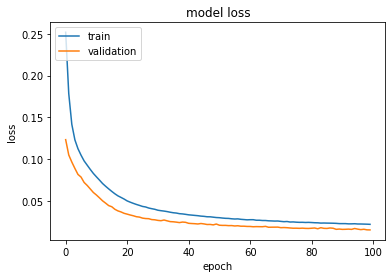

In [13]:
# 1 layer training
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)

In [14]:
# 1 layer testing
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96-fc1d-patch_1-base_1-layer_1-label_NDIsynthetic
(84, 50, 96)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               14550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has s

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


2D CNN

96
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 150)         129750    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 1, 1, 1)           0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
['N']
The remained data has shape: (81634, 3, 3, 96)
(81634, 3, 3, 96)
(81634, 1, 1, 150)
(81634, 1, 1, 150)
(

2022-04-09 16:17:13.757896: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:17:13.757973: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:17:14.162936: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:17:14.176151: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:17:14.176360: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:17:14.177419: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_17_14
2022-04-09 16:17:14.177837: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_17_14/vw.trace.json.gz
2022-04-09 16:17:14.177887: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:17:14.178731: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

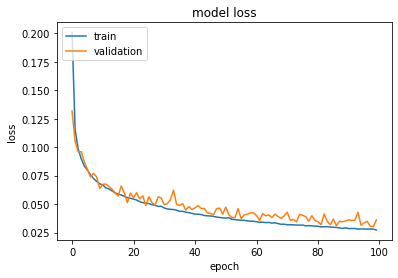

In [23]:
# 1 layer training
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)

In [24]:
# 1 layer testing
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96-conv2d-patch_3-base_1-layer_1-label_NDIsynthetic
(84, 84, 96)
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 82, 82, 150)       129750    
_________________________________________________________________
dropout_10 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 82, 82, 1)         0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction 

3D CNN

96
Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
['N']
The remained data has shape: (81634, 3, 3, 3, 96)
(81634, 3, 3, 3, 96)
(81634, 1, 1, 1, 150)
(81634, 1, 

2022-04-09 16:25:35.758701: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:25:35.758842: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:25:36.352630: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:25:36.370442: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:25:36.370654: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:25:36.371741: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_25_36
2022-04-09 16:25:36.372179: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_25_36/vw.trace.json.gz
2022-04-09 16:25:36.372236: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:25:36.373088: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

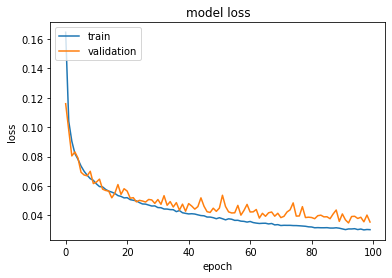

In [33]:
# 1 layer training
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)

In [34]:
# 1 layer testing
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96-conv3d-patch_3-base_1-layer_1-label_NDIsynthetic
(84, 84, 50)
Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
dropout_19 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_19 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
predicti

1
fc1d
96input size the ssim score for ndi is: 0.981044503148479
3
conv2d
96input size the ssim score for ndi is: 0.9750496666015048
3
conv3d
96input size the ssim score for ndi is: 0.9765840441720738


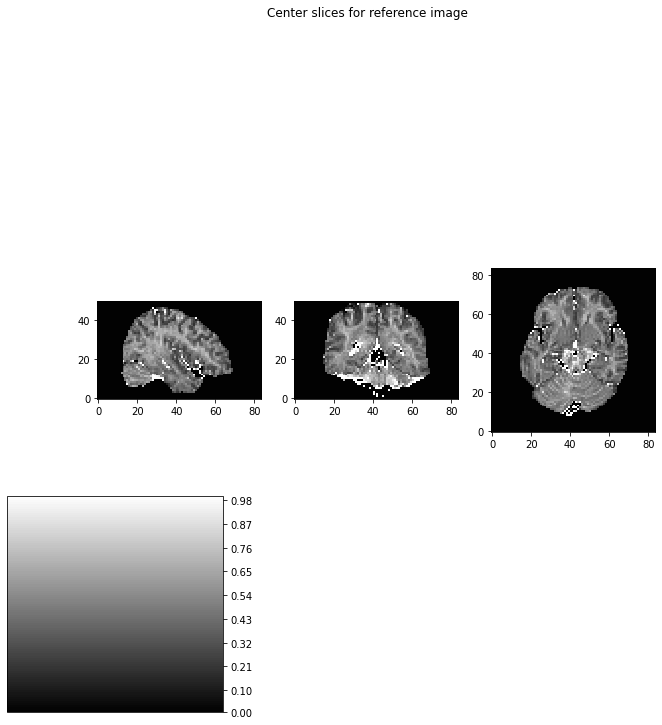

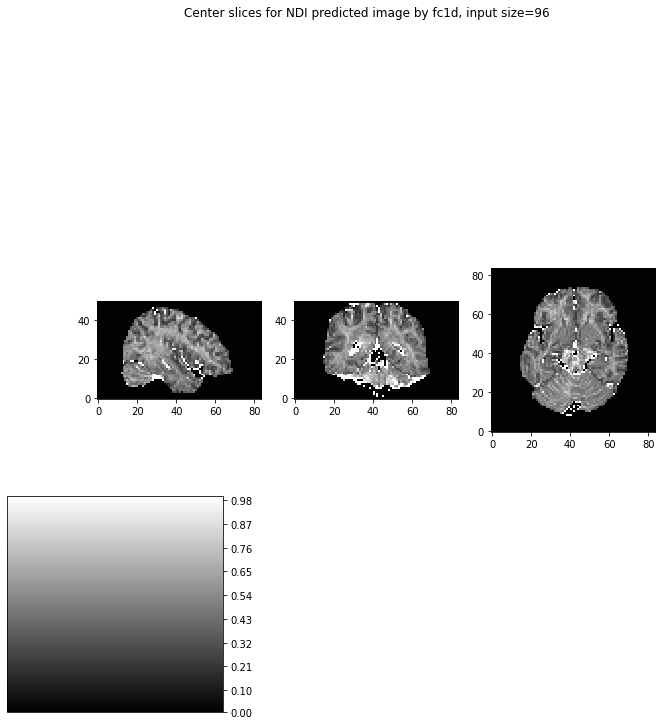

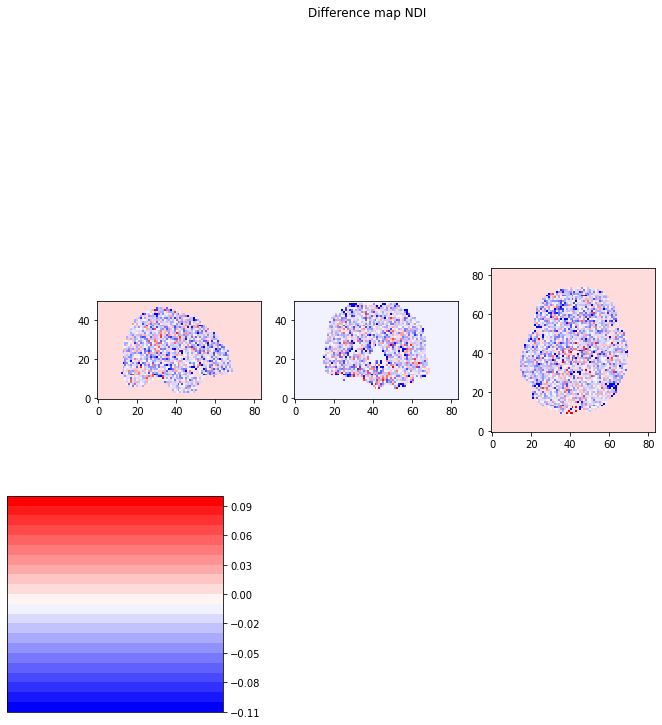

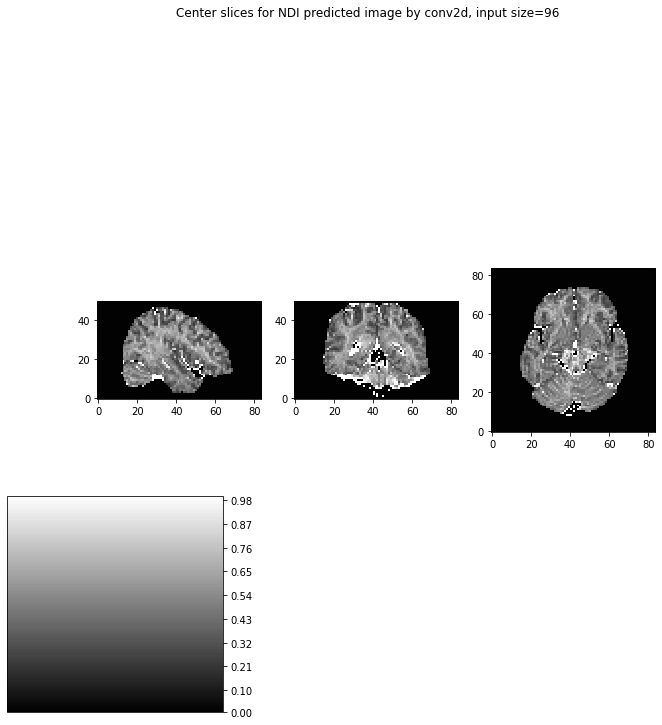

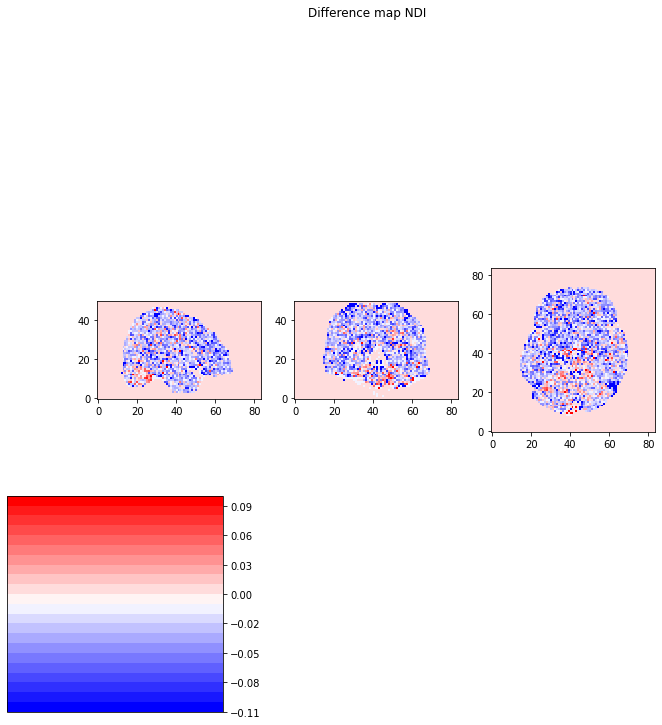

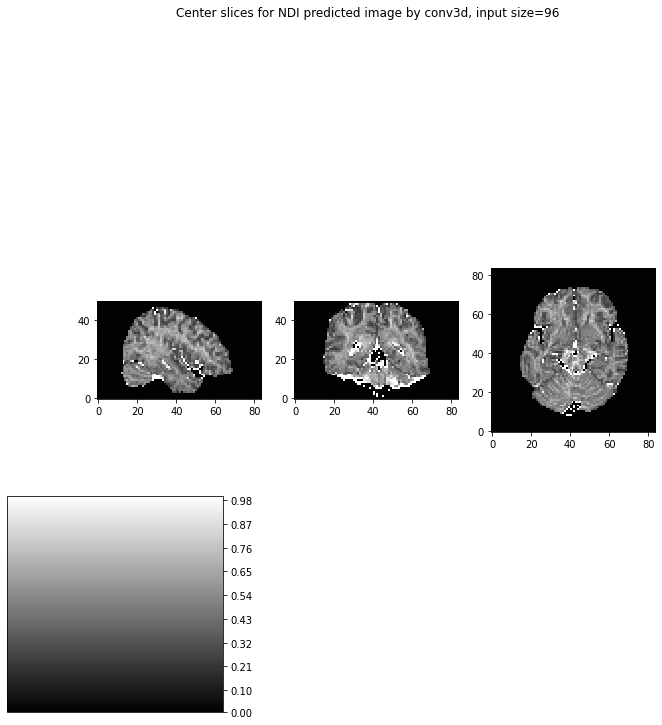

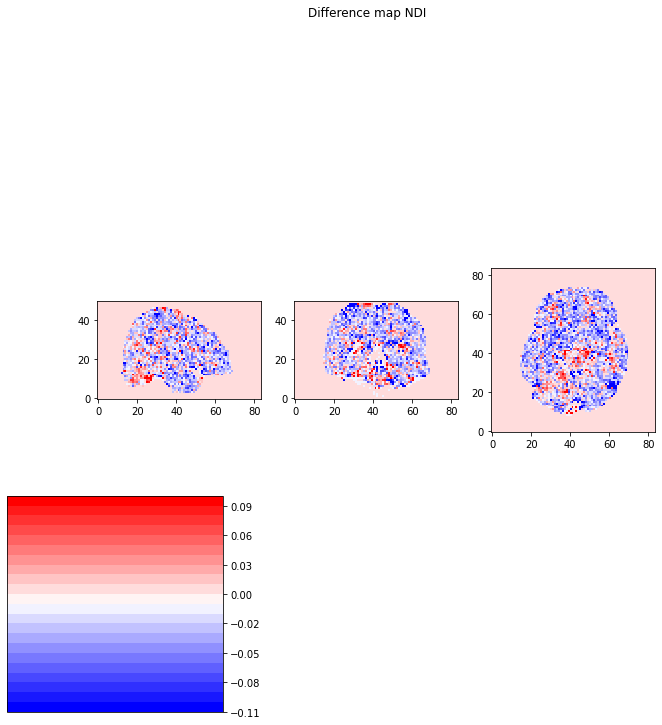

In [35]:
# load the reference img and pred img
visualise0(s02_NDI_img_data)
visualise1(s02_NDI_img_data, 96, 's02_still', 'fc1d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv2d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv3d',layer, s02_NDI_affine)

<strong>2 layer</strong>

In [36]:
layer = 2 

ANN

96
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
______________________________________________

2022-04-09 16:19:23.421541: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:19:23.421646: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:19:23.643664: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:19:23.676374: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:19:23.677039: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:19:23.678948: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_19_23
2022-04-09 16:19:23.679481: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_19_23/vw.trace.json.gz
2022-04-09 16:19:23.679591: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:19:23.680712: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

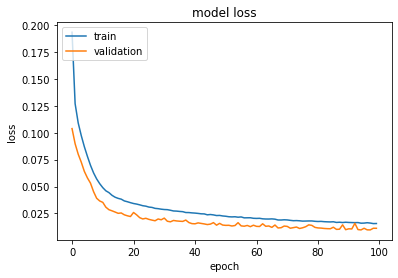

96-fc1d-patch_1-base_1-layer_2-label_NDIsynthetic
(84, 50, 96)
Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_13 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-traina

In [28]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 1, 1, 1)           0         
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
____________________________________________

2022-04-09 16:20:27.044818: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:20:27.044932: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:20:27.570536: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:20:27.590000: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:20:27.590233: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:20:27.591376: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_20_27
2022-04-09 16:20:27.591821: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_20_27/vw.trace.json.gz
2022-04-09 16:20:27.591880: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:20:27.592764: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

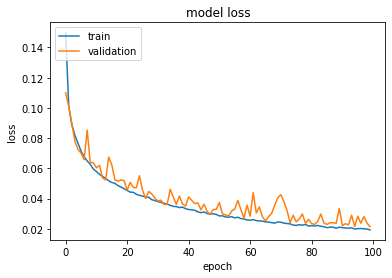

96-conv2d-patch_3-base_1-layer_2-label_NDIsynthetic
(84, 84, 96)
Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_15 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_15 (ReLU)              (None, 82, 82, 1)         0         
Total params: 152,551
Trainable params: 152,551
Non-tr

In [29]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_20 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
____________________________________________

2022-04-09 16:28:20.373737: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:28:20.373826: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:28:20.988537: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:28:21.006699: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:28:21.006926: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:28:21.008051: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_28_21
2022-04-09 16:28:21.008508: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_28_21/vw.trace.json.gz
2022-04-09 16:28:21.008567: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:28:21.009456: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

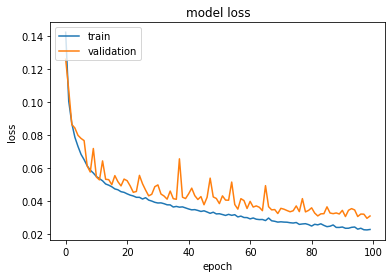

96-conv3d-patch_3-base_1-layer_2-label_NDIsynthetic
(84, 84, 50)
Model: "functional_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_21 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_21 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 411,751
Trainable params: 411,751
Non-tr

In [37]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.982281986261369
3
conv2d
96input size the ssim score for ndi is: 0.9807958057194299
3
conv3d
96input size the ssim score for ndi is: 0.9794607537352463


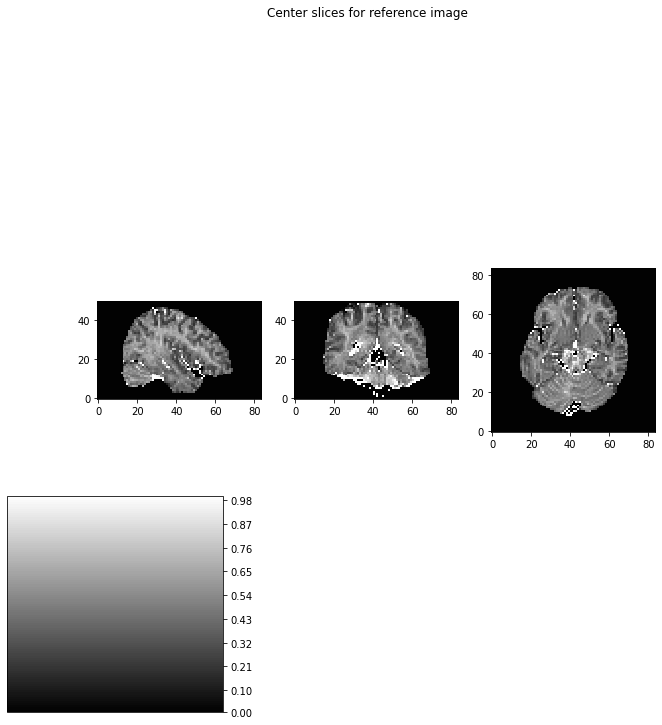

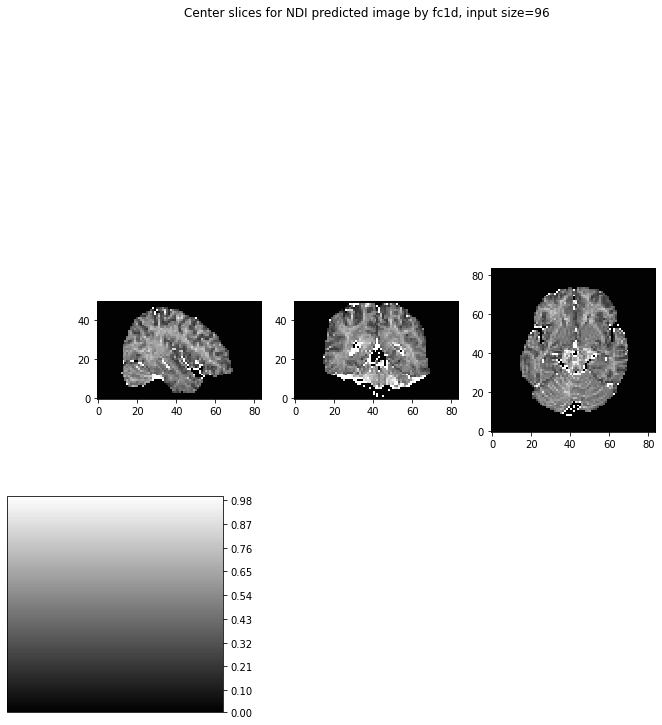

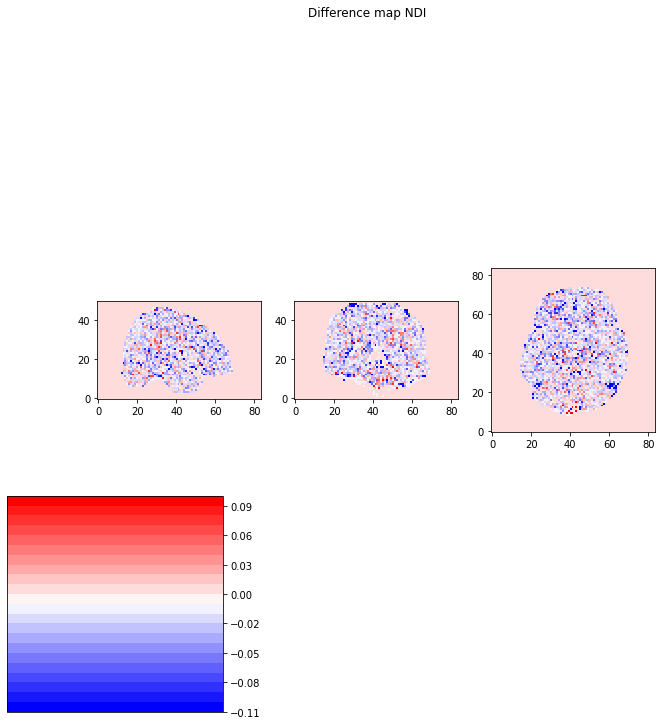

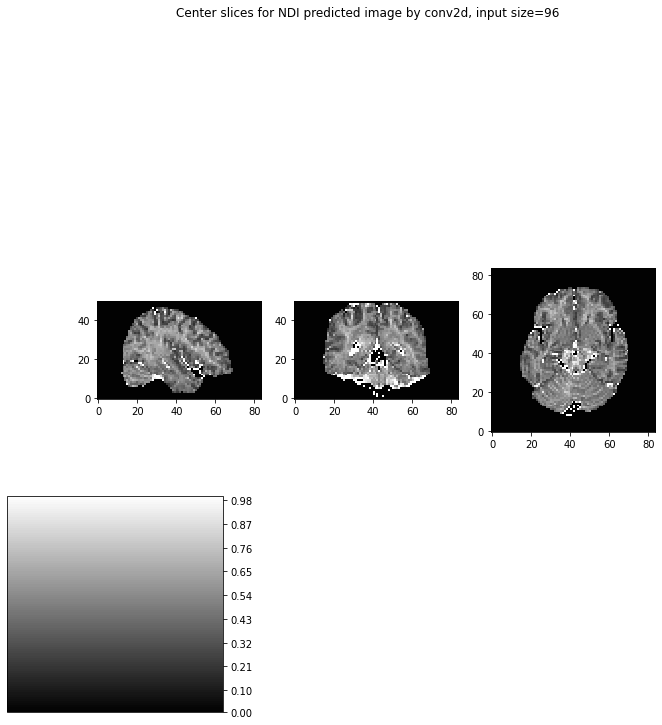

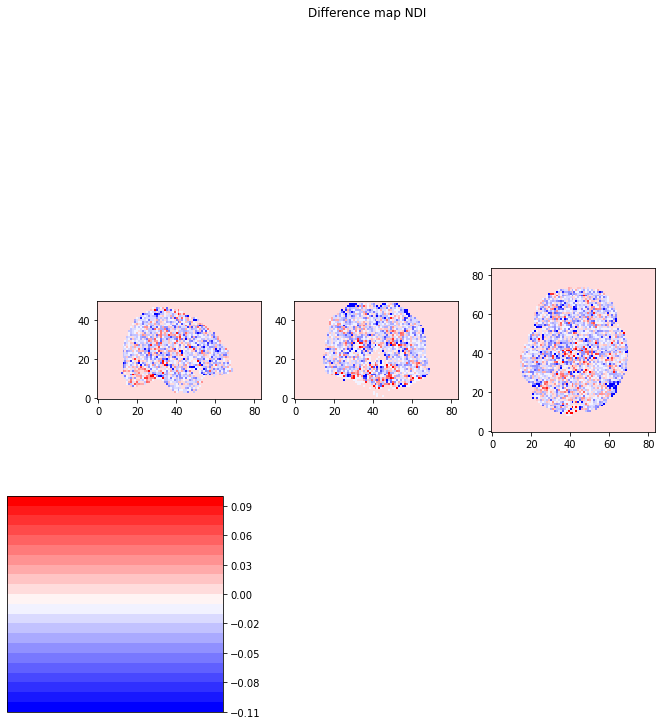

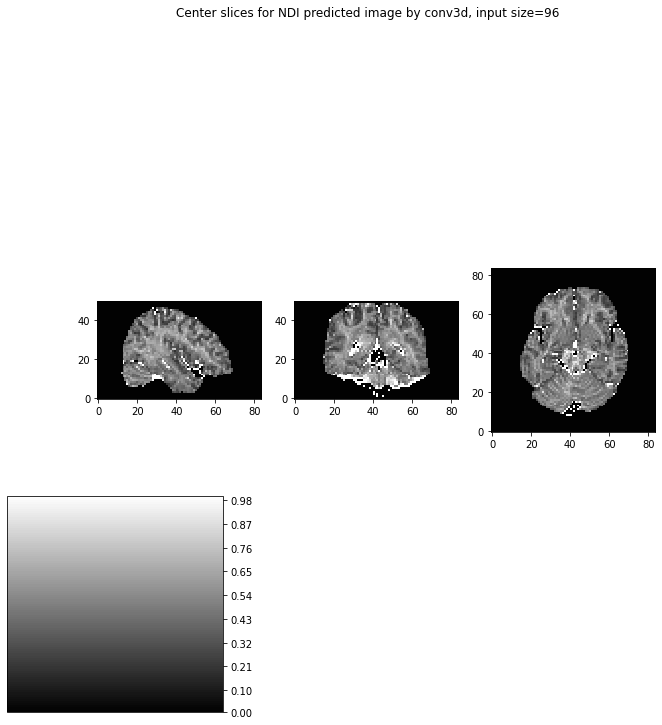

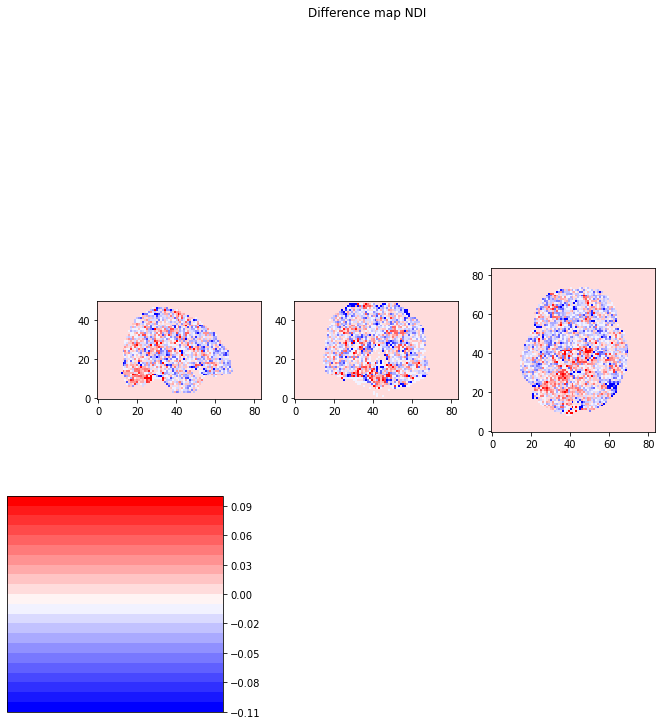

In [38]:
# load the reference img and pred img
visualise0(s02_NDI_img_data)
visualise1(s02_NDI_img_data, 96, 's02_still', 'fc1d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv2d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv3d',layer, s02_NDI_affine)

<strong>3 layer</strong>

In [39]:
layer = 3

ANN

96
Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_8 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_22 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 1)            

2022-04-09 16:31:12.391662: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:31:12.391779: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:31:12.636629: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:31:12.653116: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:31:12.653357: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:31:12.654551: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_31_12
2022-04-09 16:31:12.655036: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_31_12/vw.trace.json.gz
2022-04-09 16:31:12.655112: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:31:12.656112: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

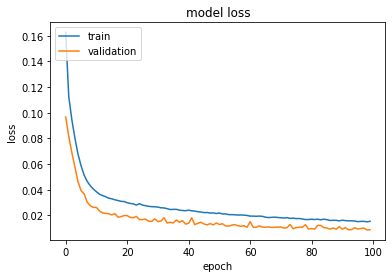

96-fc1d-patch_1-base_1-layer_3-label_NDIsynthetic
(84, 50, 96)
Model: "functional_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_10 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_11 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_23 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
________________________________________________________

In [40]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_28 (ReLU)              (None, 1, 1, 1)      

2022-04-09 16:37:02.336904: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:37:02.337029: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:37:02.791407: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:37:02.811880: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:37:02.812156: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:37:02.813368: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_37_02
2022-04-09 16:37:02.813846: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_37_02/vw.trace.json.gz
2022-04-09 16:37:02.813906: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:37:02.814849: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

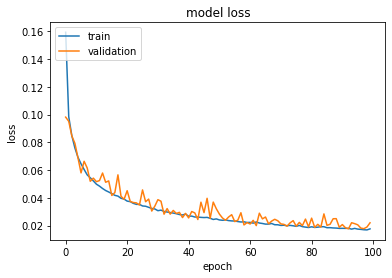

96-conv2d-patch_3-base_1-layer_3-label_NDIsynthetic
(84, 84, 96)
Model: "functional_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_29 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 82, 82, 1)         151       
______________________________________________________

In [44]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_26 (ReLU)              (None, 1, 1, 1, 1)   

2022-04-09 16:33:44.646104: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:33:44.646303: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:33:45.272754: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:33:45.293083: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:33:45.293327: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:33:45.294512: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_33_45
2022-04-09 16:33:45.295008: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_33_45/vw.trace.json.gz
2022-04-09 16:33:45.295068: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:33:45.295977: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

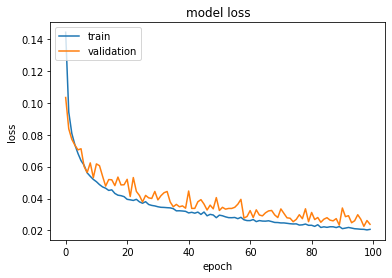

96-conv3d-patch_3-base_1-layer_3-label_NDIsynthetic
(84, 84, 50)
Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_27 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 82, 82, 48, 1)     151       
______________________________________________________

In [42]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9824618285815241
3
conv2d
96input size the ssim score for ndi is: 0.9816342067528728
3
conv3d
96input size the ssim score for ndi is: 0.982079056236675


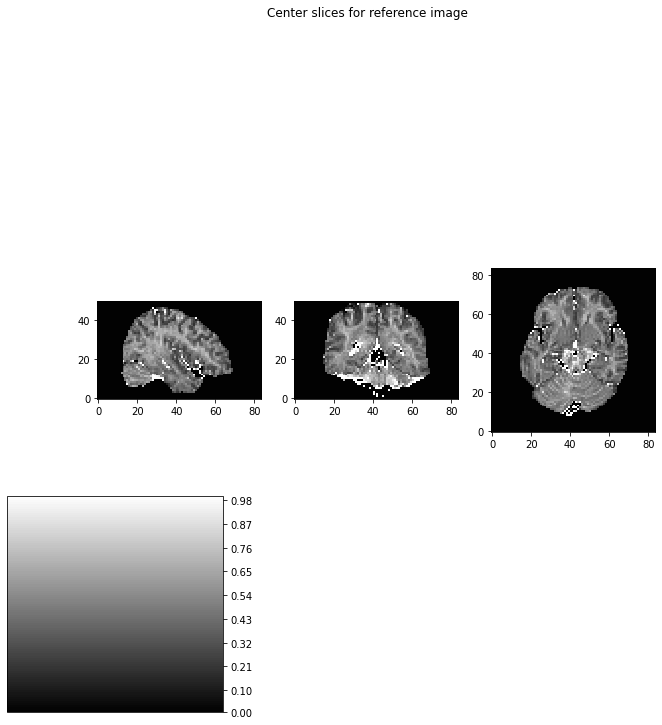

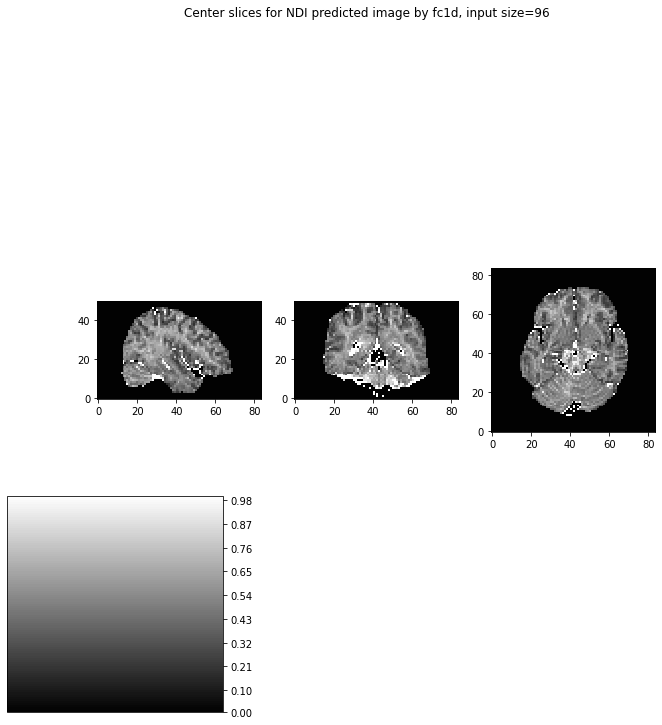

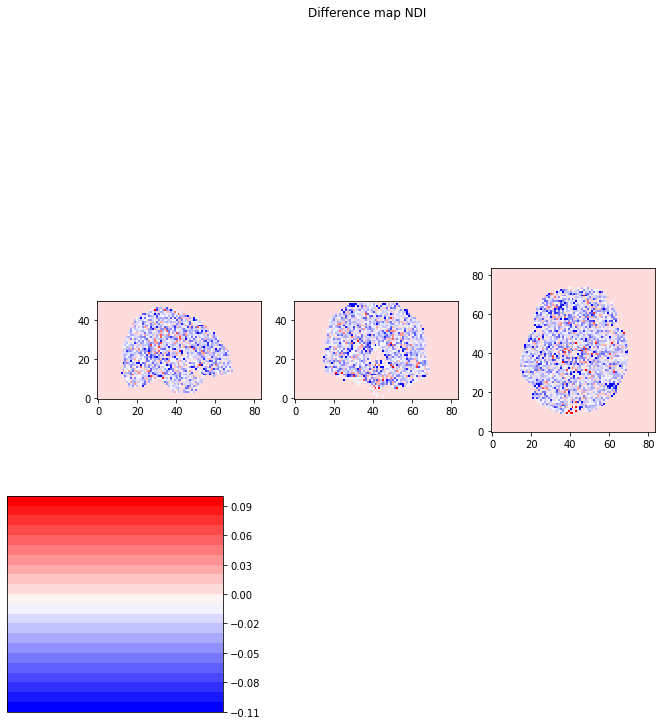

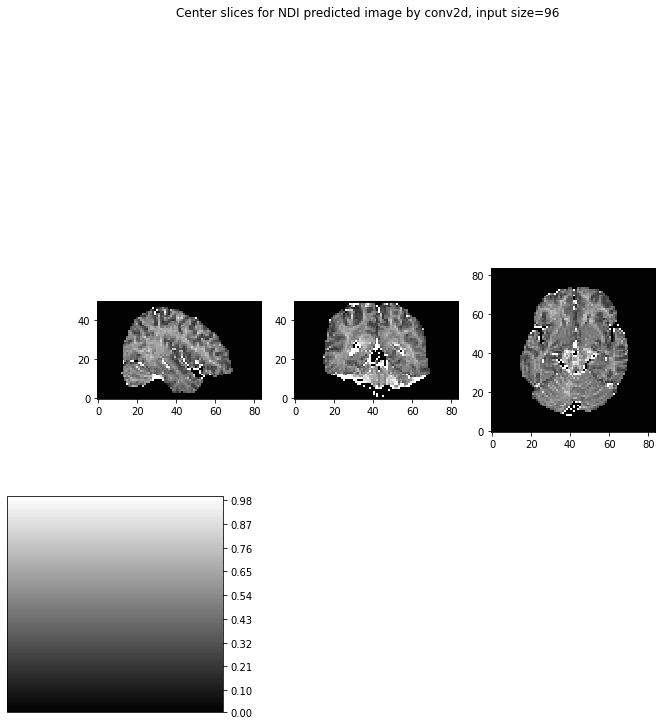

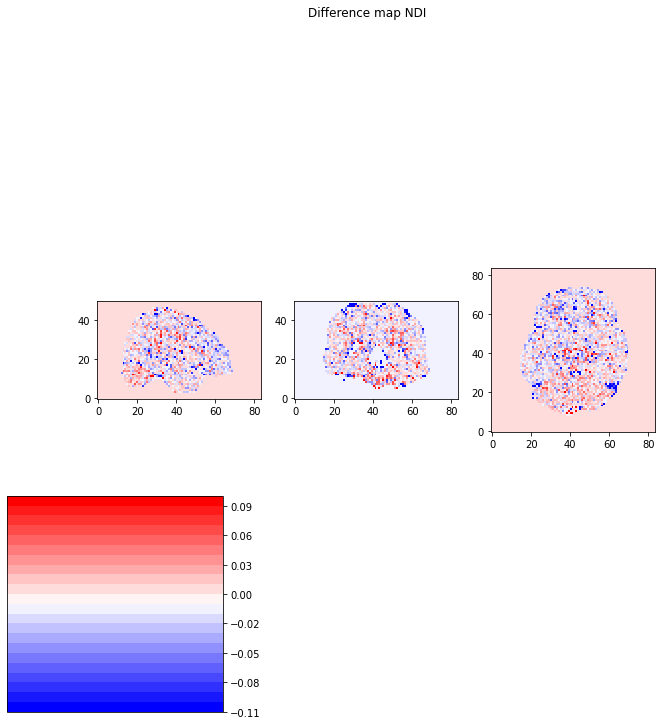

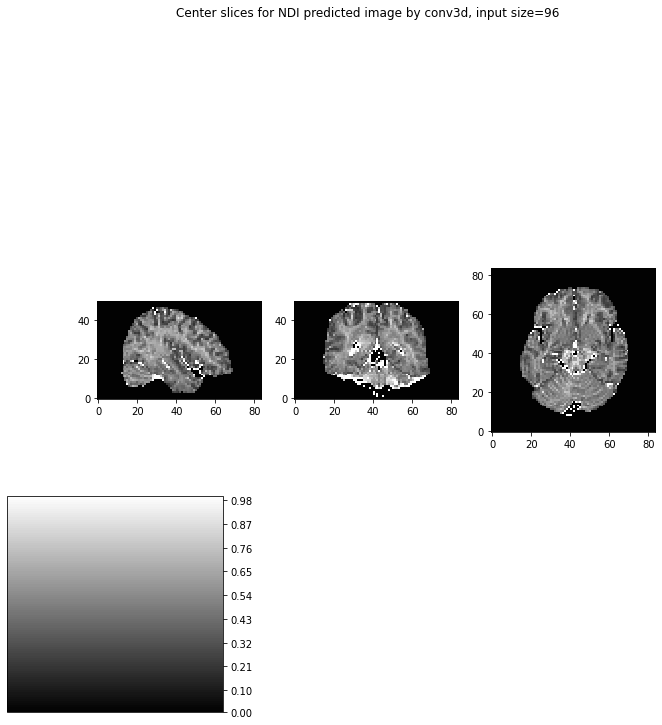

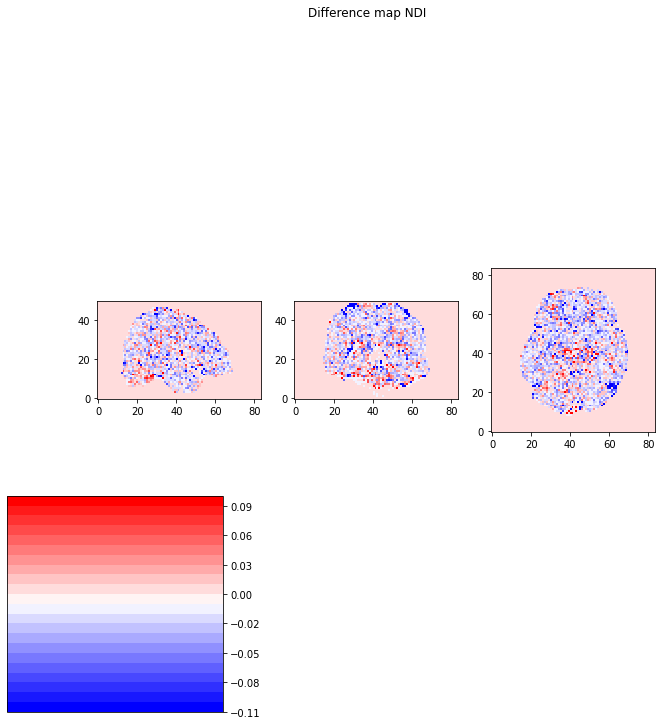

In [45]:
# load the reference img and pred img
visualise0(s02_NDI_img_data)
visualise1(s02_NDI_img_data, 96, 's02_still', 'fc1d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv2d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv3d',layer, s02_NDI_affine)

<strong>4 layer</strong>

In [57]:
layer = 4

ANN

96
Model: "functional_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_31 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_32 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_33 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_44 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)           

2022-04-09 16:54:57.062813: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:54:57.062981: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:54:57.367755: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:54:57.389424: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:54:57.389703: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:54:57.391017: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_54_57
2022-04-09 16:54:57.391521: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_54_57/vw.trace.json.gz
2022-04-09 16:54:57.391592: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:54:57.392559: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

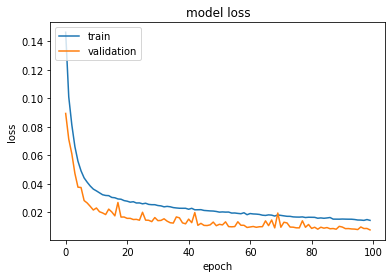

96-fc1d-patch_1-base_1-layer_4-label_NDIsynthetic
(84, 50, 96)
Model: "functional_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_34 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_35 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_36 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_37 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_45 (Dropout)         (None, 150)               0         
_______________________________________________________

In [58]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_48 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 1, 1, 1)     

2022-04-09 16:57:32.938525: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:57:32.938661: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:57:33.431705: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:57:33.452071: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:57:33.452334: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:57:33.453592: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_57_33
2022-04-09 16:57:33.454106: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_57_33/vw.trace.json.gz
2022-04-09 16:57:33.454197: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:57:33.455204: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

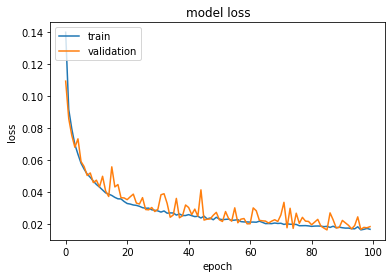

96-conv2d-patch_3-base_1-layer_4-label_NDIsynthetic
(84, 84, 96)
Model: "functional_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_49 (Dropout)         (None, 82, 82, 150)       0         
_____________________________________________________

In [60]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_68 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_50 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_72 (Conv3D)           (None, 1, 1, 1, 1)  

2022-04-09 16:59:32.492407: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:59:32.492541: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:59:33.167978: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:59:33.190316: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:59:33.190609: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:59:33.191856: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_59_33
2022-04-09 16:59:33.192385: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_59_33/vw.trace.json.gz
2022-04-09 16:59:33.192454: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:59:33.193459: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

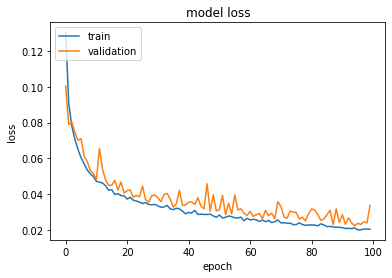

96-conv3d-patch_3-base_1-layer_4-label_NDIsynthetic
(84, 84, 50)
Model: "functional_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_73 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_74 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_75 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_76 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_51 (Dropout)         (None, 82, 82, 48, 150)   0         
_____________________________________________________

In [61]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9826969173695363
3
conv2d
96input size the ssim score for ndi is: 0.9839777599329474
3
conv3d
96input size the ssim score for ndi is: 0.9842923439237699


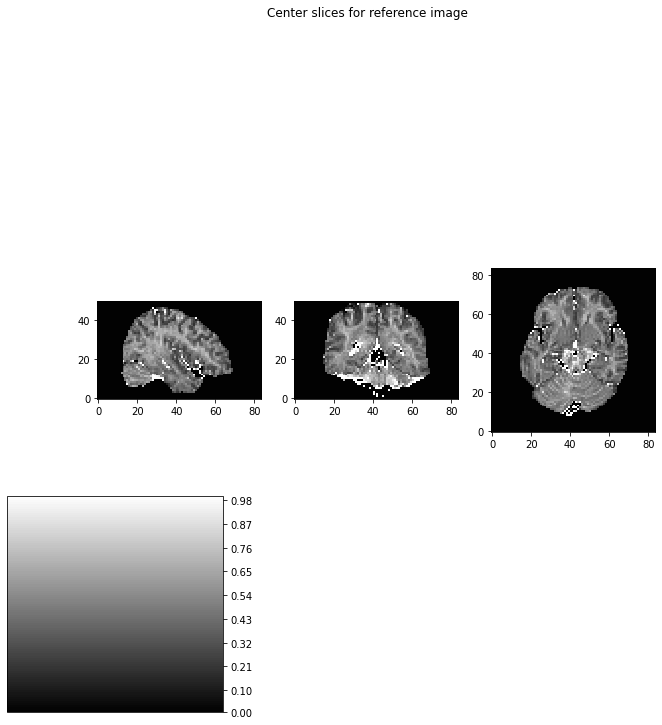

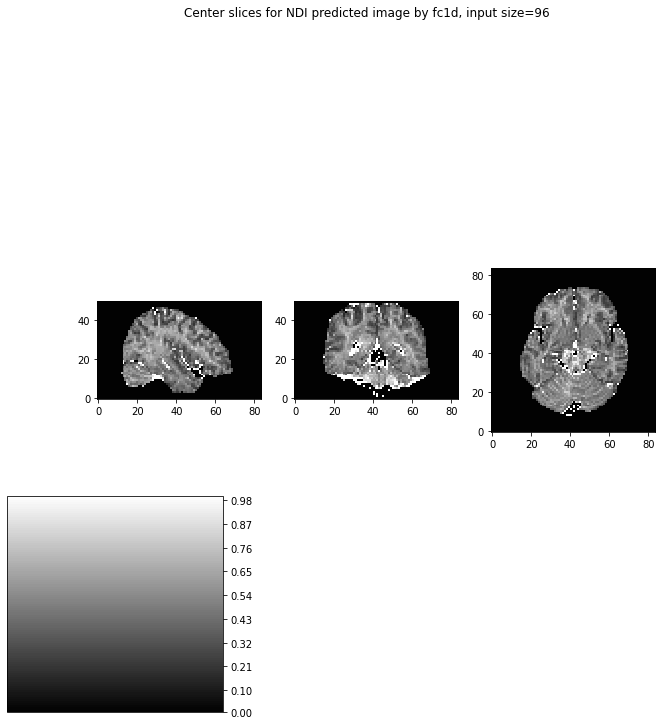

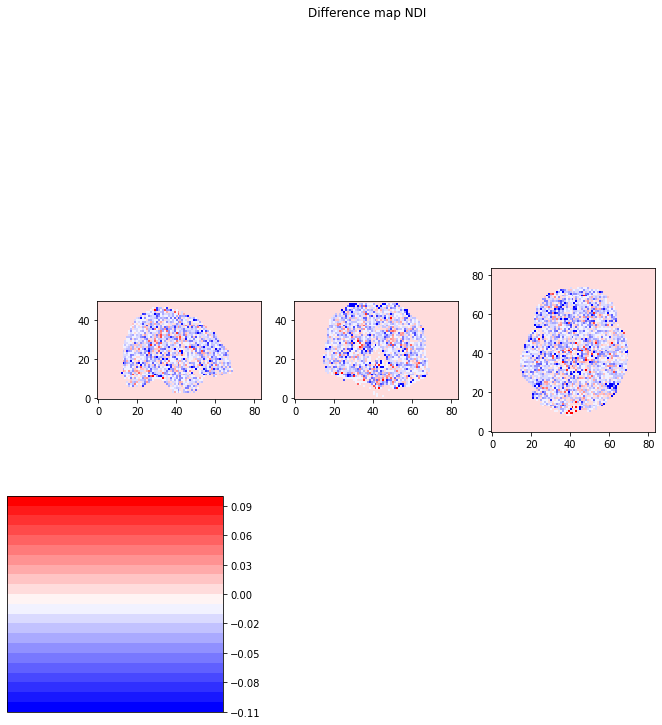

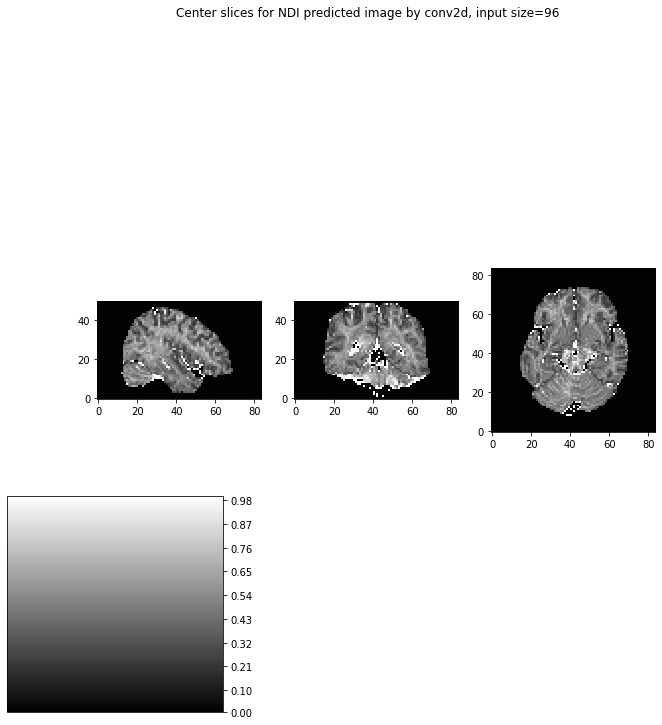

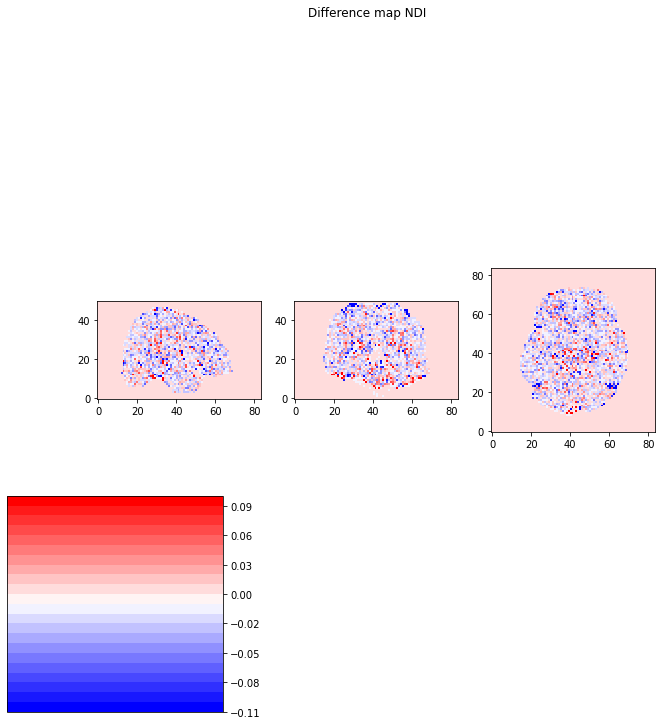

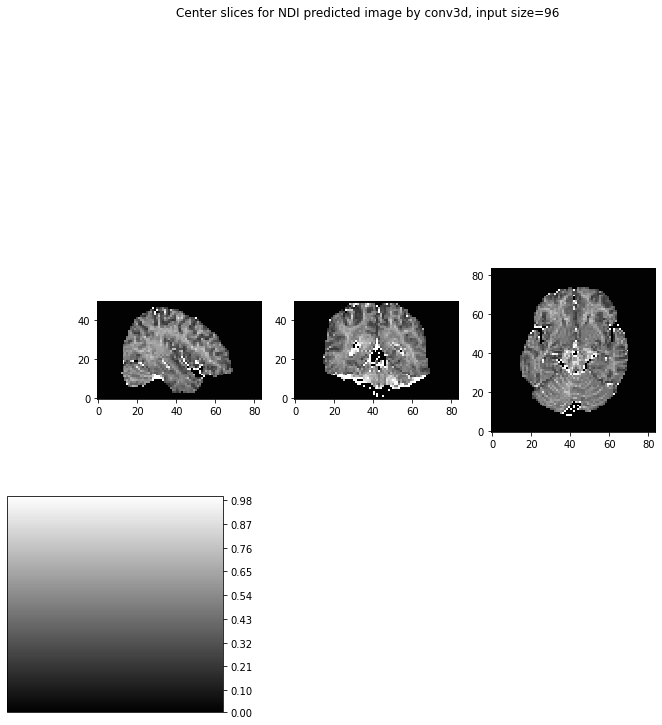

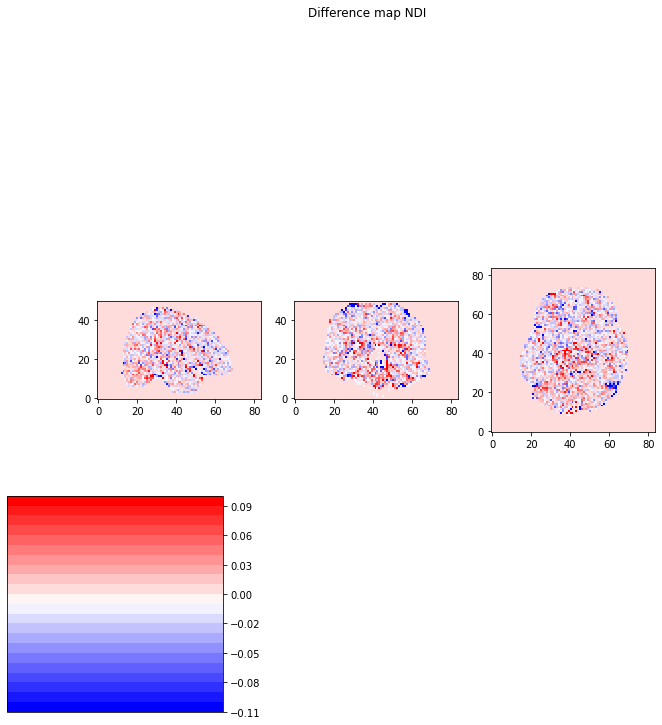

In [62]:
# load the reference img and pred img
visualise0(s02_NDI_img_data)
visualise1(s02_NDI_img_data, 96, 's02_still', 'fc1d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv2d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv3d',layer, s02_NDI_affine)

<strong>5 layer</strong>

In [51]:
layer = 5

ANN

96
Model: "functional_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_21 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_22 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_23 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_24 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_36 (Dropout)         (None, 150)         

2022-04-09 16:45:05.478137: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:45:05.478264: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:45:05.774815: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:45:05.794934: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:45:05.795199: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:45:05.796473: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_45_05
2022-04-09 16:45:05.797011: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_45_05/vw.trace.json.gz
2022-04-09 16:45:05.797081: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:45:05.798060: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

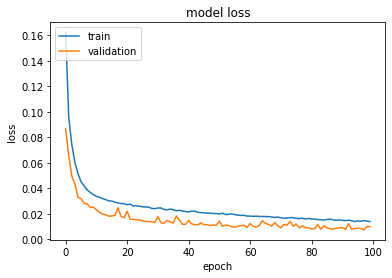

96-fc1d-patch_1-base_1-layer_5-label_NDIsynthetic
(84, 50, 96)
Model: "functional_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_26 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_27 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_28 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_29 (Dense)             (None, 150)               22650     
_______________________________________________________

In [52]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 1, 150)   

2022-04-09 16:46:02.462740: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:46:02.462877: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:46:02.971892: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:46:02.999547: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:46:02.999832: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:46:03.001208: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_46_03
2022-04-09 16:46:03.001810: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_46_03/vw.trace.json.gz
2022-04-09 16:46:03.001903: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:46:03.003021: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

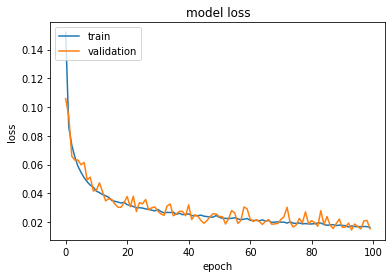

96-conv2d-patch_3-base_1-layer_5-label_NDIsynthetic
(84, 84, 96)
Model: "functional_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 82, 82, 150)       22650     
_____________________________________________________

In [53]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_60 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_42 (Dropout)         (None, 1, 1, 1, 150)

2022-04-09 16:51:09.813527: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:51:09.813635: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 16:51:10.599628: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 16:51:10.623662: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 16:51:10.623986: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 16:51:10.625385: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_16_51_10
2022-04-09 16:51:10.625984: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_16_51_10/vw.trace.json.gz
2022-04-09 16:51:10.626061: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 16:51:10.627129: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

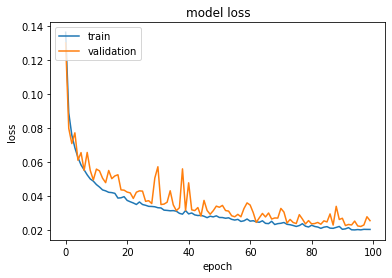

96-conv3d-patch_3-base_1-layer_5-label_NDIsynthetic
(84, 84, 50)
Model: "functional_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [55]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9822349346997872
3
conv2d
96input size the ssim score for ndi is: 0.981826694851192
3
conv3d
96input size the ssim score for ndi is: 0.9825888301901311


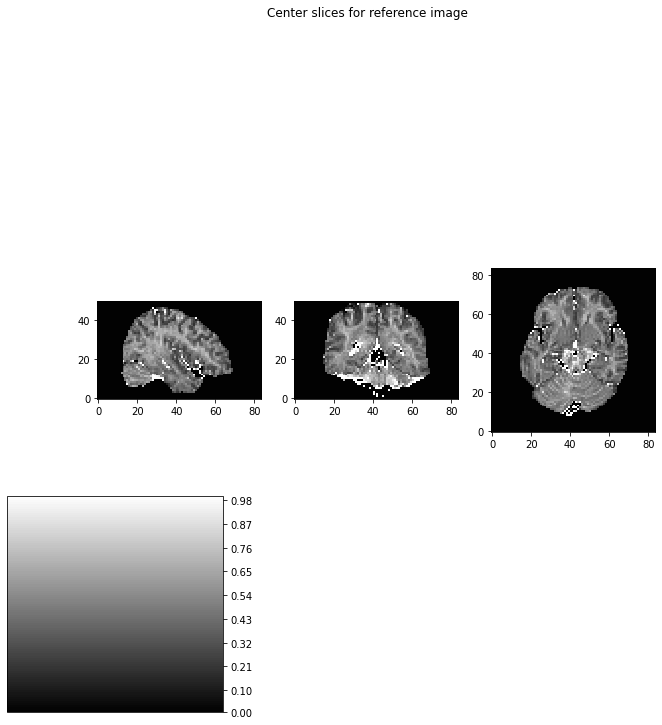

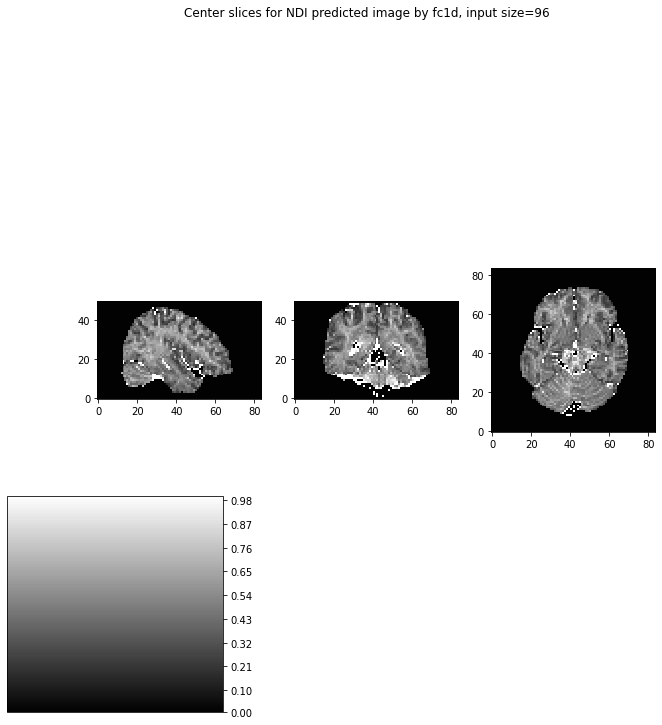

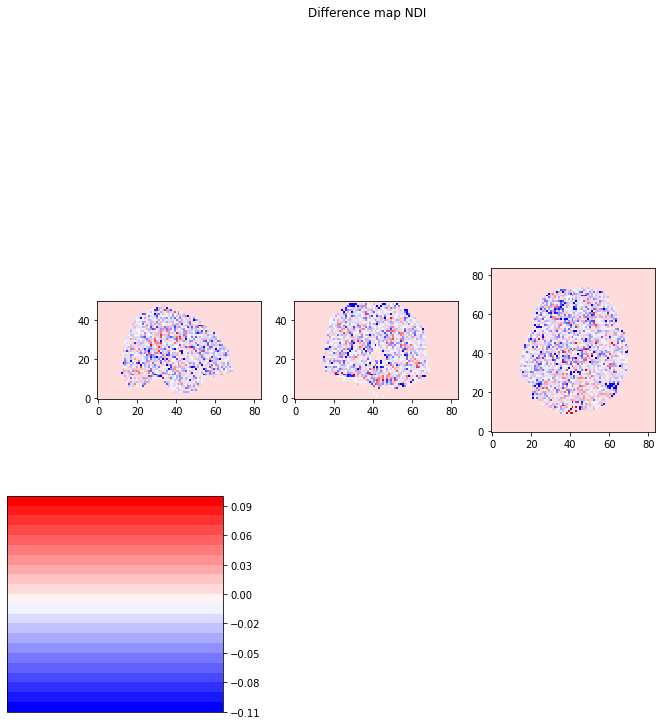

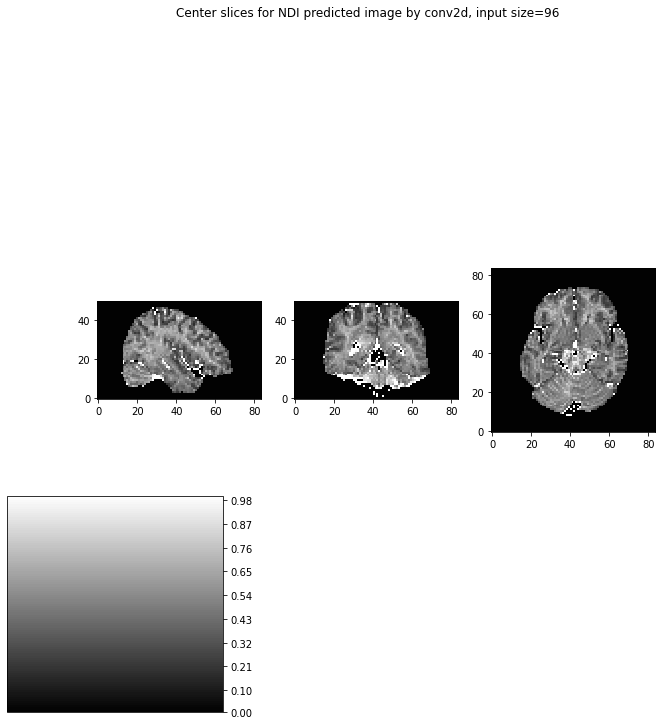

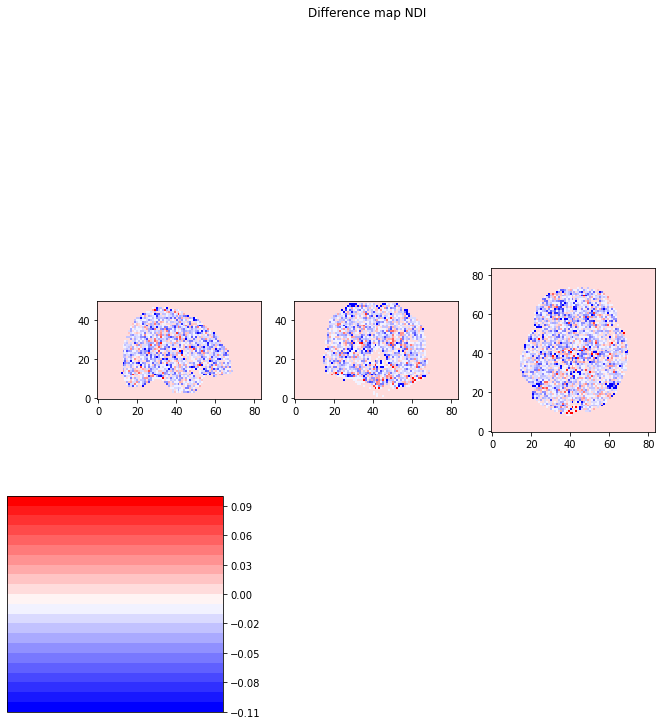

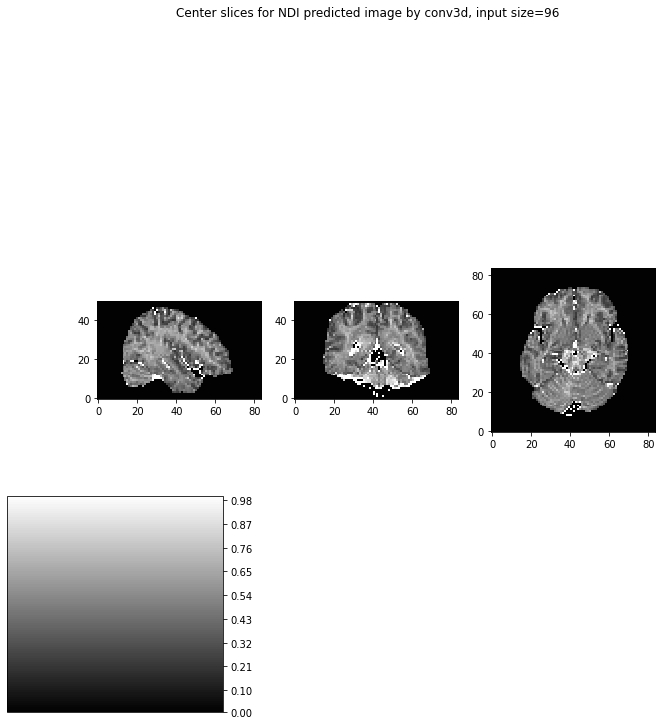

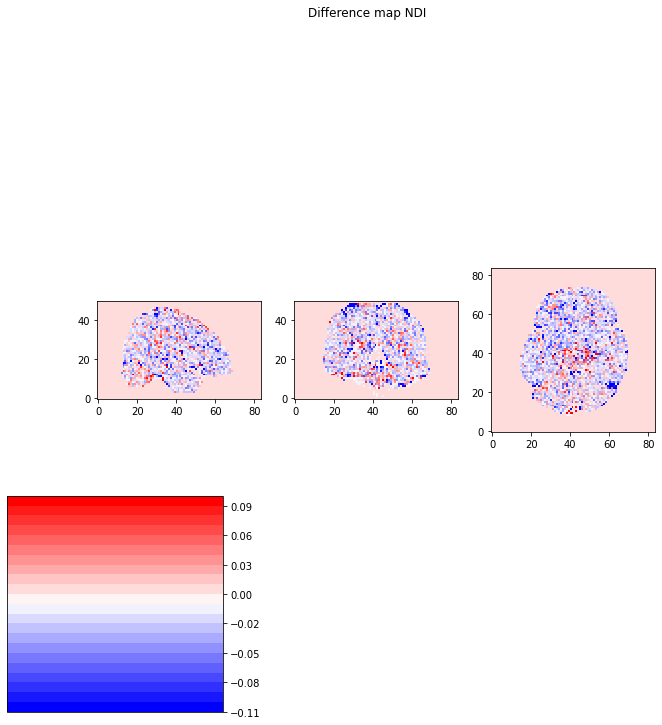

In [56]:
# load the reference img and pred img
visualise0(s02_NDI_img_data)
visualise1(s02_NDI_img_data, 96, 's02_still', 'fc1d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv2d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv3d',layer, s02_NDI_affine)

<strong>6 layer</strong>

In [63]:
layer = 6

ANN

96
Model: "functional_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_38 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_39 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_40 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_41 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_42 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_43 (Dense)             (None, 150)         

2022-04-09 17:03:01.287739: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 17:03:01.287902: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 17:03:01.632278: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 17:03:01.655271: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 17:03:01.655592: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 17:03:01.656968: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_17_03_01
2022-04-09 17:03:01.657530: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_17_03_01/vw.trace.json.gz
2022-04-09 17:03:01.657617: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 17:03:01.658661: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

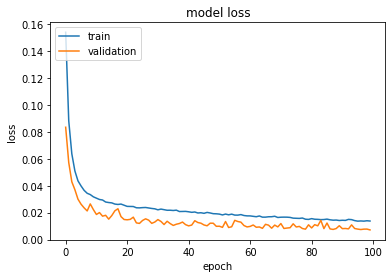

96-fc1d-patch_1-base_1-layer_6-label_NDIsynthetic
(84, 50, 96)
Model: "functional_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_45 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_46 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_47 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_48 (Dense)             (None, 150)               22650     
_______________________________________________________

In [64]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 1, 1, 150)   

2022-04-09 17:10:16.529812: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 17:10:16.529920: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 17:10:17.095798: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 17:10:17.124464: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 17:10:17.124781: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 17:10:17.126167: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_17_10_17
2022-04-09 17:10:17.126743: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_17_10_17/vw.trace.json.gz
2022-04-09 17:10:17.126837: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 17:10:17.127847: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

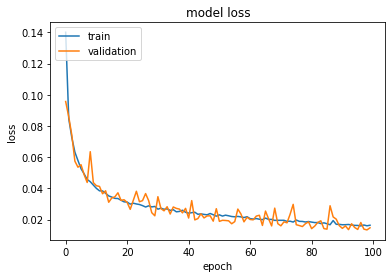

96-conv2d-patch_3-base_1-layer_6-label_NDIsynthetic
(84, 84, 96)
Model: "functional_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 82, 82, 150)       22650     
_____________________________________________________

In [68]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_79 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_80 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_81 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_82 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_83 (Conv3D)           (None, 1, 1, 1, 150)

2022-04-09 17:06:43.570856: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 17:06:43.570991: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 17:06:44.390344: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 17:06:44.416089: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 17:06:44.416383: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 17:06:44.418025: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_17_06_44
2022-04-09 17:06:44.418619: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_17_06_44/vw.trace.json.gz
2022-04-09 17:06:44.418695: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 17:06:44.419797: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

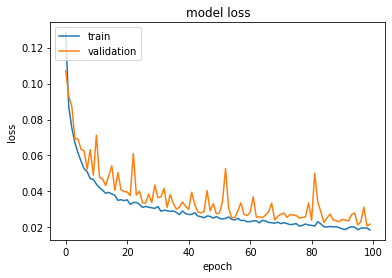

96-conv3d-patch_3-base_1-layer_6-label_NDIsynthetic
(84, 84, 50)
Model: "functional_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_85 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_87 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_88 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_89 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [66]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9822207528392548
3
conv2d
96input size the ssim score for ndi is: 0.9808325024449157
3
conv3d
96input size the ssim score for ndi is: 0.9828325655989499


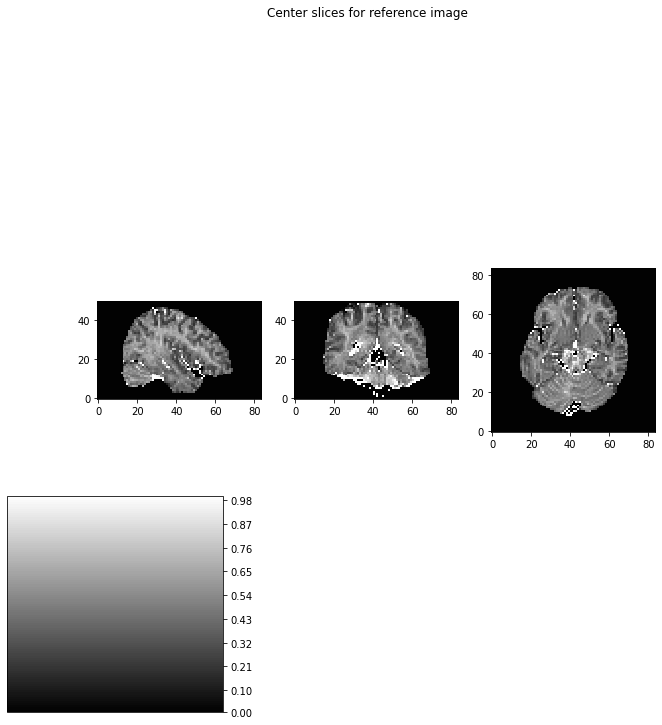

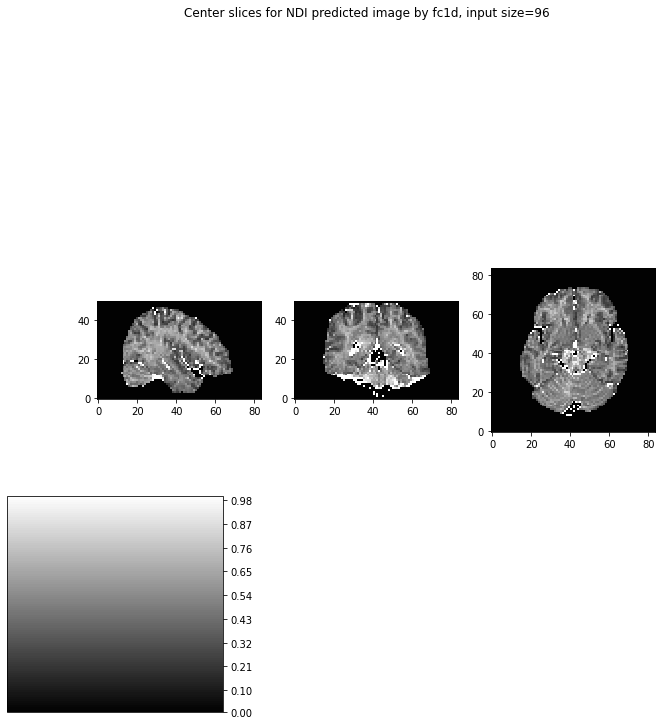

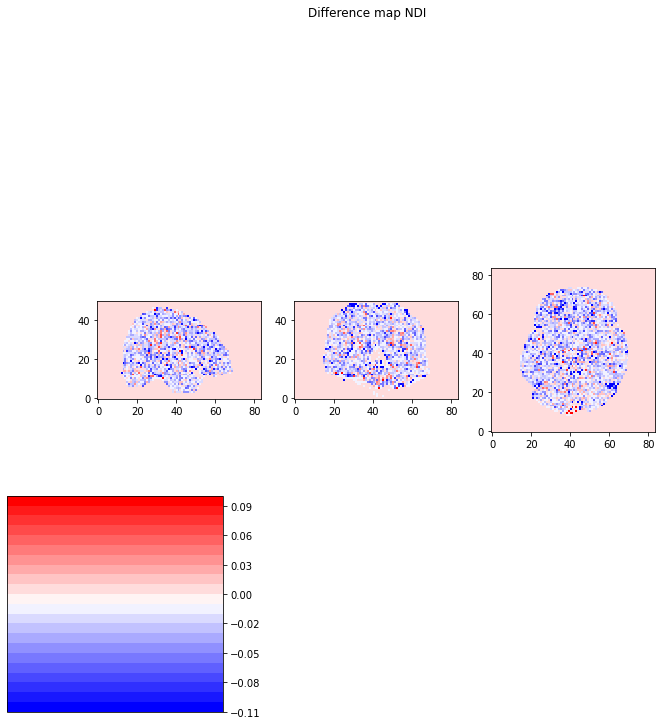

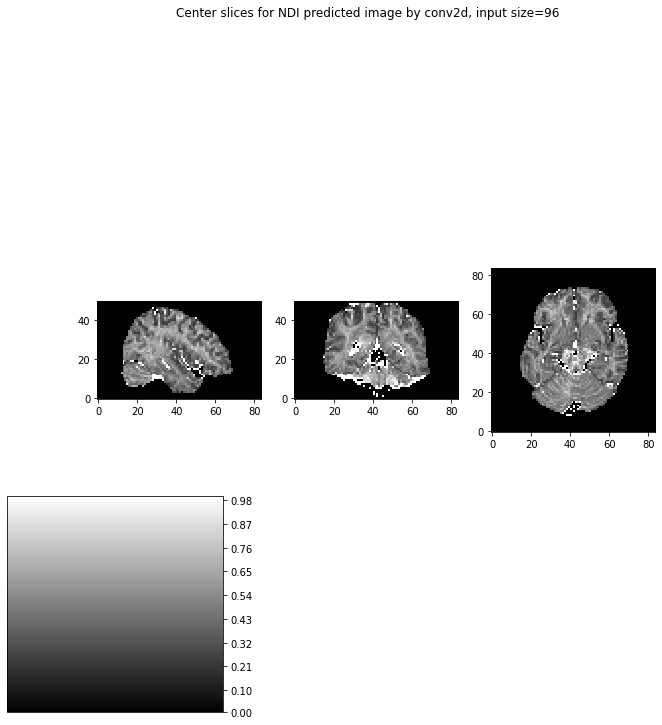

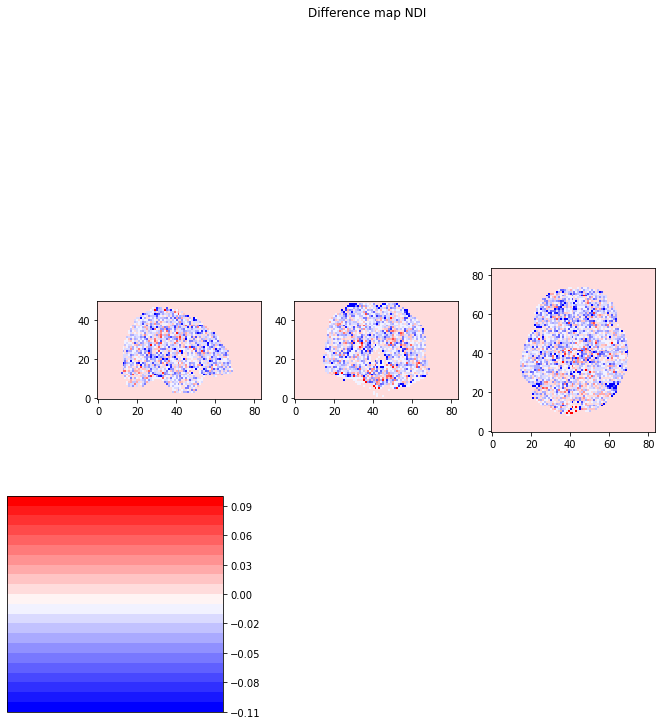

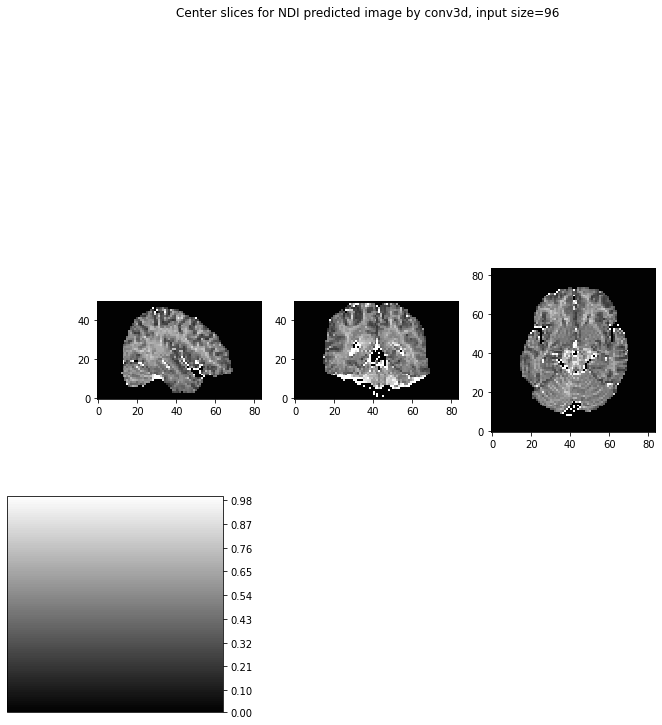

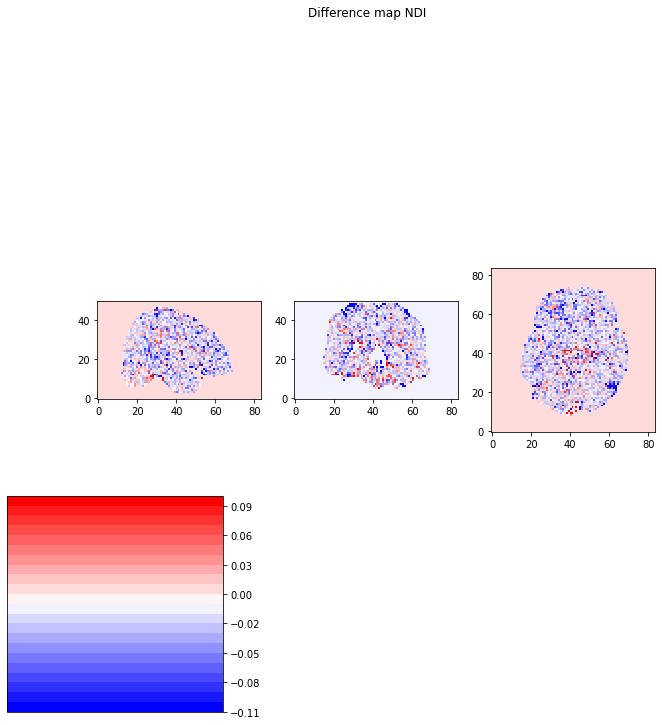

In [69]:
# load the reference img and pred img
visualise0(s02_NDI_img_data)
visualise1(s02_NDI_img_data, 96, 's02_still', 'fc1d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv2d',layer, s02_NDI_affine)
visualise1(s02_NDI_img_data, 96, 's02_still', 'conv3d',layer, s02_NDI_affine)

___

<strong>ODI</strong>


In [49]:
"""
Generate training dataset ODI for ANN.
"""
cmd = "--subjects s01_still s02_still --fc1d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (81882, 96) the ratio of masked voxel is: 0.23209183673469388
training dataset has shape:(81882, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (81882, 1) the ratio of masked voxel is: 0.23209183673469388
training label has shape:(81882, 1)
Generating for s02_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (91401, 96) the ratio of masked voxel is: 0.2590731292517007
training dataset has shape:(91401, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (91401, 1) the ratio of masked voxel is: 0.2590731292517007
training label has shape:(91401, 1)


In [50]:
"""
Generate training dataset ODI for 2D CNN.
"""
cmd = "--subjects s01_still s02_still --conv2d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(81634, 3, 3, 96)
saved patches has shape: (81634, 3, 3, 96)
(81634, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(90846, 3, 3, 96)
saved patches has shape: (90846, 3, 3, 96)
(90846, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1)


In [51]:
"""
Generate training dataset ODI for 3D CNN.
"""
cmd = "--subjects s01_still s02_still --conv3d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(81634, 3, 3, 3, 96)
saved patches has shape: (81634, 2592)
(82, 82, 48, 1) (82, 82, 48)
(81634, 1, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(90846, 3, 3, 3, 96)
saved patches has shape: (90846, 2592)
(82, 82, 48, 1) (82, 82, 48)
(90846, 1, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1, 1)


<strong>1 layer</strong>

In [52]:
layer = 1

ANN

96
Model: "functional_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 150)               14550     
_________________________________________________________________
dropout_36 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_36 (ReLU)              (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
['O']
The remained data has shape: (81882, 96)
(81882, 96)
(81882, 150)
(81882, 150)
(81882, 1)
(81882, 1)
Trai

2022-04-08 03:17:52.898910: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:17:52.899064: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:17:53.141234: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:17:53.160747: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:17:53.160977: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:17:53.162072: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_17_53
2022-04-08 03:17:53.162500: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_17_53/vw.trace.json.gz
2022-04-08 03:17:53.162557: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:17:53.163353: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

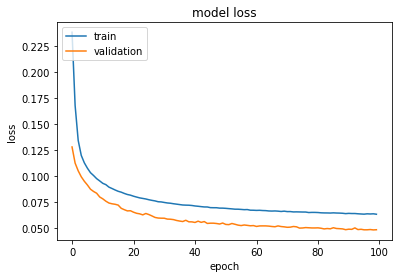

96-fc1d-patch_1-base_1-layer_1-label_ODIsynthetic
(84, 50, 96)
Model: "functional_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_43 (Dense)             (None, 150)               14550     
_________________________________________________________________
dropout_37 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_37 (ReLU)              (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has

In [53]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_38 (ReLU)              (None, 1, 1, 1)           0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
['O']
The remained data has shape: (81634, 3, 3, 96)
(81634, 3, 3, 96)
(81634, 1, 1, 150)
(81634, 1, 1, 150)


2022-04-08 03:18:17.598124: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:18:17.598249: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:18:18.039855: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:18:18.055618: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:18:18.055854: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:18:18.057040: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_18_18
2022-04-08 03:18:18.057488: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_18_18/vw.trace.json.gz
2022-04-08 03:18:18.057557: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:18:18.058389: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

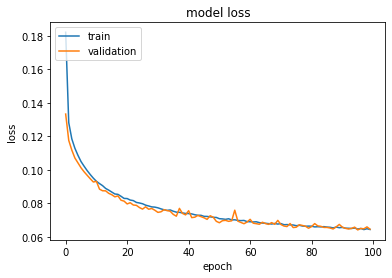

96-conv2d-patch_3-base_1-layer_1-label_ODIsynthetic
(84, 84, 96)
Model: "functional_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
dropout_39 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_39 (ReLU)              (None, 82, 82, 1)         0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction

In [54]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
dropout_40 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_40 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
['O']
The remained data has shape: (81634, 3, 3, 3, 96)
(81634, 3, 3, 3, 96)
(81634, 1, 1, 1, 150)
(81634, 1,

2022-04-08 03:19:09.153228: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:19:09.153385: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:19:09.954899: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:19:09.975194: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:19:09.975434: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:19:09.976557: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_19_09
2022-04-08 03:19:09.977008: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_19_09/vw.trace.json.gz
2022-04-08 03:19:09.977075: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:19:09.977940: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

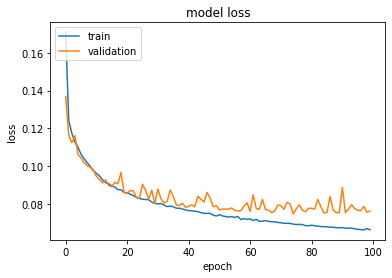

96-conv3d-patch_3-base_1-layer_1-label_ODIsynthetic
(84, 84, 50)
Model: "functional_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
dropout_41 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_41 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
predict

In [55]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9262784036125382
3
conv2d
96input size the ssim score for odi is: 0.9208593004642001
3
conv3d
96input size the ssim score for odi is: 0.9143626797418216


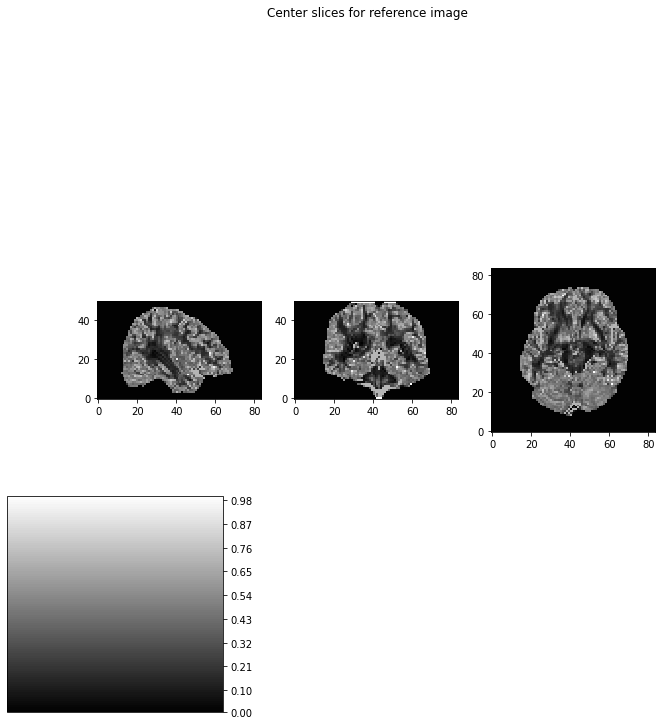

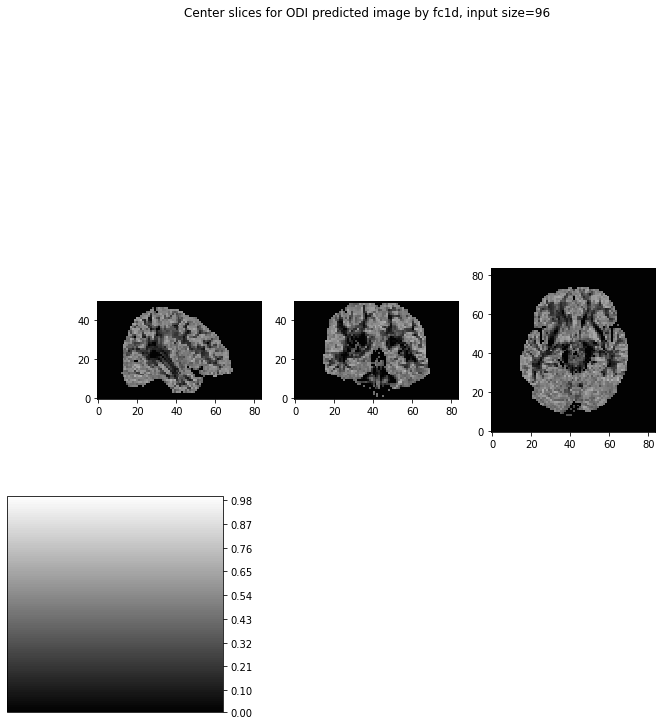

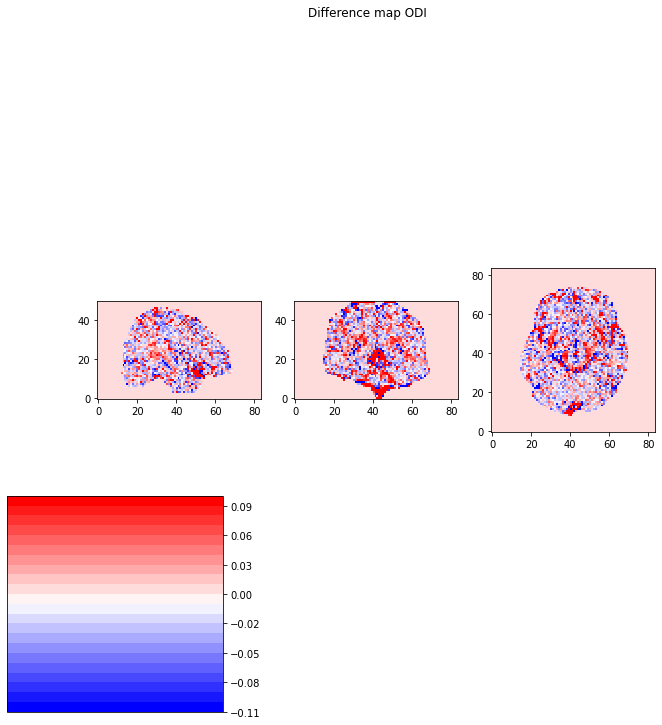

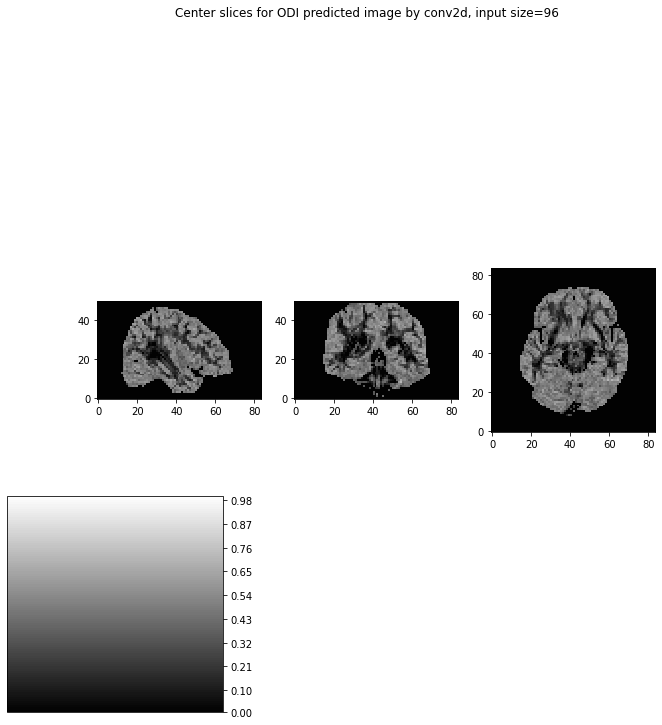

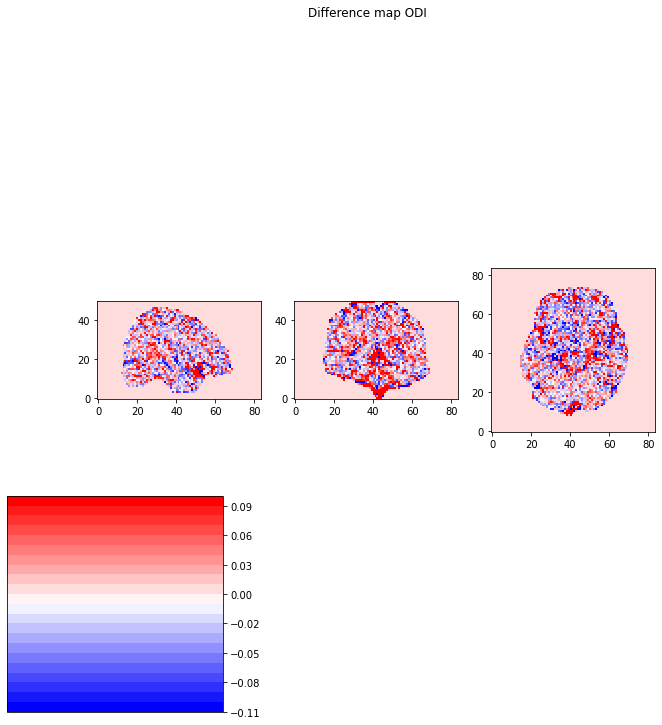

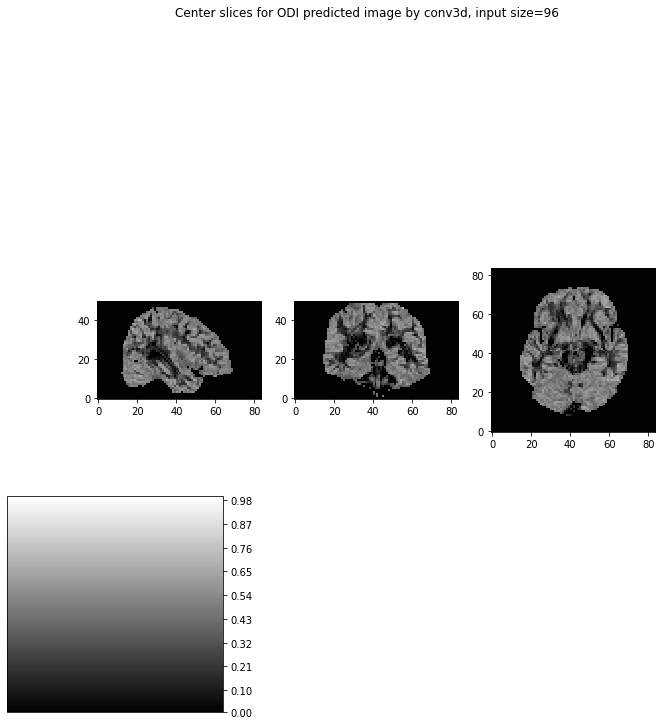

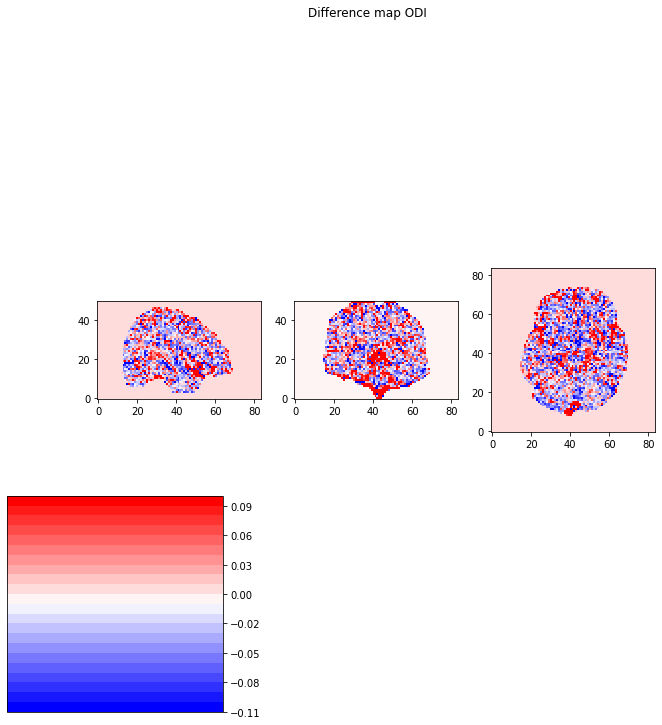

In [56]:
# load the reference img and pred img
visualise0(s02_ODI_img_data)
visualise2(s02_ODI_img_data, 96, 's02_still', 'fc1d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv2d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv3d',layer, s02_ODI_affine)

<strong>2 layer</strong>

In [57]:
layer = 2 

ANN

96
Model: "functional_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_45 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_42 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_42 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
_____________________________________________

2022-04-08 03:21:26.205809: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:21:26.205974: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:21:26.471240: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:21:26.485480: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:21:26.485700: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:21:26.486729: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_21_26
2022-04-08 03:21:26.487178: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_21_26/vw.trace.json.gz
2022-04-08 03:21:26.487238: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:21:26.488149: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

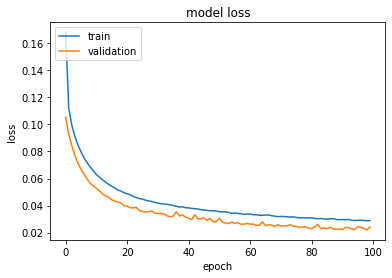

96-fc1d-patch_1-base_1-layer_2-label_ODIsynthetic
(84, 50, 96)
Model: "functional_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_46 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_47 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_43 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_43 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-train

In [58]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_44 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_44 (ReLU)              (None, 1, 1, 1)           0         
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
___________________________________________

2022-04-08 03:21:57.687593: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:21:57.687718: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:21:58.160777: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:21:58.179515: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:21:58.179758: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:21:58.180883: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_21_58
2022-04-08 03:21:58.181367: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_21_58/vw.trace.json.gz
2022-04-08 03:21:58.181446: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:21:58.182381: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

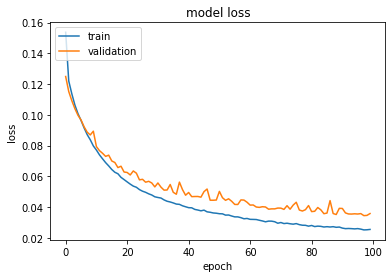

96-conv2d-patch_3-base_1-layer_2-label_ODIsynthetic
(84, 84, 96)
Model: "functional_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_45 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_45 (ReLU)              (None, 82, 82, 1)         0         
Total params: 152,551
Trainable params: 152,551
Non-t

In [59]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_46 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_60 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_46 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
___________________________________________

2022-04-08 03:23:04.182872: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:23:04.183015: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:23:04.863823: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:23:04.882402: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:23:04.882643: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:23:04.886597: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_23_04
2022-04-08 03:23:04.887070: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_23_04/vw.trace.json.gz
2022-04-08 03:23:04.887133: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:23:04.887992: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

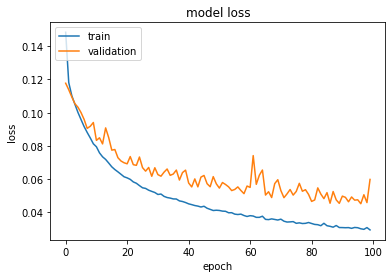

96-conv3d-patch_3-base_1-layer_2-label_ODIsynthetic
(84, 84, 50)
Model: "functional_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_47 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_47 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 411,751
Trainable params: 411,751
Non-t

In [60]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9295415398690933
3
conv2d
96input size the ssim score for odi is: 0.9301529804782793
3
conv3d
96input size the ssim score for odi is: 0.9262953127227347


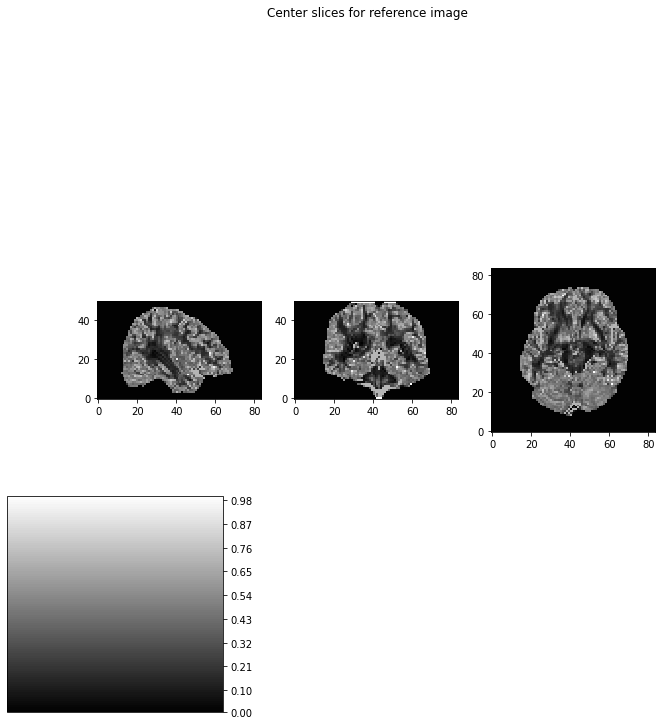

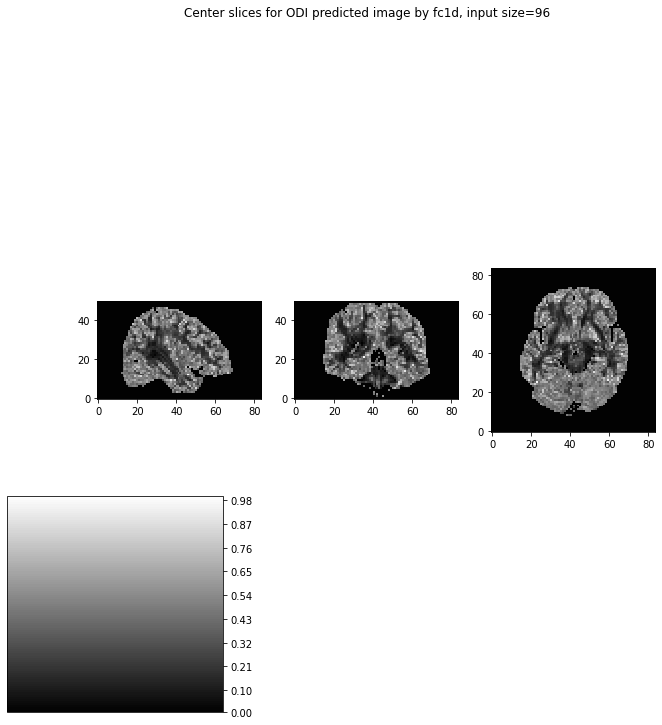

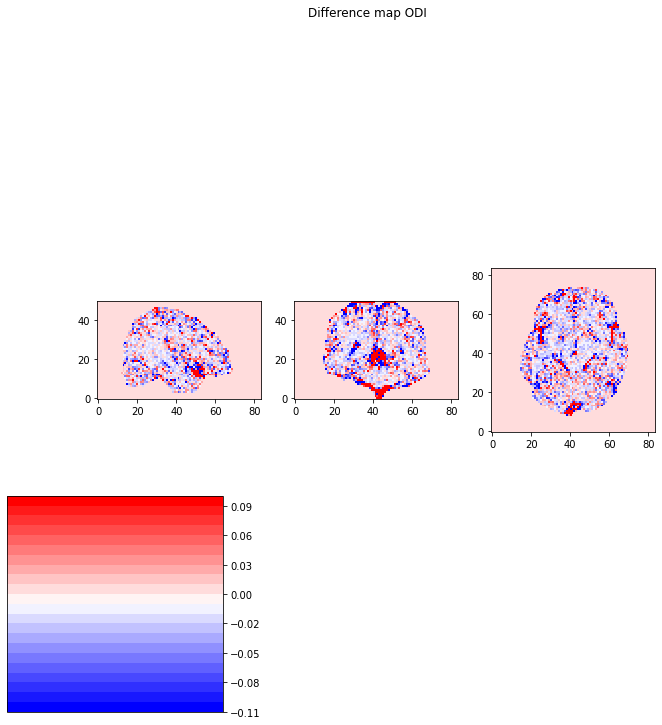

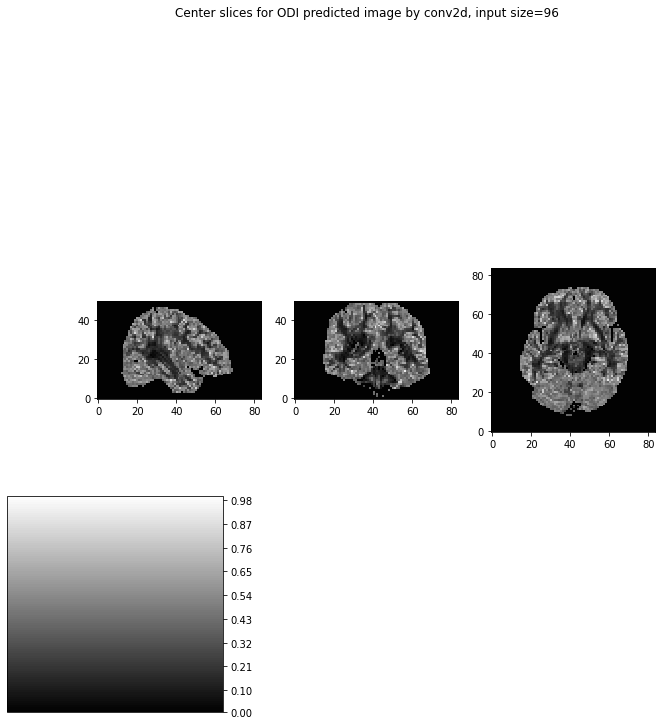

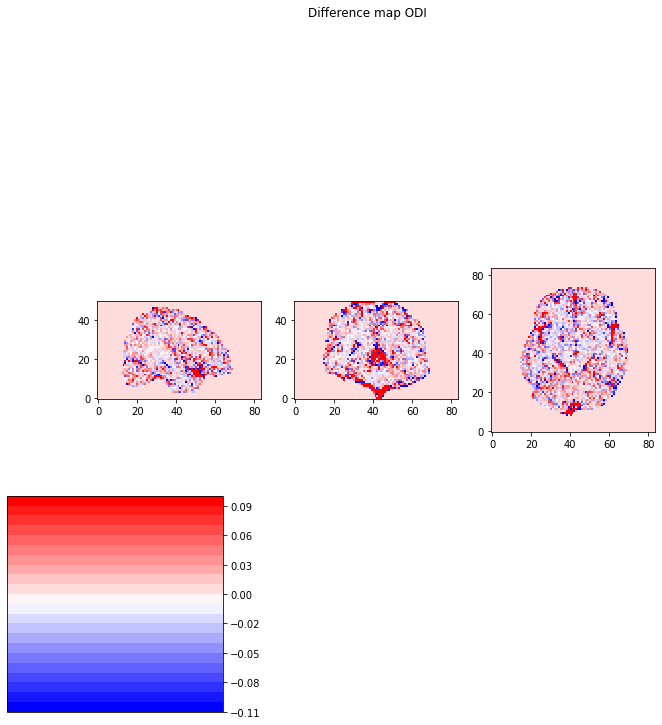

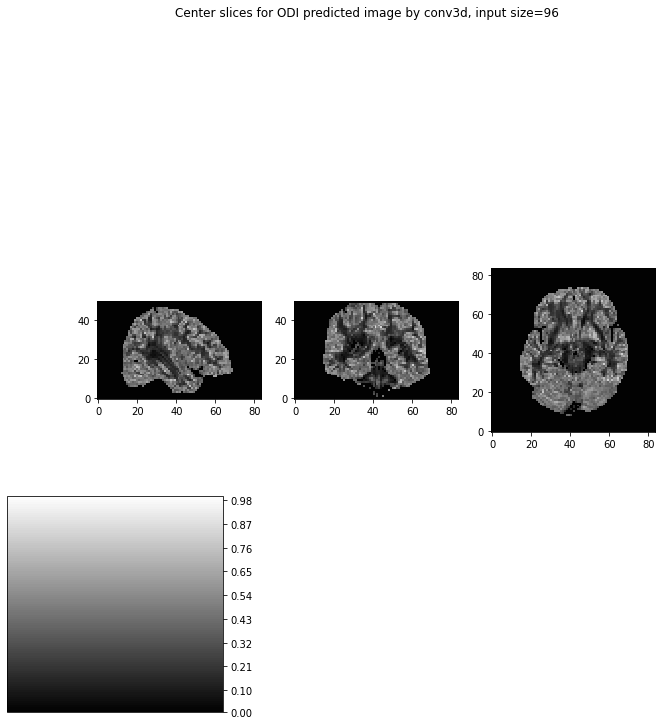

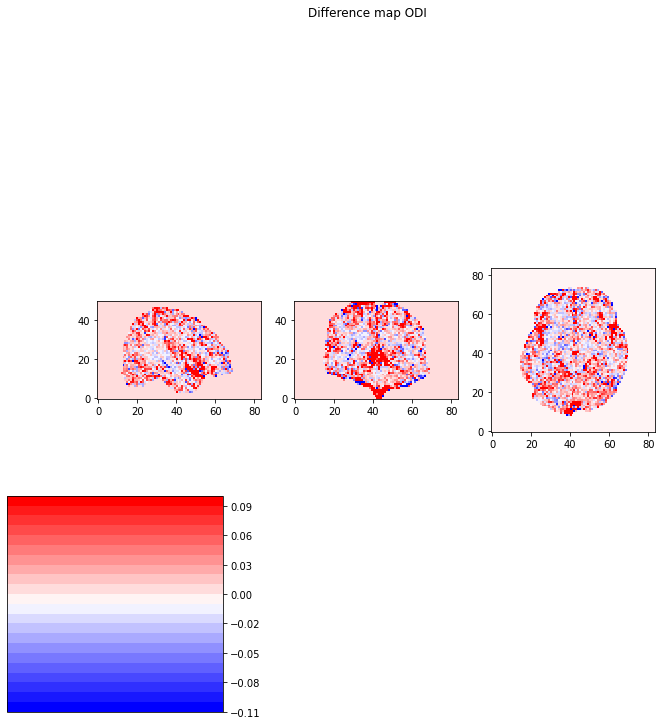

In [61]:
# load the reference img and pred img
visualise0(s02_ODI_img_data)
visualise2(s02_ODI_img_data, 96, 's02_still', 'fc1d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv2d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv3d',layer, s02_ODI_affine)

<strong>3 layer</strong>

In [62]:
layer = 3

ANN

96
Model: "functional_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_49 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_50 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_48 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_48 (ReLU)              (None, 1)           

2022-04-08 03:25:32.268791: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:25:32.268917: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:25:32.564782: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:25:32.582862: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:25:32.583115: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:25:32.584256: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_25_32
2022-04-08 03:25:32.584754: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_25_32/vw.trace.json.gz
2022-04-08 03:25:32.584826: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:25:32.585756: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

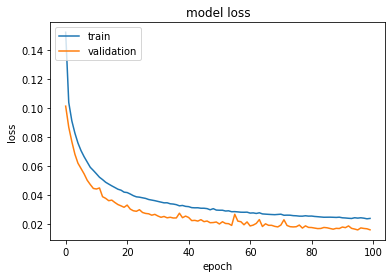

96-fc1d-patch_1-base_1-layer_3-label_ODIsynthetic
(84, 50, 96)
Model: "functional_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_51 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_52 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_53 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_49 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_______________________________________________________

In [63]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_50 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_50 (ReLU)              (None, 1, 1, 1)     

2022-04-08 03:26:09.932734: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:26:09.932812: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:26:10.433718: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:26:10.454866: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:26:10.455127: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:26:10.456271: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_26_10
2022-04-08 03:26:10.456806: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_26_10/vw.trace.json.gz
2022-04-08 03:26:10.456881: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:26:10.457908: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

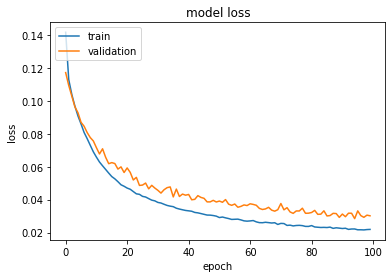

96-conv2d-patch_3-base_1-layer_3-label_ODIsynthetic
(84, 84, 96)
Model: "functional_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_51 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 82, 82, 1)         151       
_____________________________________________________

In [64]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_52 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_67 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_52 (ReLU)              (None, 1, 1, 1, 1)  

2022-04-08 03:27:28.591047: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:27:28.591139: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:27:29.277715: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:27:29.297937: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:27:29.298238: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:27:29.299382: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_27_29
2022-04-08 03:27:29.299866: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_27_29/vw.trace.json.gz
2022-04-08 03:27:29.299934: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:27:29.300800: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

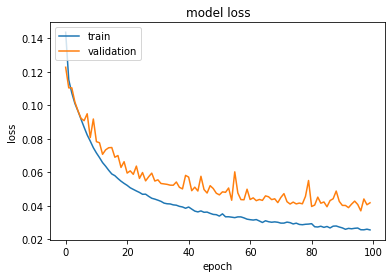

96-conv3d-patch_3-base_1-layer_3-label_ODIsynthetic
(84, 84, 50)
Model: "functional_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_68 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_53 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 82, 82, 48, 1)     151       
_____________________________________________________

In [65]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9309993809928745
3
conv2d
96input size the ssim score for odi is: 0.9303280285459058
3
conv3d
96input size the ssim score for odi is: 0.928905033864276


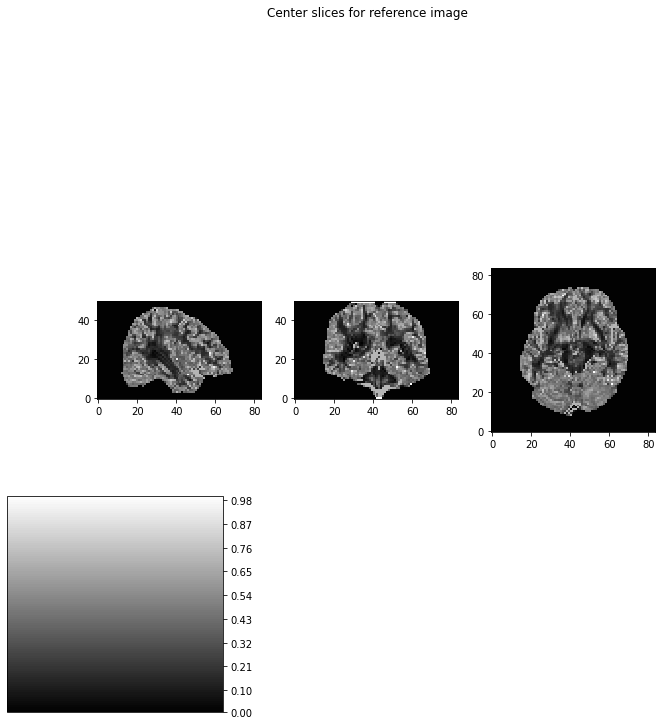

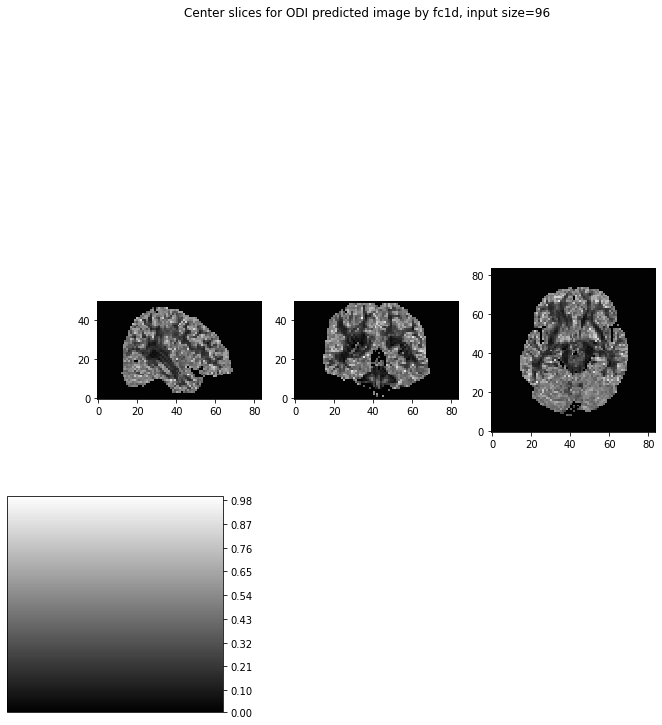

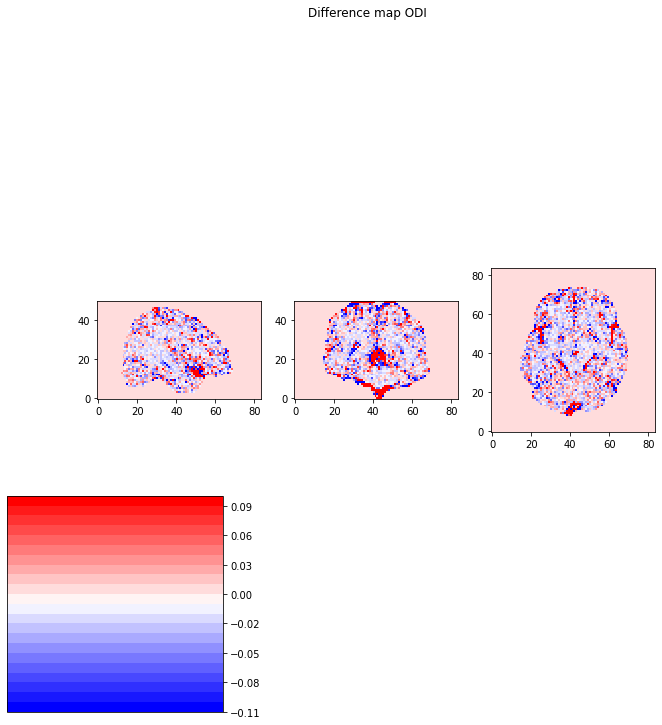

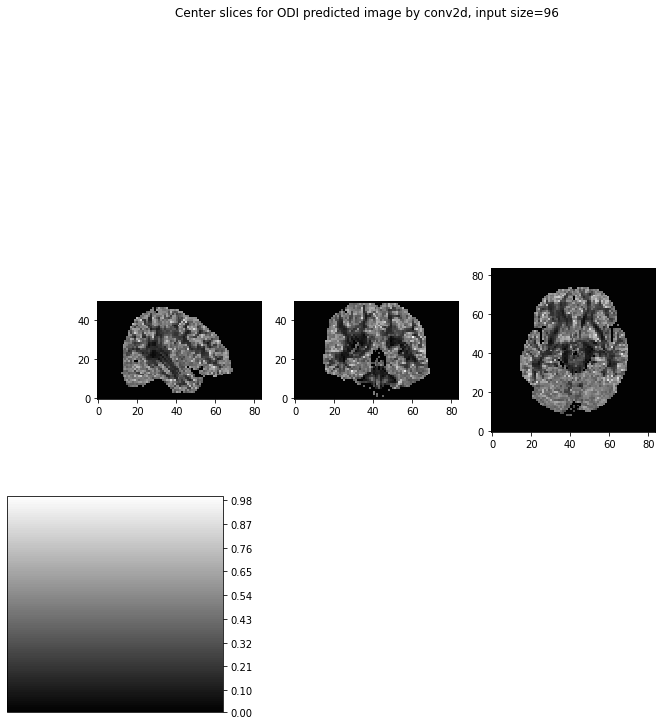

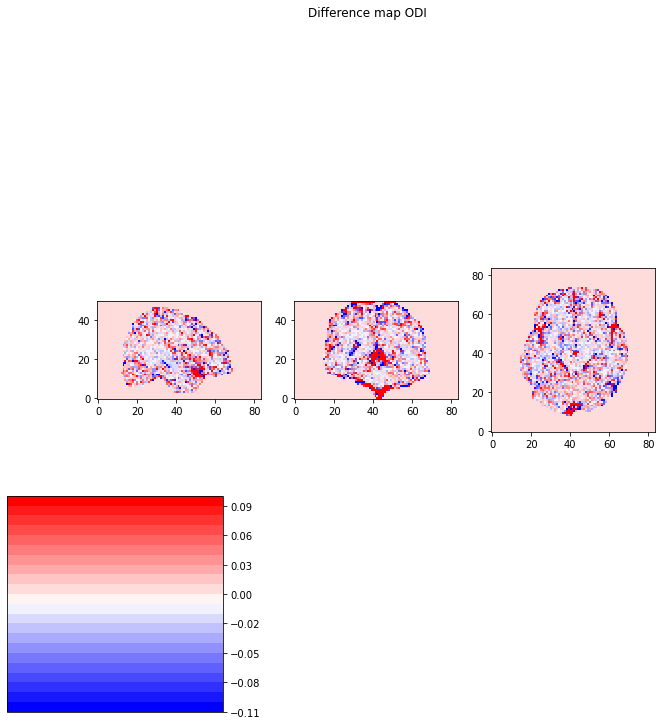

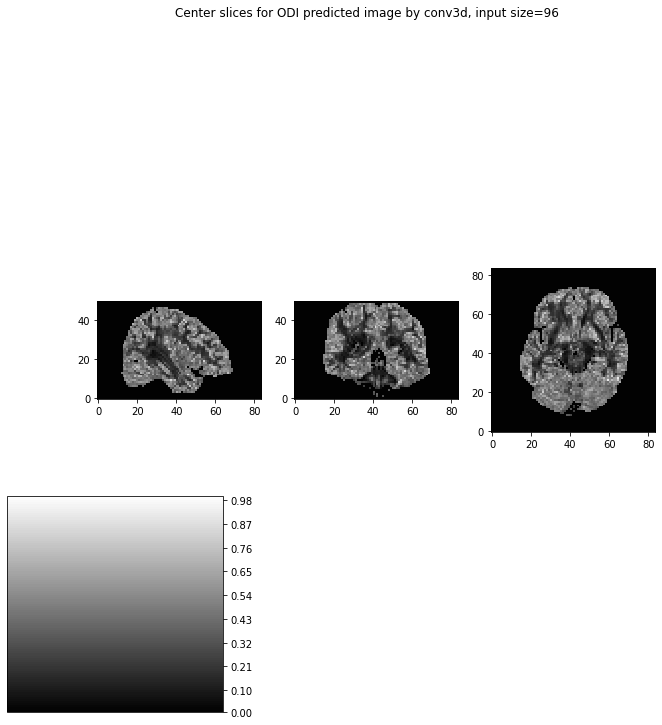

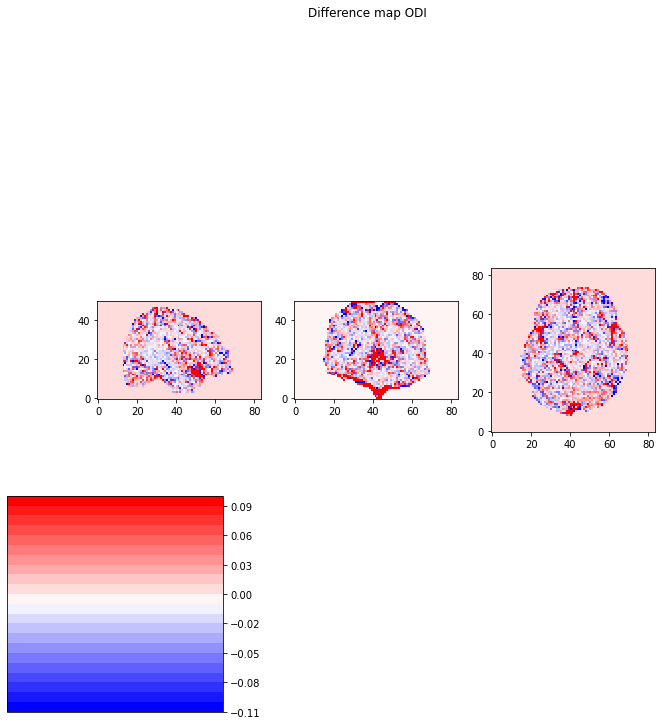

In [66]:
# load the reference img and pred img
visualise0(s02_ODI_img_data)
visualise2(s02_ODI_img_data, 96, 's02_still', 'fc1d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv2d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv3d',layer, s02_ODI_affine)

<strong>4 layer</strong>

In [70]:
layer = 4

ANN

96
Model: "functional_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_54 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_55 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_56 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_57 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_54 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)           

2022-04-08 03:30:06.878542: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:30:06.878706: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:30:07.208493: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:30:07.229953: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:30:07.230249: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:30:07.231454: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_30_07
2022-04-08 03:30:07.231973: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_30_07/vw.trace.json.gz
2022-04-08 03:30:07.232048: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:30:07.232956: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

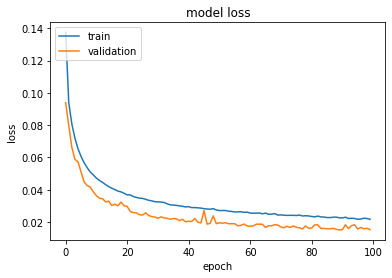

96-fc1d-patch_1-base_1-layer_4-label_ODIsynthetic
(84, 50, 96)
Model: "functional_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_58 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_59 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_60 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_61 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_55 (Dropout)         (None, 150)               0         
_______________________________________________________

In [68]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_62 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 1, 1, 1)     

2022-04-09 20:19:17.180336: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:19:17.180464: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:19:17.723067: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:19:17.747609: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:19:17.747895: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:19:17.749239: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_19_17
2022-04-09 20:19:17.749781: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_19_17/vw.trace.json.gz
2022-04-09 20:19:17.749880: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:19:17.750952: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

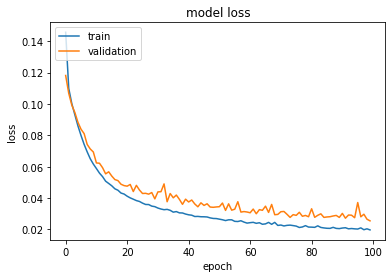

96-conv2d-patch_3-base_1-layer_4-label_ODIsynthetic
(84, 84, 96)
Model: "functional_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_63 (Dropout)         (None, 82, 82, 150)       0         
_____________________________________________________

In [72]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_103 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_66 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 1, 1, 1, 1)  

2022-04-09 20:23:52.764788: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:23:52.764945: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:23:53.481178: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:23:53.503626: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:23:53.503897: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:23:53.509778: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_23_53
2022-04-09 20:23:53.510320: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_23_53/vw.trace.json.gz
2022-04-09 20:23:53.510391: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:23:53.511388: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

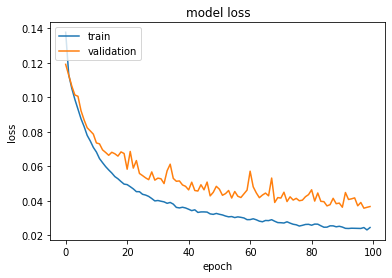

96-conv3d-patch_3-base_1-layer_4-label_ODIsynthetic
(84, 84, 50)
Model: "functional_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_108 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_109 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_110 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_67 (Dropout)         (None, 82, 82, 48, 150)   0         
_____________________________________________________

In [74]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9319150419206617
3
conv2d
96input size the ssim score for odi is: 0.9316886813824343
3
conv3d
96input size the ssim score for odi is: 0.9305717745726764


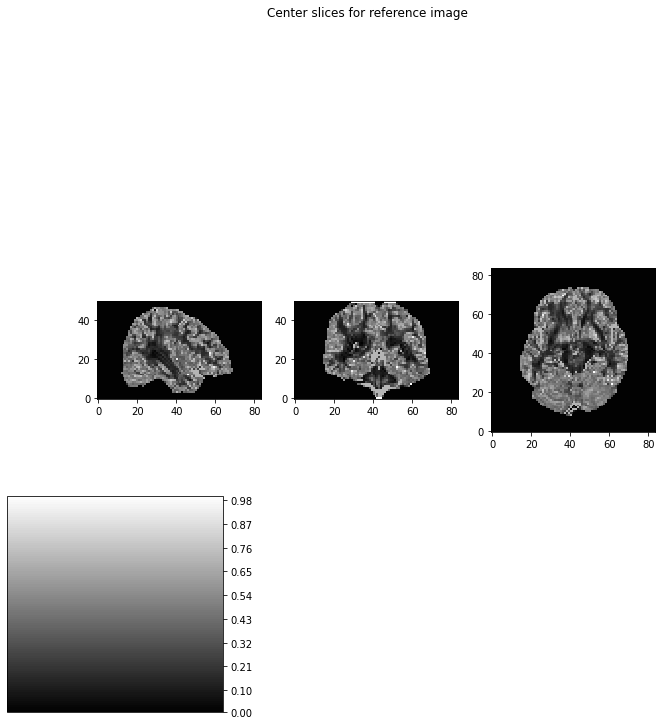

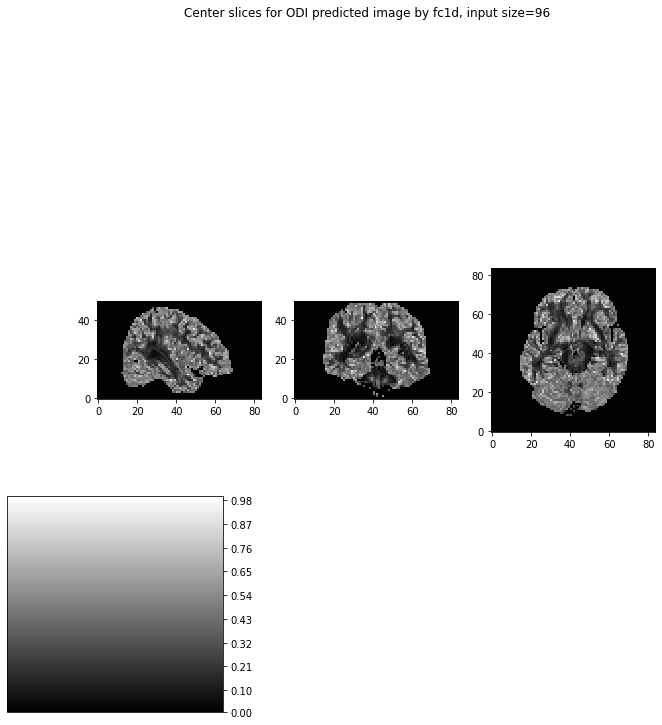

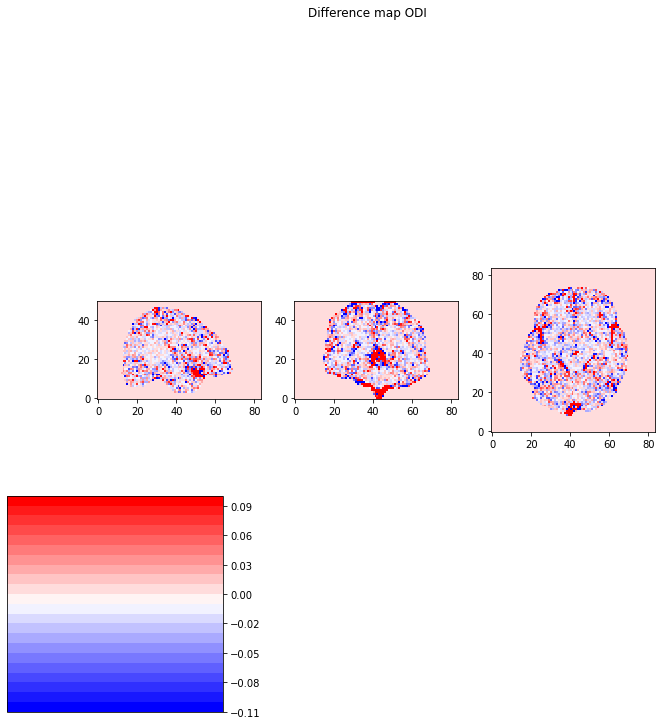

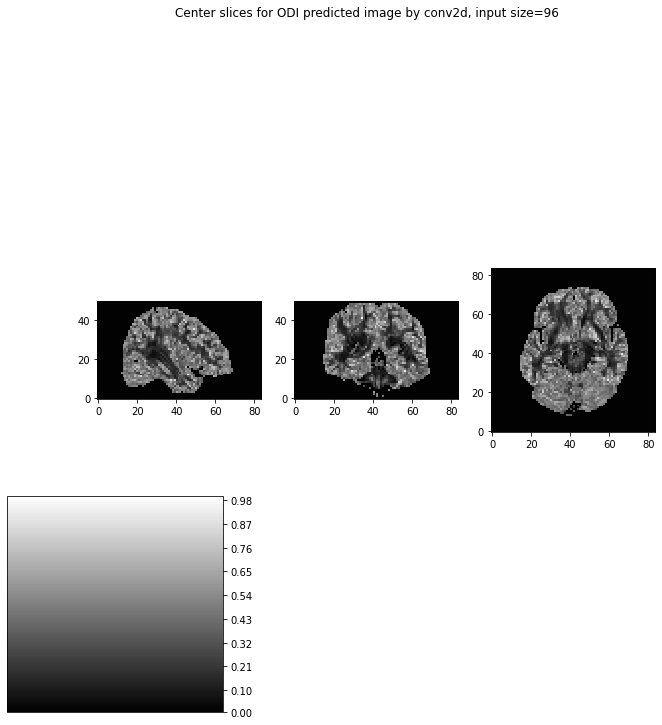

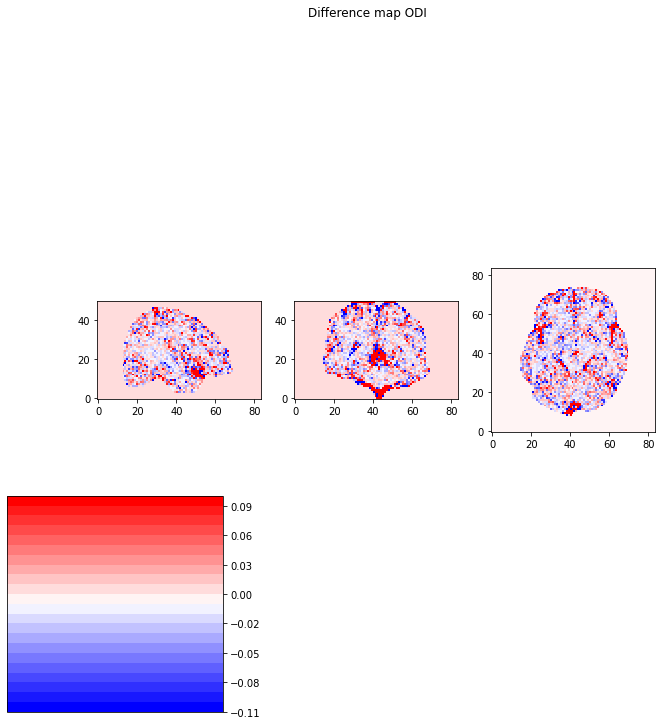

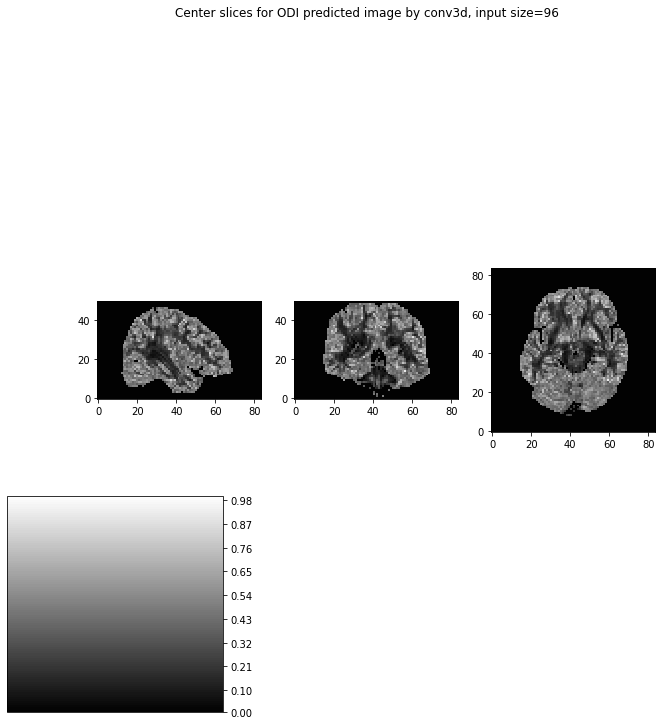

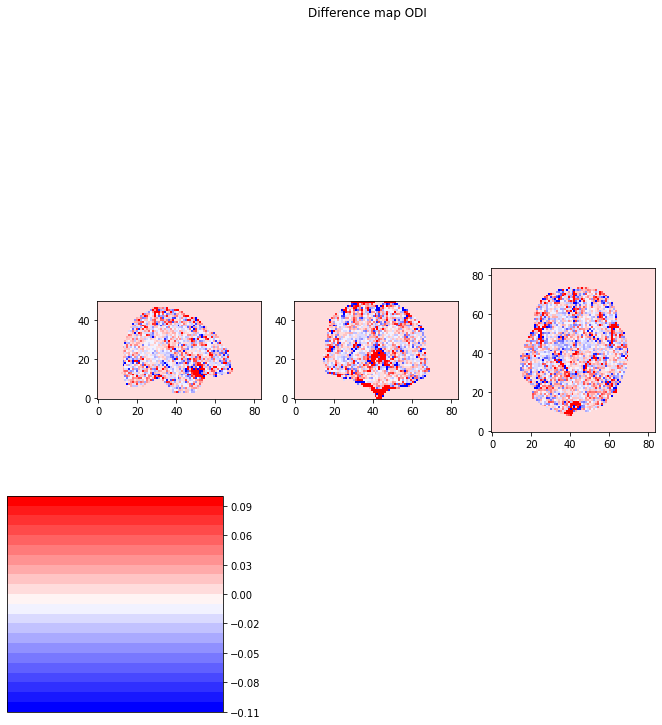

In [75]:
# load the reference img and pred img
visualise0(s02_ODI_img_data)
visualise2(s02_ODI_img_data, 96, 's02_still', 'fc1d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv2d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv3d',layer, s02_ODI_affine)

<strong>5 layer</strong>

In [76]:
layer = 5

<strong>ANN</strong>

96
Model: "functional_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_50 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_51 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_52 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_53 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_54 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_68 (Dropout)         (None, 150)         

2022-04-09 20:27:26.286540: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:27:26.286623: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:27:26.670231: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:27:26.694780: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:27:26.695122: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:27:26.696494: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_27_26
2022-04-09 20:27:26.697053: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_27_26/vw.trace.json.gz
2022-04-09 20:27:26.697127: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:27:26.698465: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

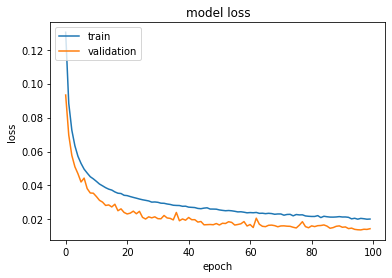

96-fc1d-patch_1-base_1-layer_5-label_ODIsynthetic
(84, 50, 96)
Model: "functional_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_55 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_56 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_57 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_58 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_59 (Dense)             (None, 150)               22650     
_______________________________________________________

In [77]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

<strong>2D CNN</strong>

96
Model: "functional_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_62 (Dropout)         (None, 1, 1, 150)   

2022-04-08 03:36:03.160080: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:36:03.160237: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:36:03.705343: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:36:03.731939: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:36:03.732238: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:36:03.733568: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_36_03
2022-04-08 03:36:03.734150: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_36_03/vw.trace.json.gz
2022-04-08 03:36:03.734233: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:36:03.735231: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

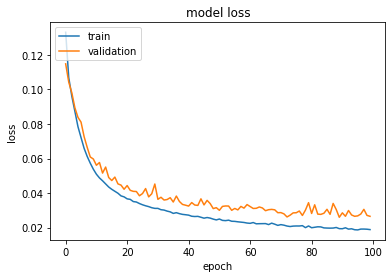

96-conv2d-patch_3-base_1-layer_5-label_ODIsynthetic
(84, 84, 96)
Model: "functional_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 82, 82, 150)       22650     
_____________________________________________________

In [74]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

<strong>3D CNN</strong>

96
Model: "functional_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_82 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_83 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_84 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_85 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_64 (Dropout)         (None, 1, 1, 1, 150)

2022-04-08 03:37:48.884086: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:37:48.884167: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:37:49.626138: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:37:49.650227: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:37:49.650507: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:37:49.651723: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_37_49
2022-04-08 03:37:49.652288: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_37_49/vw.trace.json.gz
2022-04-08 03:37:49.652363: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:37:49.653296: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

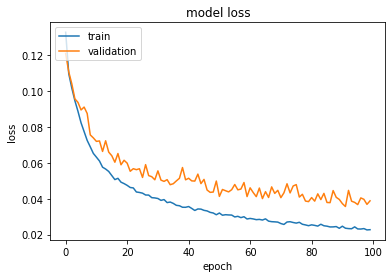

96-conv3d-patch_3-base_1-layer_5-label_ODIsynthetic
(84, 84, 50)
Model: "functional_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_88 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_89 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_91 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_92 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [75]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9318298971397202
3
conv2d
96input size the ssim score for odi is: 0.9307730819806819
3
conv3d
96input size the ssim score for odi is: 0.9303801663421978


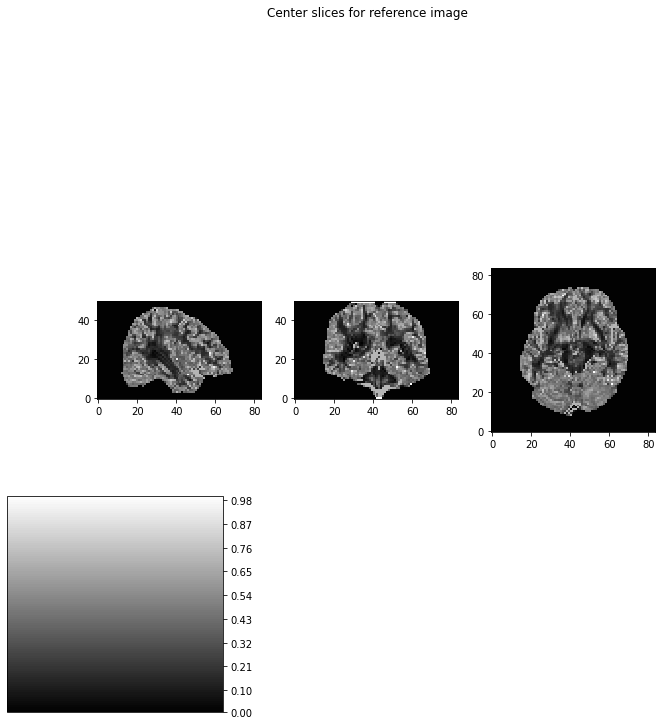

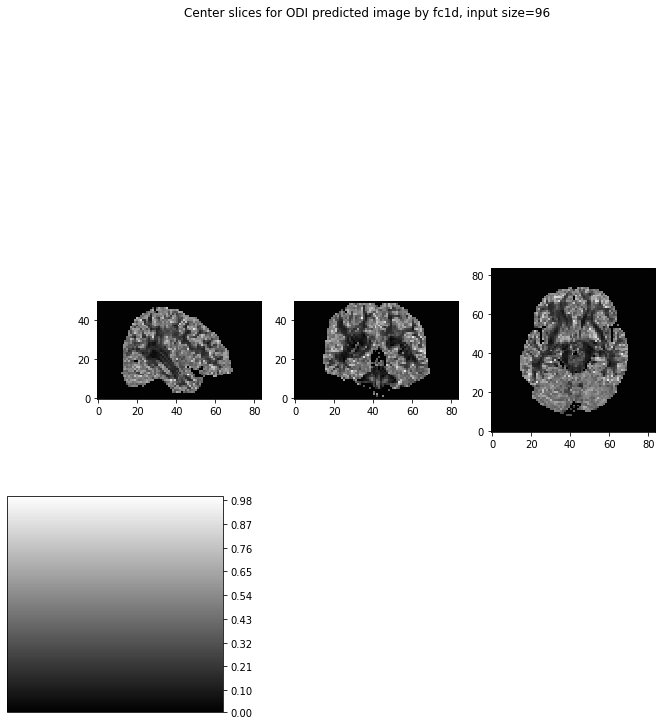

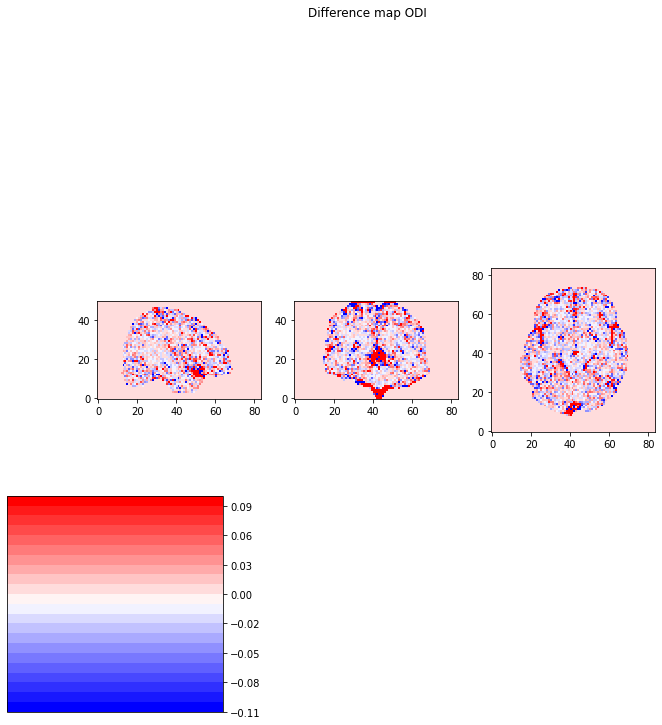

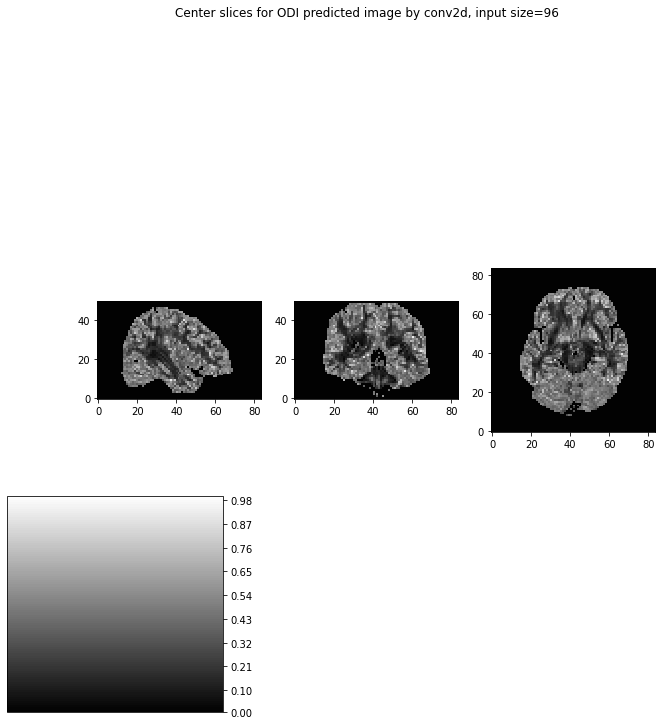

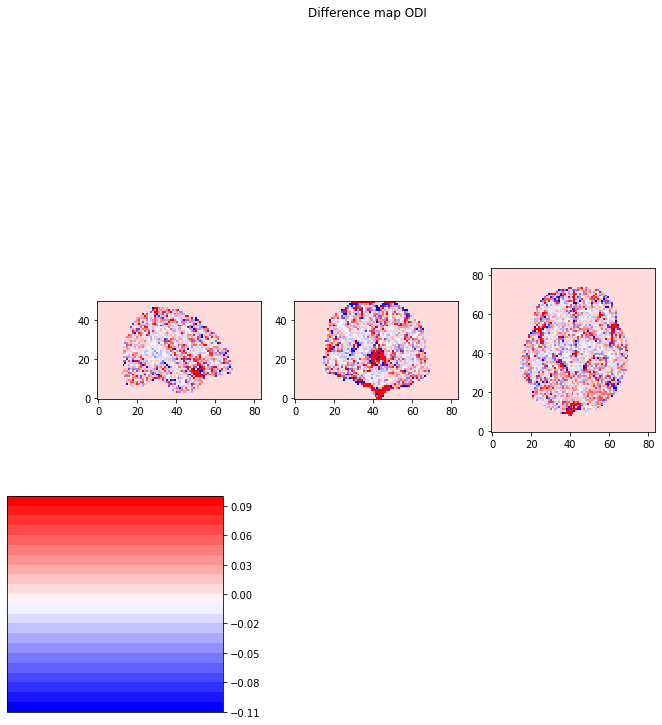

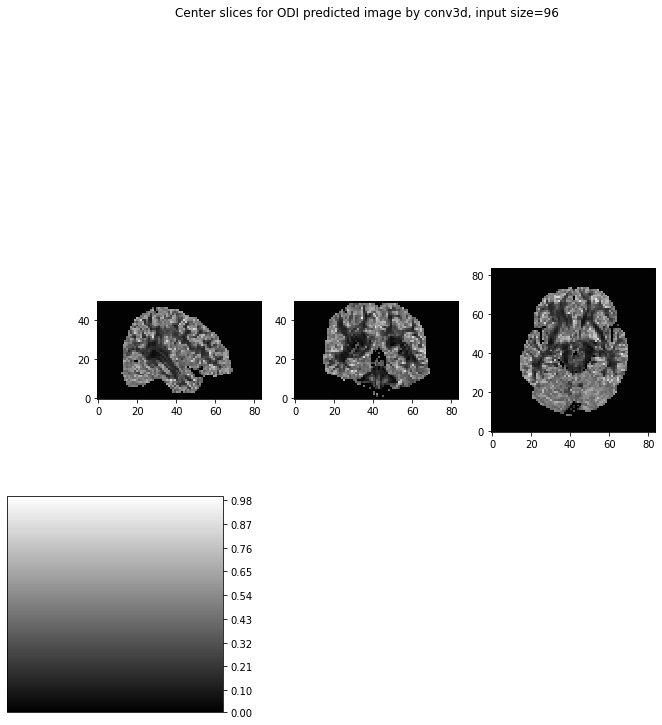

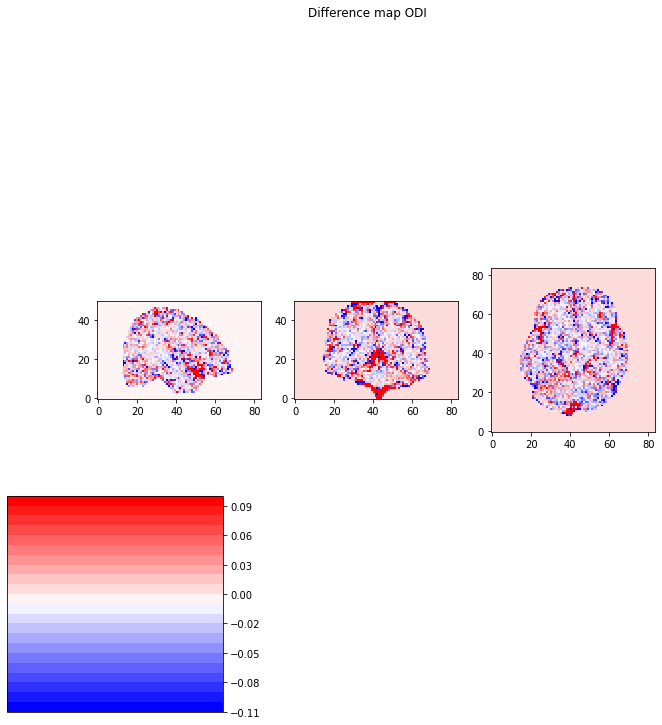

In [76]:
# load the reference img and pred img
visualise0(s02_ODI_img_data)
visualise2(s02_ODI_img_data, 96, 's02_still', 'fc1d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv2d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv3d',layer, s02_ODI_affine)

<strong>6 layer</strong>

In [81]:
layer = 6

ANN

96
Model: "functional_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_96 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_97 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_98 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_99 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_100 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_101 (Dense)            (None, 150)         

2022-04-09 20:33:17.318016: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:33:17.318153: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:33:17.679250: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:33:17.705313: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:33:17.705607: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:33:17.707004: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_33_17
2022-04-09 20:33:17.707589: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_33_17/vw.trace.json.gz
2022-04-09 20:33:17.707707: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:33:17.708776: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

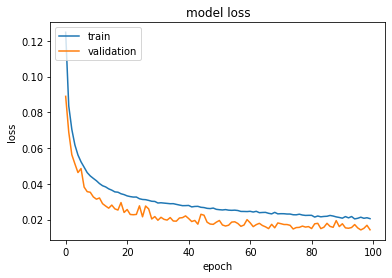

96-fc1d-patch_1-base_1-layer_6-label_ODIsynthetic
(84, 50, 96)
Model: "functional_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_102 (Dense)            (None, 150)               14550     
_________________________________________________________________
dense_103 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_104 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_105 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_106 (Dense)            (None, 150)               22650     
_______________________________________________________

In [84]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 1, 1, 150)   

2022-04-08 03:41:44.714252: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:41:44.714371: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:41:45.283920: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:41:45.313516: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:41:45.313842: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:41:45.315247: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_41_45
2022-04-08 03:41:45.315851: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_41_45/vw.trace.json.gz
2022-04-08 03:41:45.315951: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:41:45.316897: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

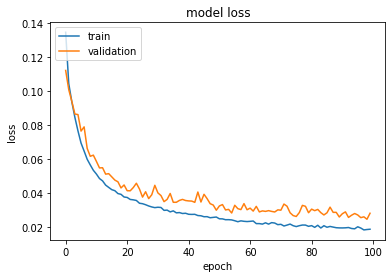

96-conv2d-patch_3-base_1-layer_6-label_ODIsynthetic
(84, 84, 96)
Model: "functional_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 82, 82, 150)       22650     
_____________________________________________________

In [79]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_94 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_95 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_99 (Conv3D)           (None, 1, 1, 1, 150)

2022-04-08 03:43:46.195649: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:43:46.195774: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:43:47.147987: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:43:47.182890: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:43:47.183262: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:43:47.184653: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_43_47
2022-04-08 03:43:47.185278: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_43_47/vw.trace.json.gz
2022-04-08 03:43:47.185359: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:43:47.186412: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

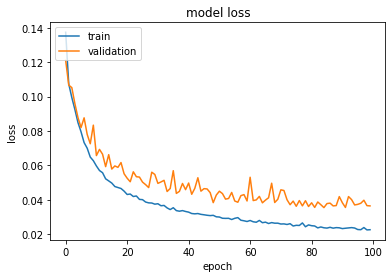

96-conv3d-patch_3-base_1-layer_6-label_ODIsynthetic
(84, 84, 50)
Model: "functional_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_101 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_103 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [80]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9317524803097471
3
conv2d
96input size the ssim score for odi is: 0.9307351119381134
3
conv3d
96input size the ssim score for odi is: 0.9296782631392407


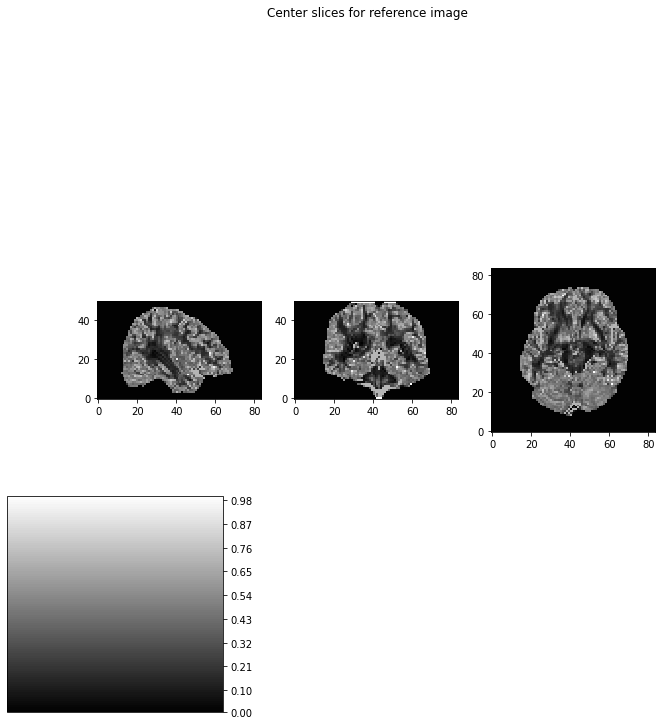

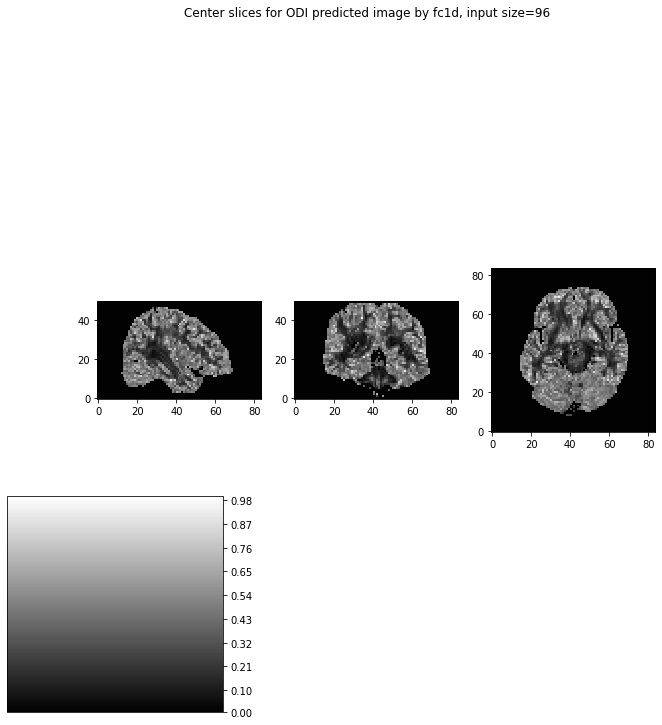

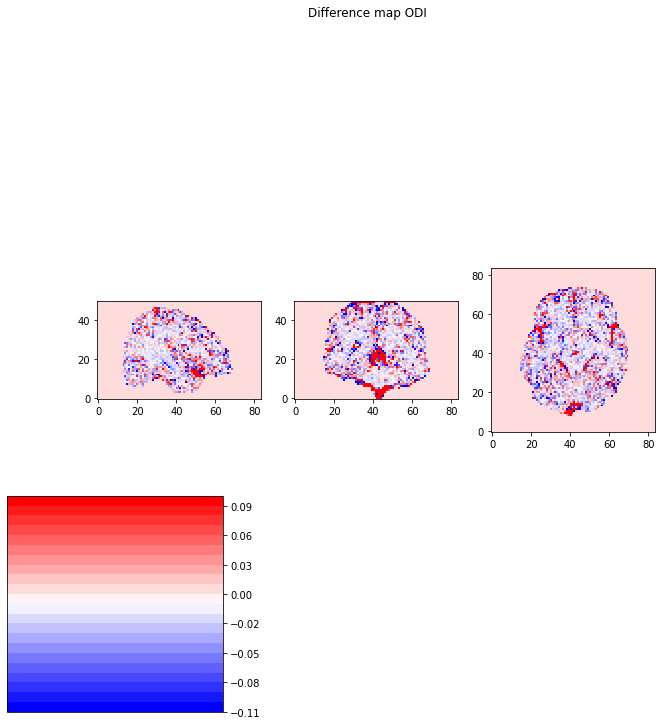

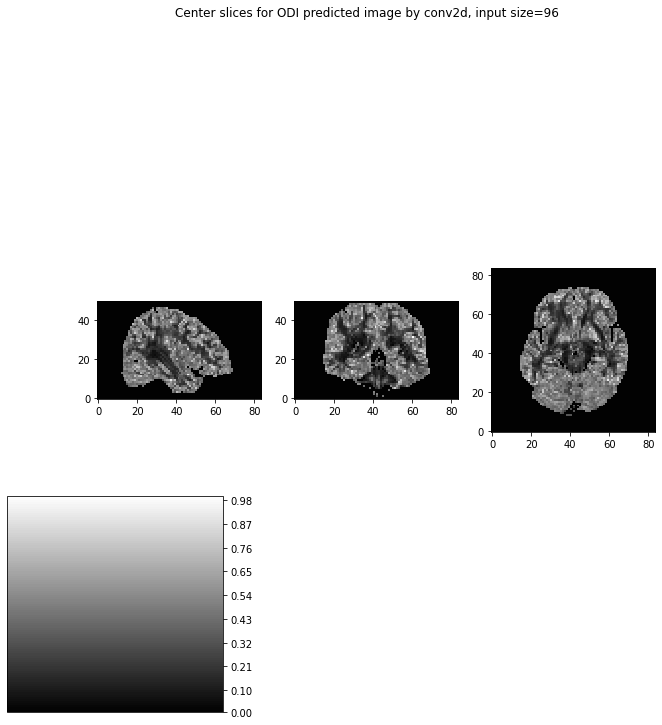

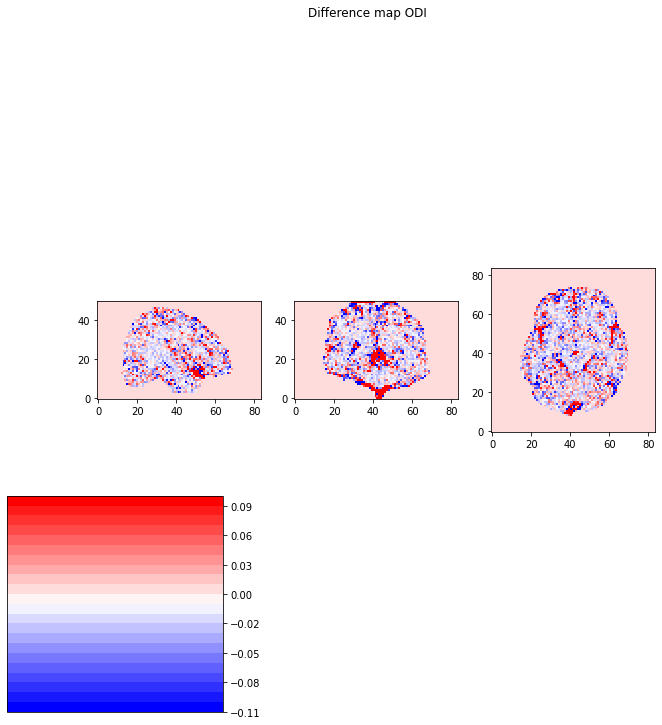

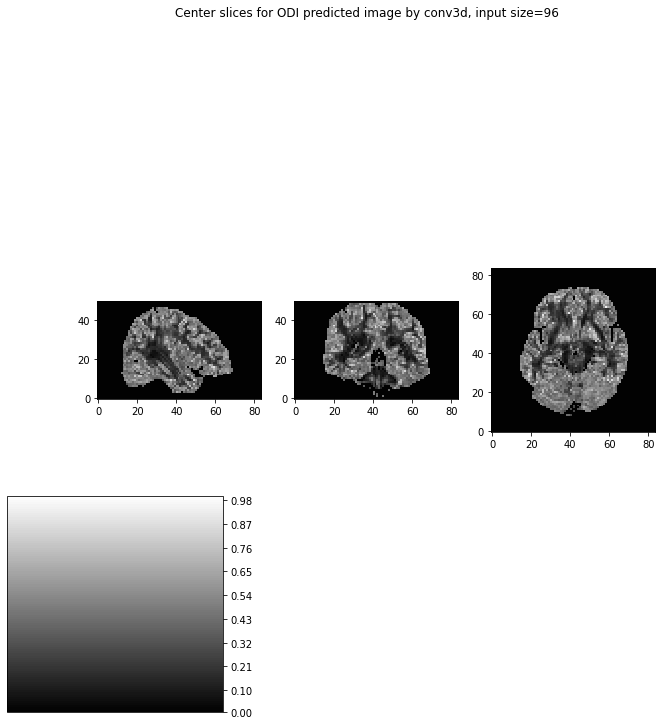

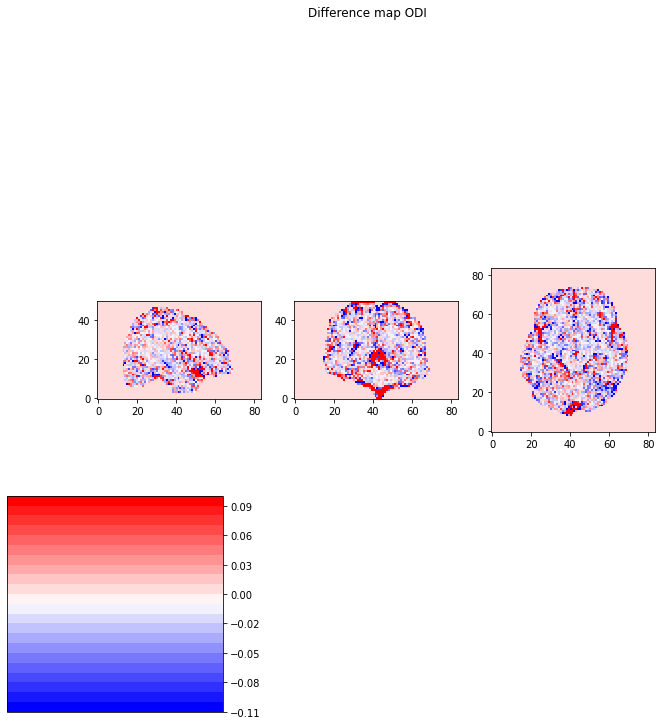

In [85]:
# load the reference img and pred img
visualise0(s02_ODI_img_data)
visualise2(s02_ODI_img_data, 96, 's02_still', 'fc1d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv2d',layer, s02_ODI_affine)
visualise2(s02_ODI_img_data, 96, 's02_still', 'conv3d',layer, s02_ODI_affine)

<strong>FWF</strong>

In [82]:
# Generate the dataset for ANNc
cmd = "--subjects s01_still s02_still --fc1d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (81882, 96) the ratio of masked voxel is: 0.23209183673469388
training dataset has shape:(81882, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (81882, 1) the ratio of masked voxel is: 0.23209183673469388
training label has shape:(81882, 1)
Generating for s02_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (91401, 96) the ratio of masked voxel is: 0.2590731292517007
training dataset has shape:(91401, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (91401, 1) the ratio of masked voxel is: 0.2590731292517007
training label has shape:(91401, 1)


In [83]:
# Generate the dataset for 2D CNN
cmd = "--subjects s01_still s02_still --conv2d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(81634, 3, 3, 96)
saved patches has shape: (81634, 3, 3, 96)
(81634, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(90846, 3, 3, 96)
saved patches has shape: (90846, 3, 3, 96)
(90846, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1)


In [84]:
# Generate the dataset for 3D CNN
cmd = "--subjects s01_still s02_still --conv3d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(81634, 3, 3, 3, 96)
saved patches has shape: (81634, 2592)
(82, 82, 48, 1) (82, 82, 48)
(81634, 1, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(90846, 3, 3, 3, 96)
saved patches has shape: (90846, 2592)
(82, 82, 48, 1) (82, 82, 48)
(90846, 1, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1, 1)


<strong>1 layer</strong>

In [86]:
layer = 1

ANN

96
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense (Dense)                (None, 150)               14550     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu (ReLU)                 (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
['F']


2022-04-08 16:52:13.068281: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-08 16:52:13.098068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 16:52:13.098168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2022-04-08 16:52:13.098187: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-08 16:52:13.114823: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-08 16:52:13.136470: I tensorflow/stream_executor/pl

The remained data has shape: (81882, 96)
(81882, 96)
(81882, 150)
(81882, 150)
(81882, 1)
(81882, 1)
Training start ...


2022-04-08 16:52:13.526441: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 16:52:13.526479: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2022-04-08 16:52:13.530590: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2022-04-08 16:52:13.532852: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2022-04-08 16:52:13.778204: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 16:52:13.780977: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 16:52:13.782056: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 16:52:13.783764: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_16_52_13
2022-04-08 16:52:13.784184: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_16_52_13/vw.trace.json.gz
2022-04-08 16:52:13.784247: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 16:52:13.786175: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

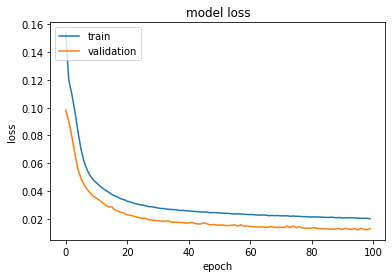

96-fc1d-patch_1-base_1-layer_1-label_FWFsynthetic
(84, 50, 96)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               14550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has s

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


In [14]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 1, 1, 150)         129750    
_________________________________________________________________
dropout_78 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_78 (ReLU)              (None, 1, 1, 1)           0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
['F']
The remained data has shape: (81634, 3, 3, 96)
(81634, 3, 3, 96)
(81634, 1, 1, 150)
(81634, 1, 1, 150)


2022-04-09 20:37:10.339709: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:37:10.339860: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:37:10.889198: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:37:10.919664: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:37:10.919945: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:37:10.921216: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_37_10
2022-04-09 20:37:10.921653: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_37_10/vw.trace.json.gz
2022-04-09 20:37:10.921715: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:37:10.922629: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

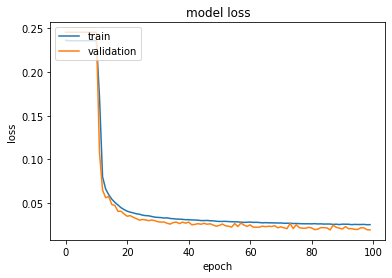

96-conv2d-patch_3-base_1-layer_1-label_FWFsynthetic
(84, 84, 96)
Model: "functional_237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
dropout_79 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_79 (ReLU)              (None, 82, 82, 1)         0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction

In [87]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_112 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
dropout_80 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_113 (Conv3D)          (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_80 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
['F']
The remained data has shape: (81634, 3, 3, 3, 96)
(81634, 3, 3, 3, 96)
(81634, 1, 1, 1, 150)
(81634, 1,

2022-04-09 20:38:28.854417: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:38:28.854575: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:38:29.559816: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:38:29.577533: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:38:29.577799: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:38:29.582609: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_38_29
2022-04-09 20:38:29.583043: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_38_29/vw.trace.json.gz
2022-04-09 20:38:29.583114: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:38:29.584064: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

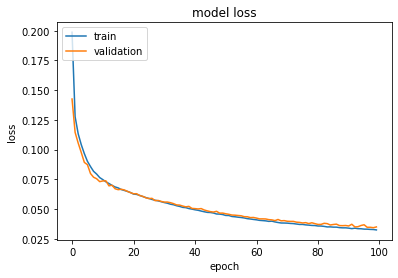

96-conv3d-patch_3-base_1-layer_1-label_FWFsynthetic
(84, 84, 50)
Model: "functional_243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_114 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
dropout_81 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_115 (Conv3D)          (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_81 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
predict

In [88]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F --lr 0.00001'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9353578662860322
3
conv2d
96input size the ssim score for fwf is: 0.9326305188547406
3
conv3d
96input size the ssim score for fwf is: 0.9365167657448618


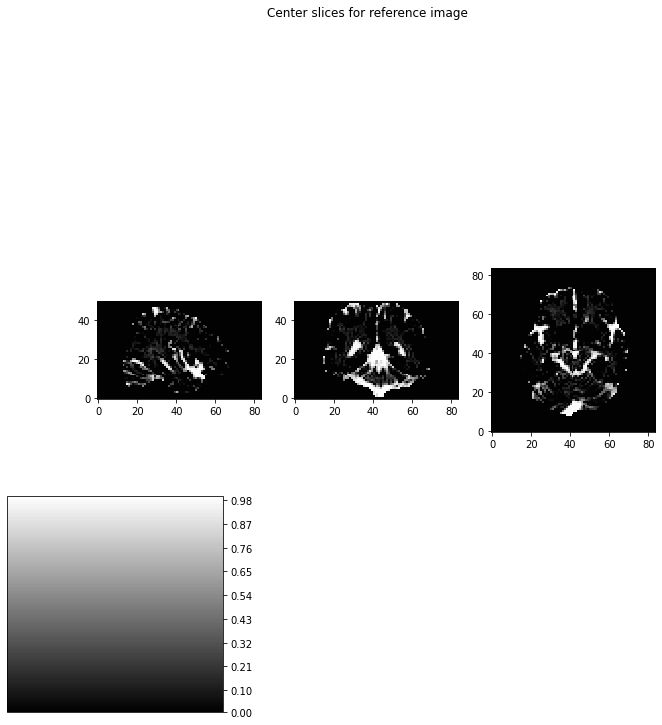

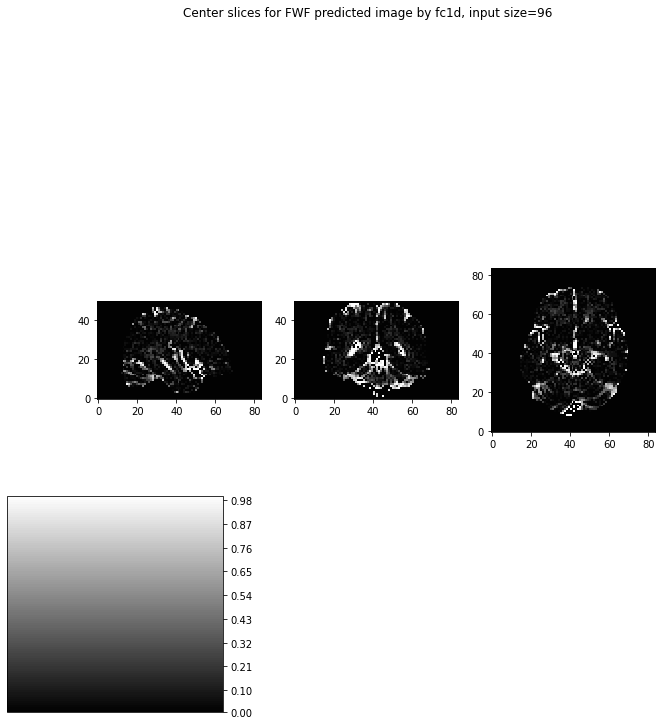

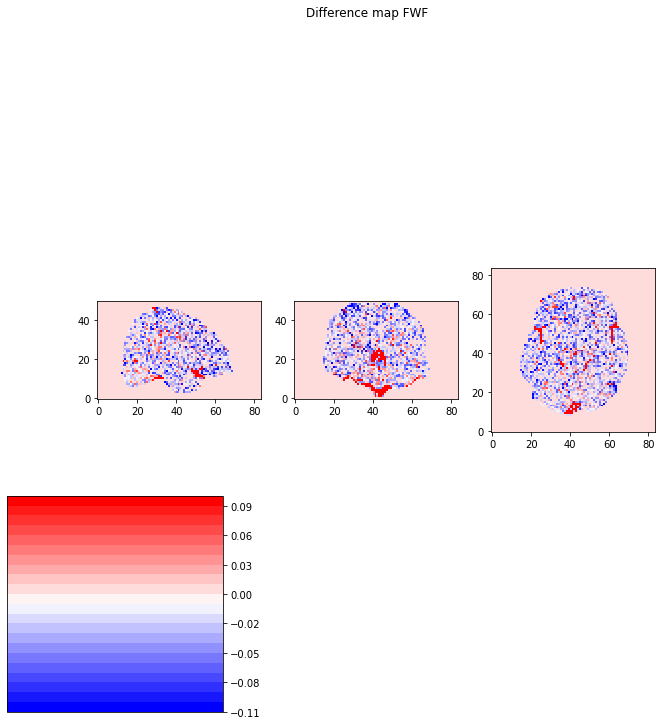

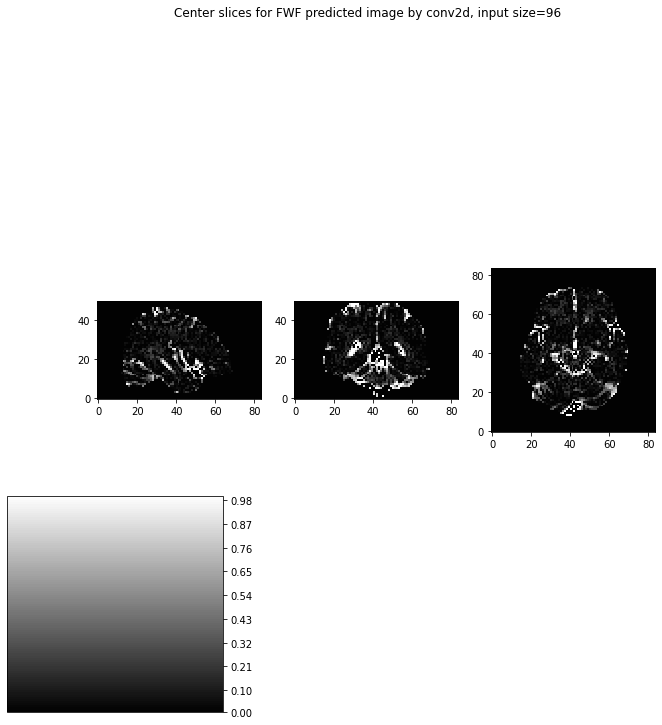

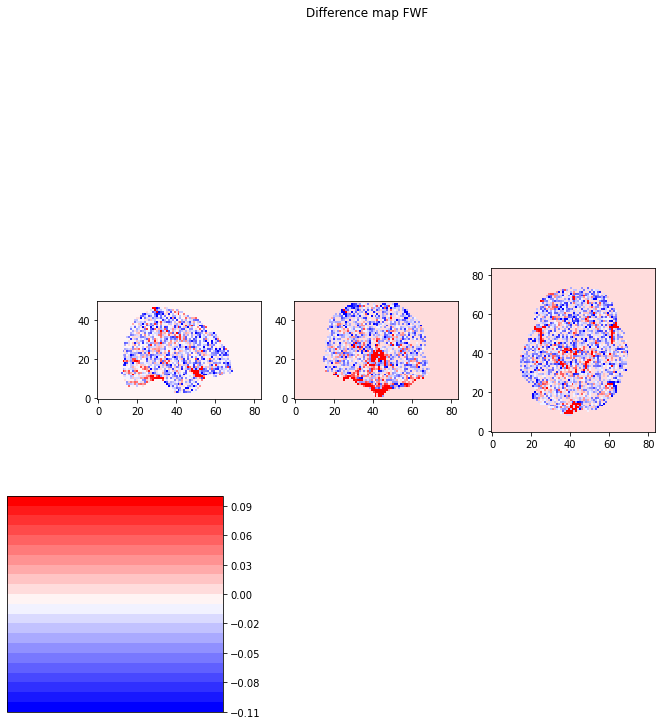

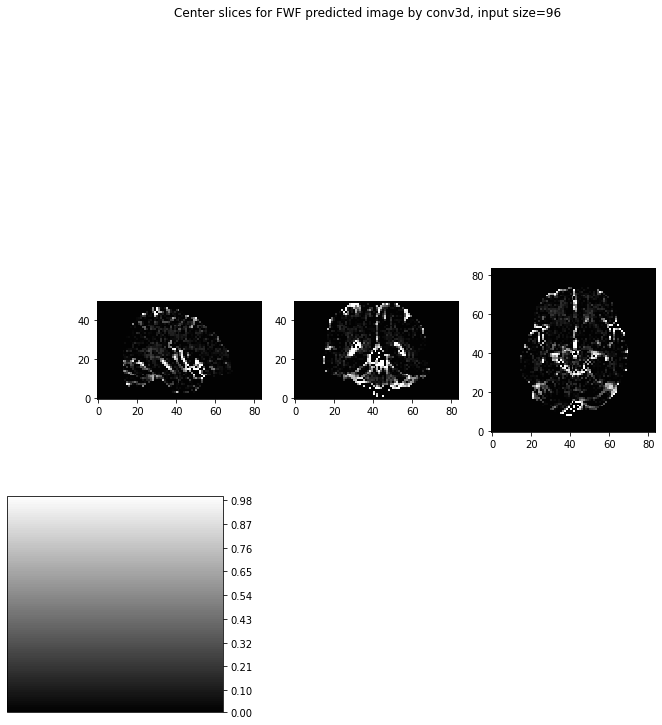

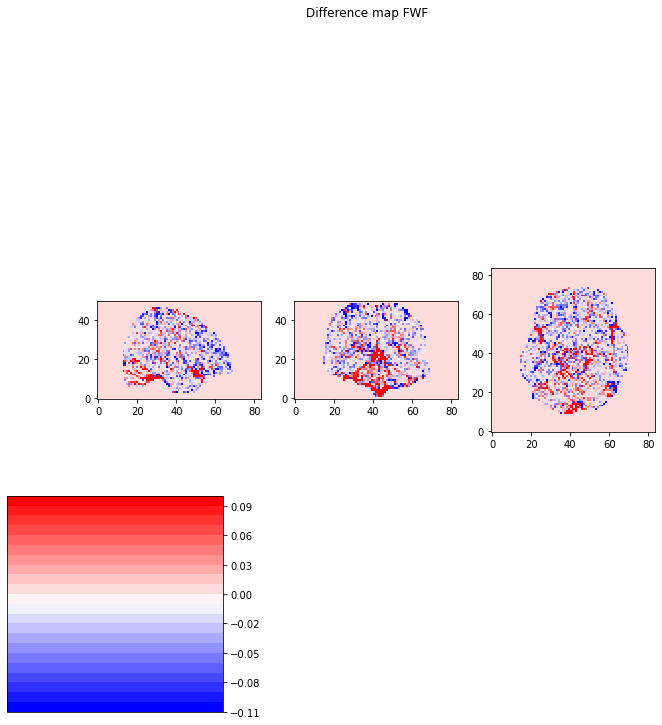

In [89]:
# load the reference img and pred img
visualise0(s02_FWF_img_data)
visualise3(s02_FWF_img_data, 96, 's02_still', 'fc1d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv2d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv3d',layer, s02_FWF_affine)

<strong>2 layer</strong>

In [98]:
layer = 2

ANN

96
Model: "functional_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_86 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_87 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_78 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_78 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
_____________________________________________

2022-04-08 03:49:29.623457: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:49:29.623587: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:49:29.984583: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:49:30.002557: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:49:30.002824: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:49:30.003958: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_49_30
2022-04-08 03:49:30.004403: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_49_30/vw.trace.json.gz
2022-04-08 03:49:30.004466: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:49:30.005300: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

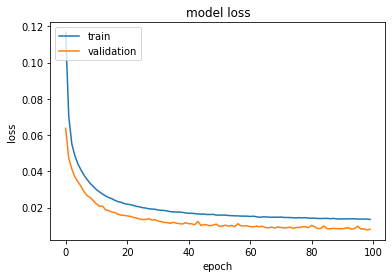

96-fc1d-patch_1-base_1-layer_2-label_FWFsynthetic
(84, 50, 96)
Model: "functional_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_88 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_89 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_79 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_79 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-train

In [91]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_82 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_82 (ReLU)              (None, 1, 1, 1)           0         
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
___________________________________________

2022-04-09 20:41:14.320120: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:41:14.320267: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:41:14.886999: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:41:14.905818: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:41:14.906096: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:41:14.907416: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_41_14
2022-04-09 20:41:14.907865: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_41_14/vw.trace.json.gz
2022-04-09 20:41:14.907929: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:41:14.908835: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

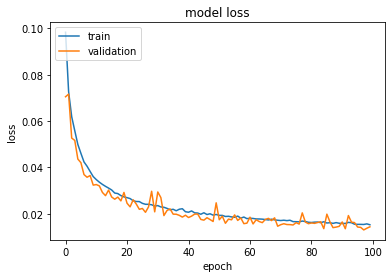

96-conv2d-patch_3-base_1-layer_2-label_FWFsynthetic
(84, 84, 96)
Model: "functional_249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_83 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_83 (ReLU)              (None, 82, 82, 1)         0         
Total params: 152,551
Trainable params: 152,551
Non-t

In [91]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_136 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_137 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_92 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_138 (Conv3D)          (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_92 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
___________________________________________

2022-04-09 20:53:45.362164: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:53:45.362249: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:53:46.106906: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:53:46.126907: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:53:46.127153: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:53:46.132454: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_53_46
2022-04-09 20:53:46.132916: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_53_46/vw.trace.json.gz
2022-04-09 20:53:46.132991: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:53:46.133965: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

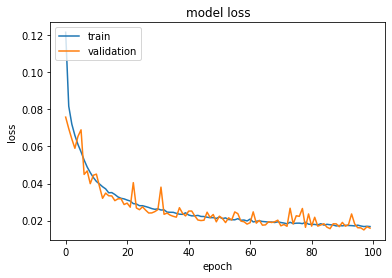

96-conv3d-patch_3-base_1-layer_2-label_FWFsynthetic
(84, 84, 50)
Model: "functional_279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_94 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_139 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_140 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_93 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_141 (Conv3D)          (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_93 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 411,751
Trainable params: 411,751
Non-t

In [100]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9346088316172896
3
conv2d
96input size the ssim score for fwf is: 0.9329331011289922
3
conv3d
96input size the ssim score for fwf is: 0.9308439206154059


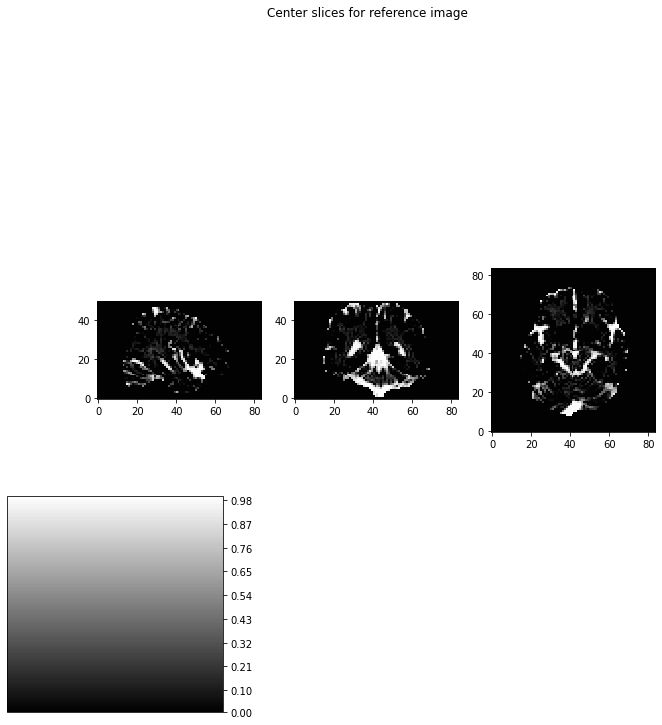

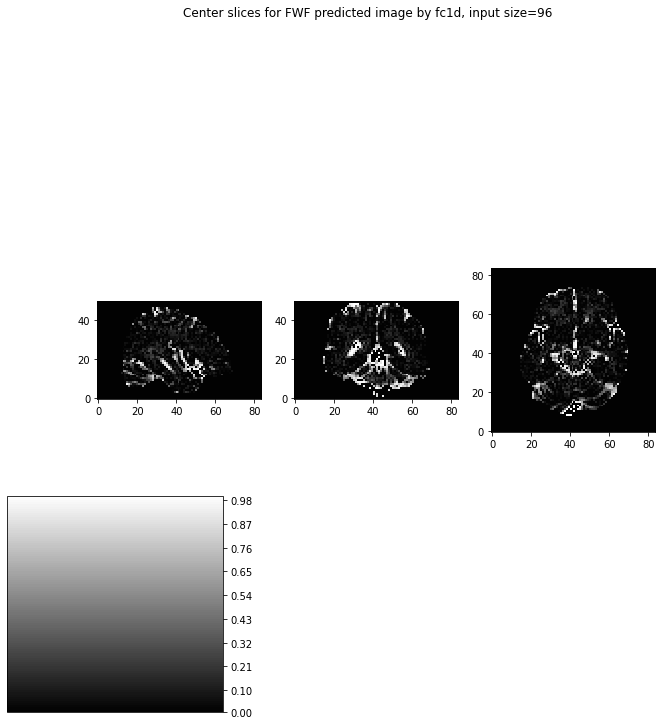

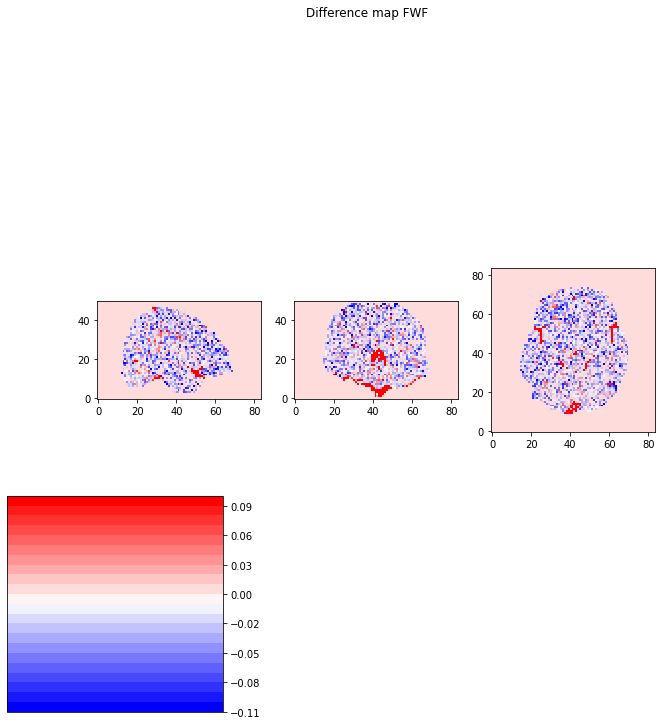

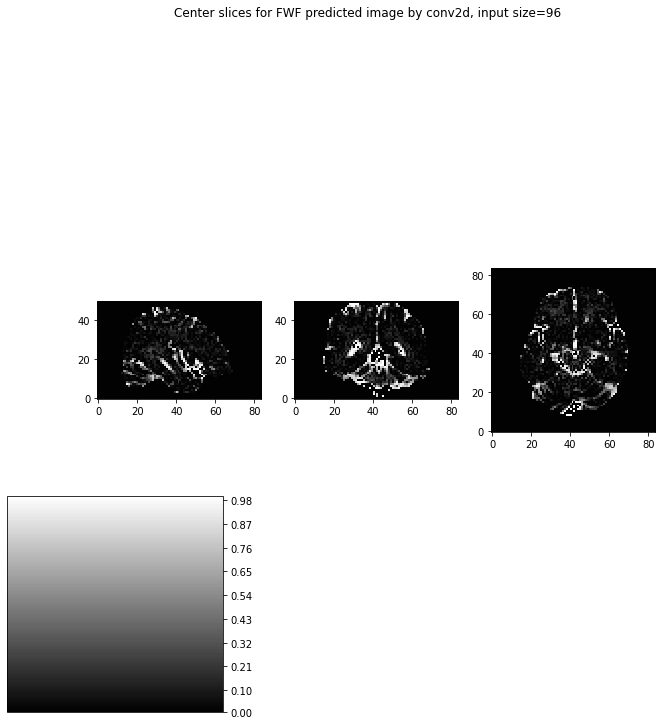

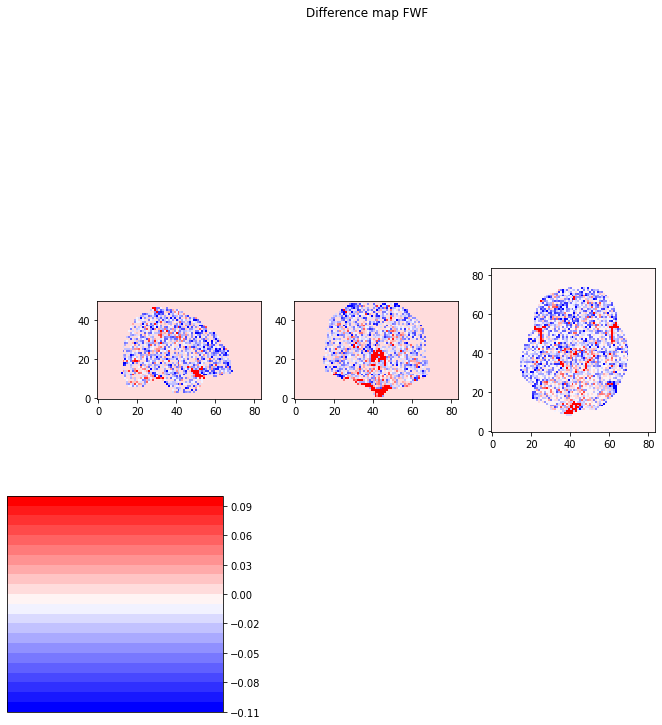

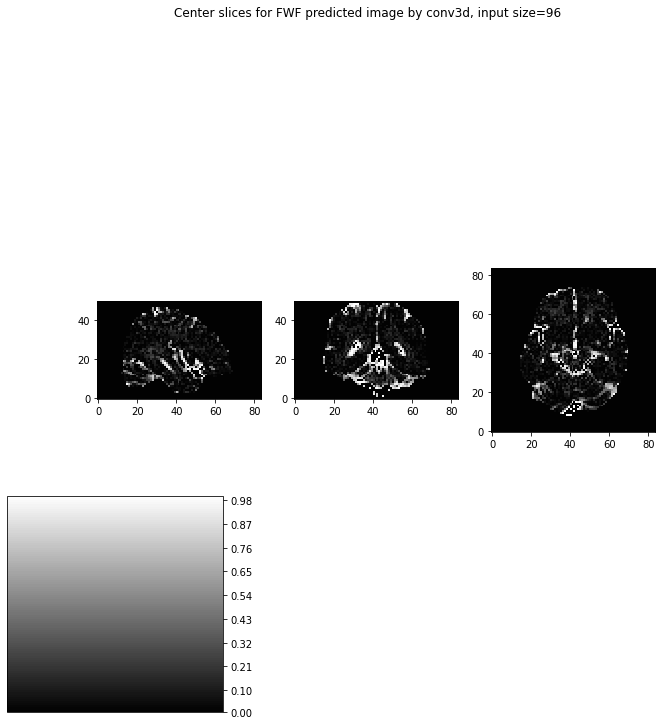

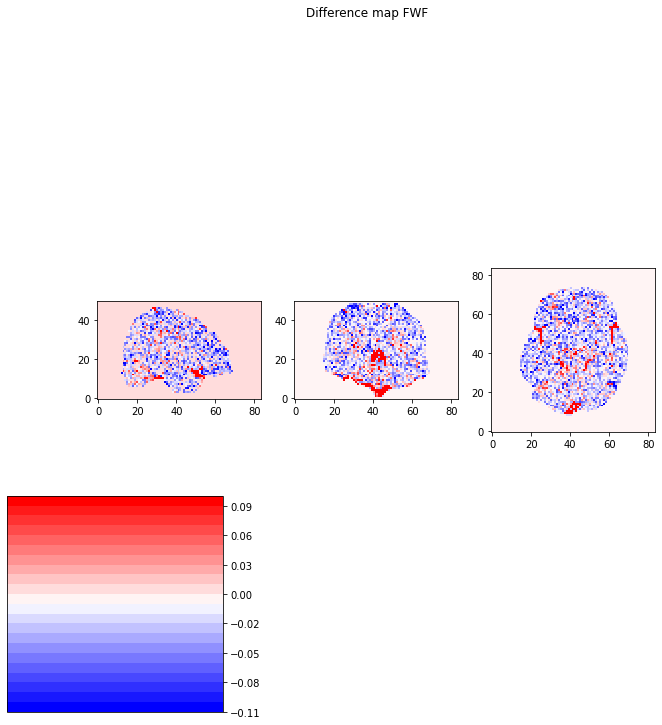

In [101]:
# load the reference img and pred img
visualise0(s02_FWF_img_data)
visualise3(s02_FWF_img_data, 96, 's02_still', 'fc1d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv2d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv3d',layer, s02_FWF_affine)

<strong>3 layer</strong>

In [94]:
layer = 3 

ANN

96
Model: "functional_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_90 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_91 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_92 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_84 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_84 (ReLU)              (None, 1)           

2022-04-08 03:51:56.382175: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:51:56.382324: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:51:56.960482: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:51:56.983736: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:51:56.984050: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:51:56.985398: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_51_56
2022-04-08 03:51:56.985923: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_51_56/vw.trace.json.gz
2022-04-08 03:51:56.986014: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:51:56.986968: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

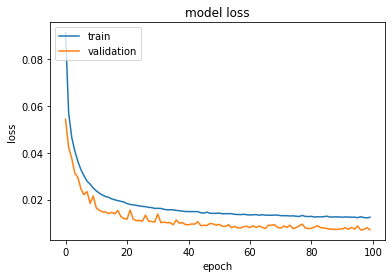

96-fc1d-patch_1-base_1-layer_3-label_FWFsynthetic
(84, 50, 96)
Model: "functional_257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_93 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_94 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_95 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_85 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_______________________________________________________

In [96]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_86 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_86 (ReLU)              (None, 1, 1, 1)     

2022-04-09 20:45:47.092374: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:45:47.092494: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:45:47.651681: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:45:47.671181: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:45:47.671456: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:45:47.672738: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_45_47
2022-04-09 20:45:47.673224: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_45_47/vw.trace.json.gz
2022-04-09 20:45:47.673329: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:45:47.674348: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

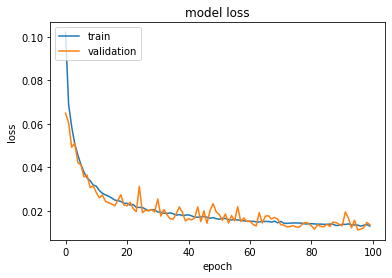

96-conv2d-patch_3-base_1-layer_3-label_FWFsynthetic
(84, 84, 96)
Model: "functional_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_87 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 82, 82, 1)         151       
_____________________________________________________

In [95]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_122 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_123 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_124 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_88 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_125 (Conv3D)          (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_88 (ReLU)              (None, 1, 1, 1, 1)  

2022-04-09 20:47:41.887707: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:47:41.887838: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:47:42.808413: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:47:42.835888: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:47:42.836176: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:47:42.837514: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_47_42
2022-04-09 20:47:42.838026: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_47_42/vw.trace.json.gz
2022-04-09 20:47:42.838105: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:47:42.839114: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

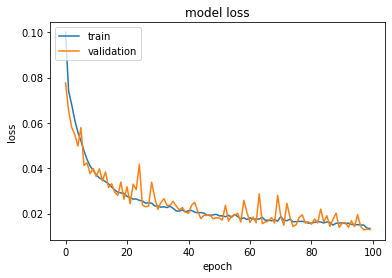

96-conv3d-patch_3-base_1-layer_3-label_FWFsynthetic
(84, 84, 50)
Model: "functional_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_90 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_126 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_127 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_128 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_89 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_129 (Conv3D)          (None, 82, 82, 48, 1)     151       
_____________________________________________________

In [96]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9360646677160613
3
conv2d
96input size the ssim score for fwf is: 0.9314266356236924
3
conv3d
96input size the ssim score for fwf is: 0.9313011474150189


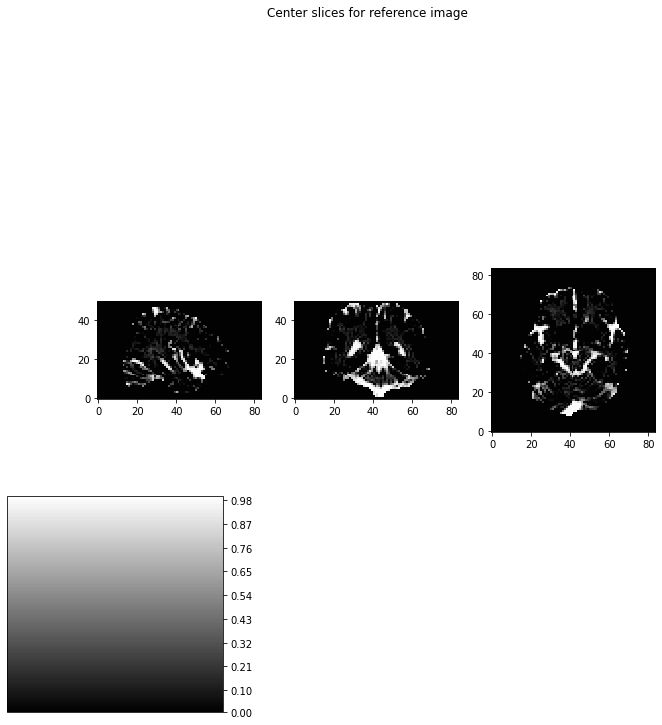

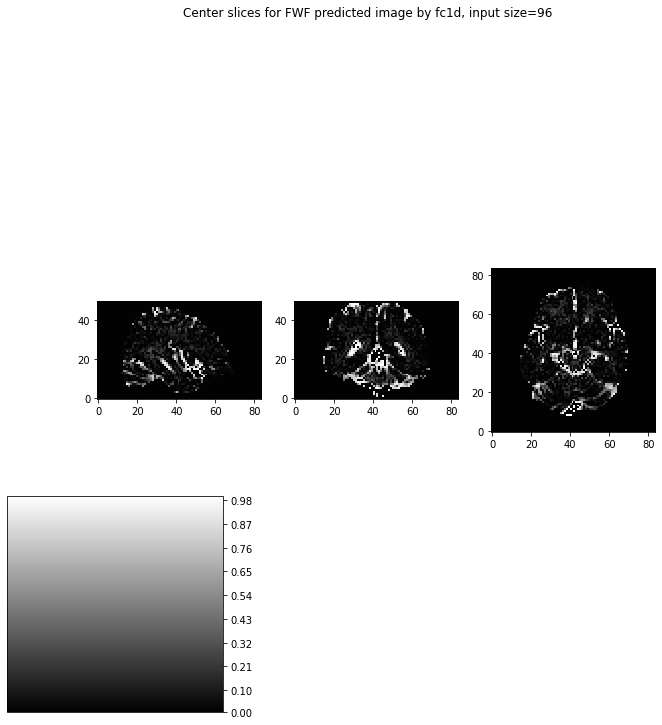

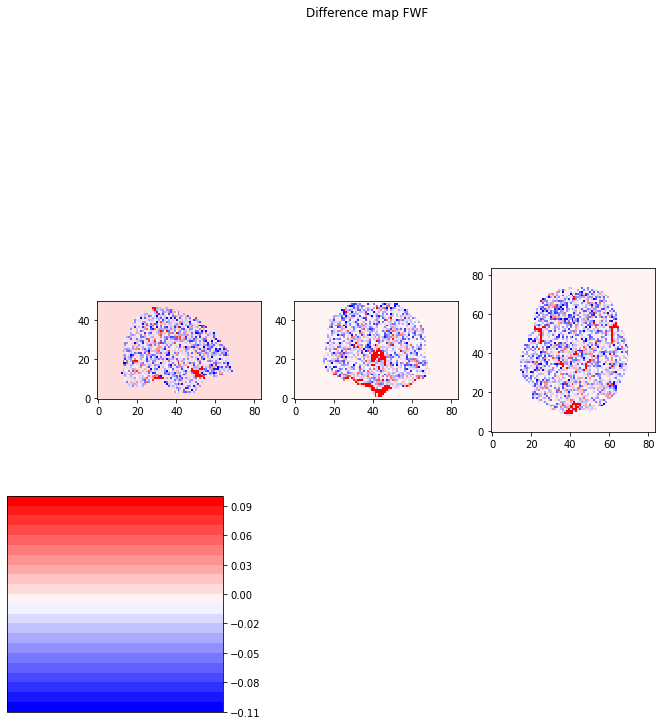

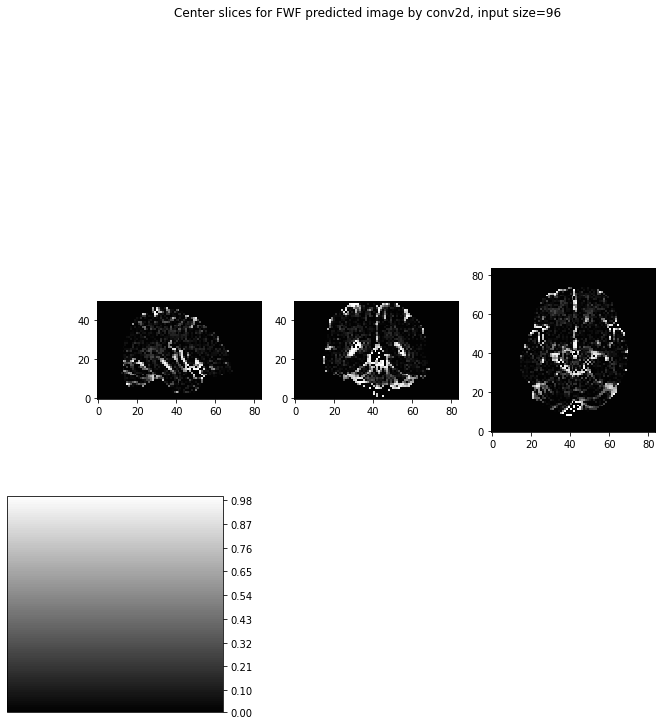

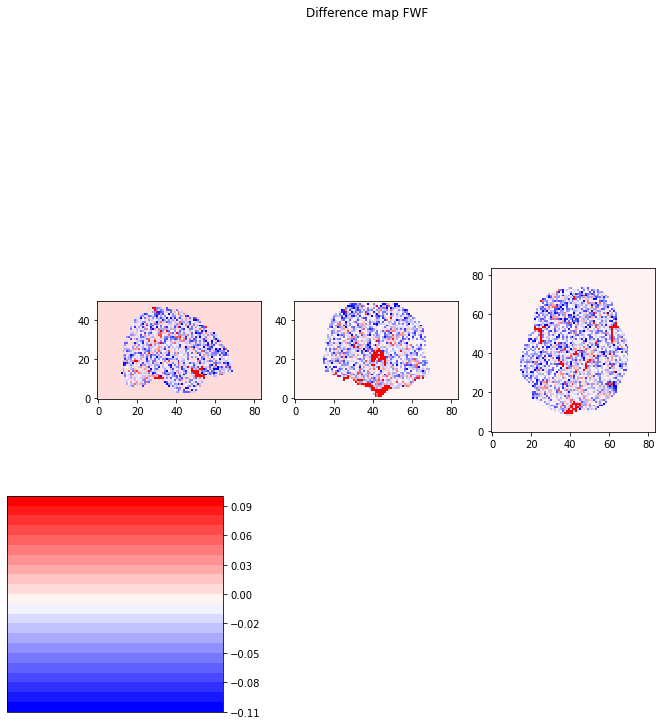

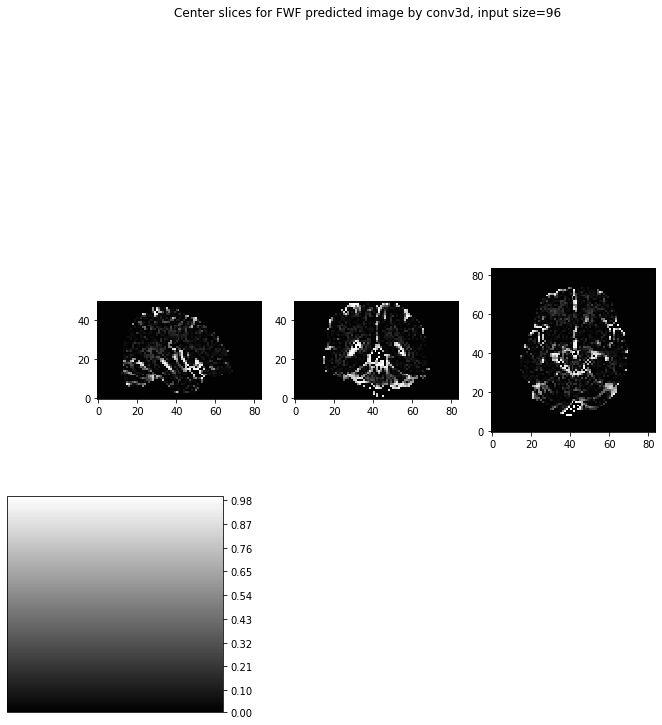

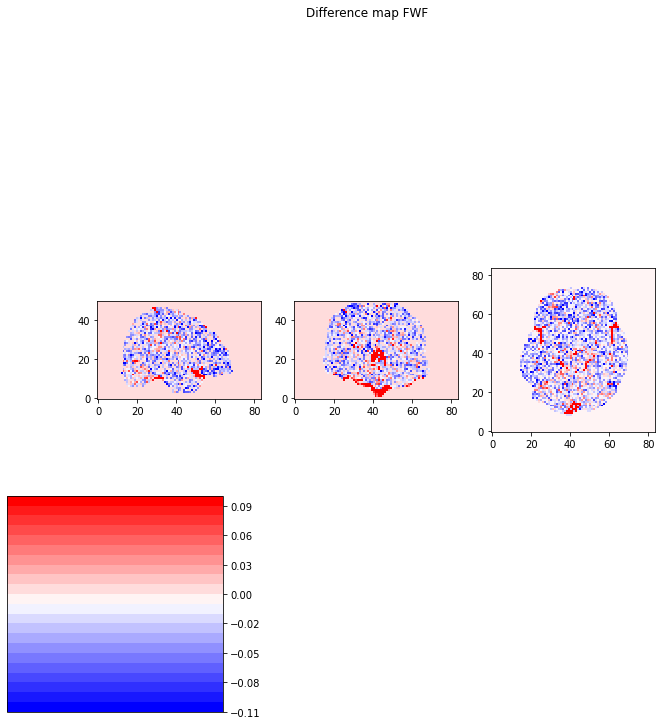

In [97]:
# load the reference img and pred img
visualise0(s02_FWF_img_data)
visualise3(s02_FWF_img_data, 96, 's02_still', 'fc1d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv2d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv3d',layer, s02_FWF_affine)

<strong>4 layer</strong>

In [102]:
layer = 4

ANN

96
Model: "functional_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_96 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_97 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_98 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_99 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_90 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)           

2022-04-08 03:56:35.395519: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:56:35.395657: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 03:56:35.810416: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 03:56:35.832998: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 03:56:35.833312: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 03:56:35.834716: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_03_56_35
2022-04-08 03:56:35.835261: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_03_56_35/vw.trace.json.gz
2022-04-08 03:56:35.835337: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 03:56:35.836299: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

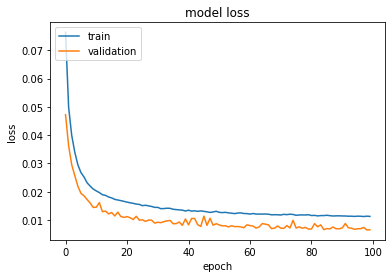

96-fc1d-patch_1-base_1-layer_4-label_FWFsynthetic
(84, 50, 96)
Model: "functional_275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_100 (Dense)            (None, 150)               14550     
_________________________________________________________________
dense_101 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_102 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_103 (Dense)            (None, 150)               22650     
_________________________________________________________________
dropout_91 (Dropout)         (None, 150)               0         
_______________________________________________________

In [101]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_95 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_94 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 1, 1, 1)     

2022-04-09 20:57:02.648390: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:57:02.648508: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:57:03.283811: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:57:03.307675: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:57:03.307984: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:57:03.309329: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_57_03
2022-04-09 20:57:03.309850: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_57_03/vw.trace.json.gz
2022-04-09 20:57:03.309920: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:57:03.310942: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

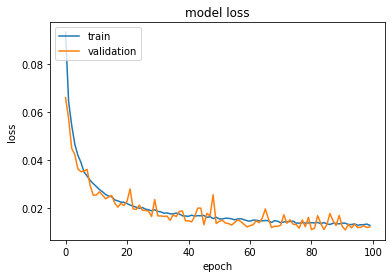

96-conv2d-patch_3-base_1-layer_4-label_FWFsynthetic
(84, 84, 96)
Model: "functional_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_96 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_95 (Dropout)         (None, 82, 82, 150)       0         
_____________________________________________________

In [103]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_142 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_143 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_144 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_145 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_96 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_146 (Conv3D)          (None, 1, 1, 1, 1)  

2022-04-09 20:58:50.511003: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:58:50.511170: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:58:51.285812: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:58:51.309129: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:58:51.309404: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:58:51.314491: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_58_51
2022-04-09 20:58:51.315032: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_58_51/vw.trace.json.gz
2022-04-09 20:58:51.315127: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:58:51.316206: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

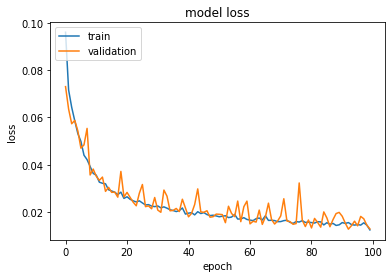

96-conv3d-patch_3-base_1-layer_4-label_FWFsynthetic
(84, 84, 50)
Model: "functional_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_147 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_148 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_149 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_150 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_97 (Dropout)         (None, 82, 82, 48, 150)   0         
_____________________________________________________

In [104]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.935459088052448
3
conv2d
96input size the ssim score for fwf is: 0.9318751330990247
3
conv3d
96input size the ssim score for fwf is: 0.9367675679932386


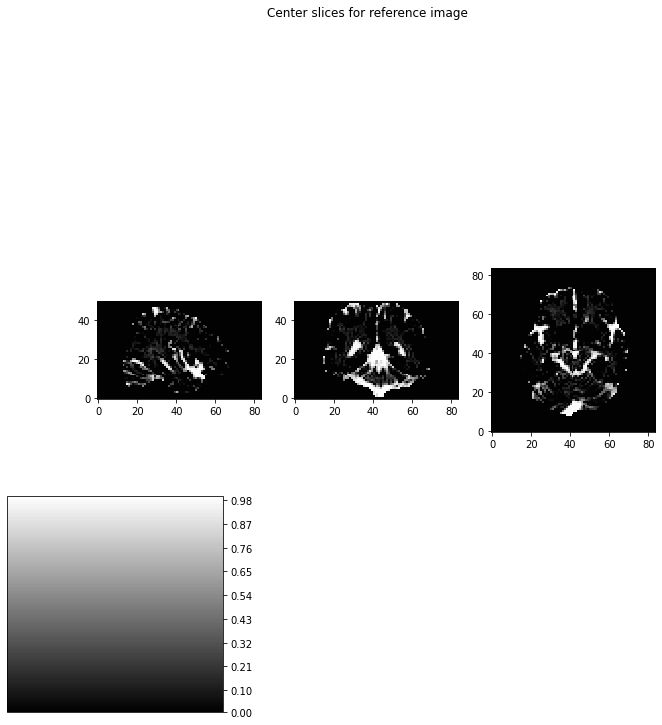

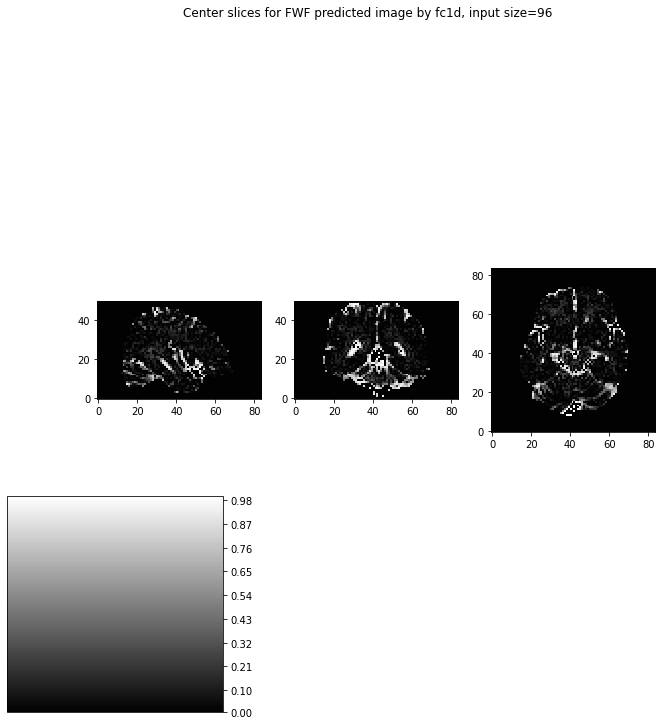

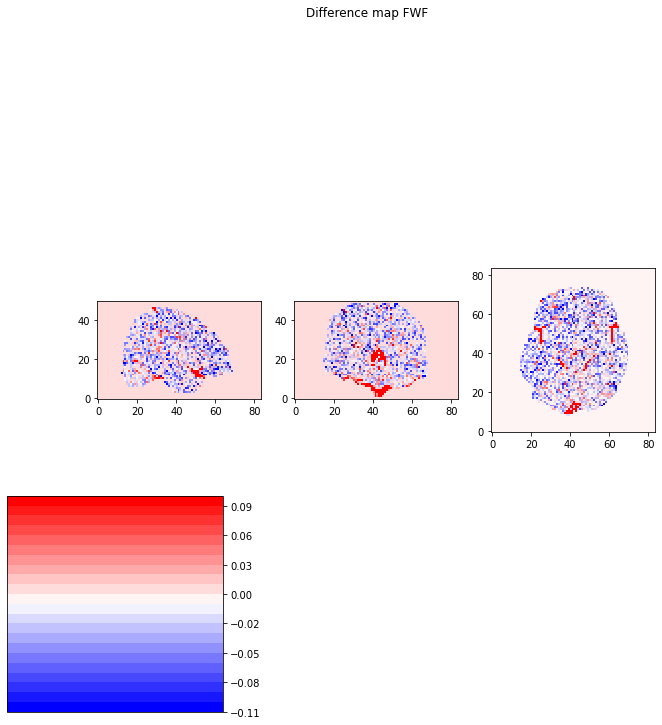

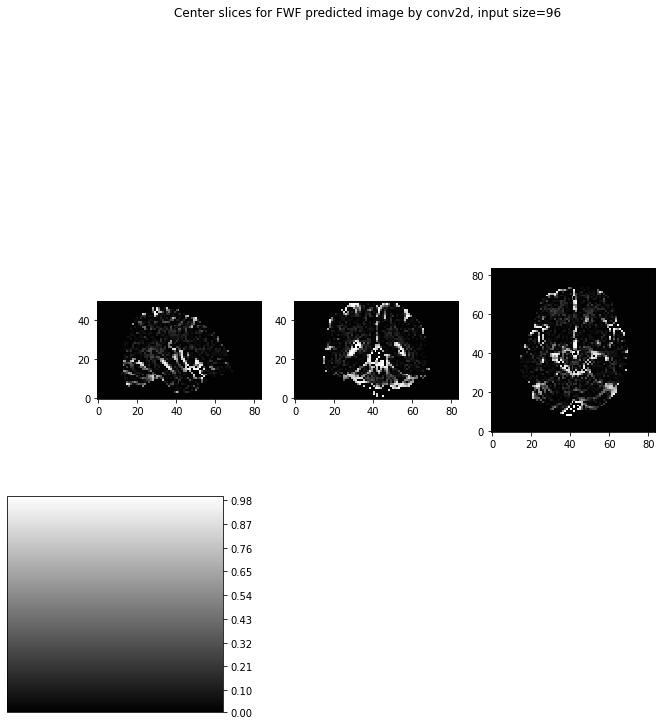

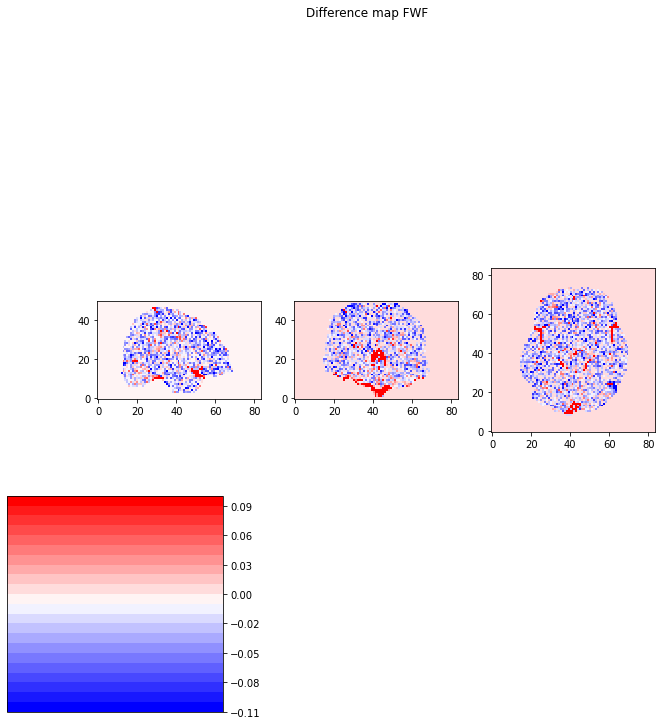

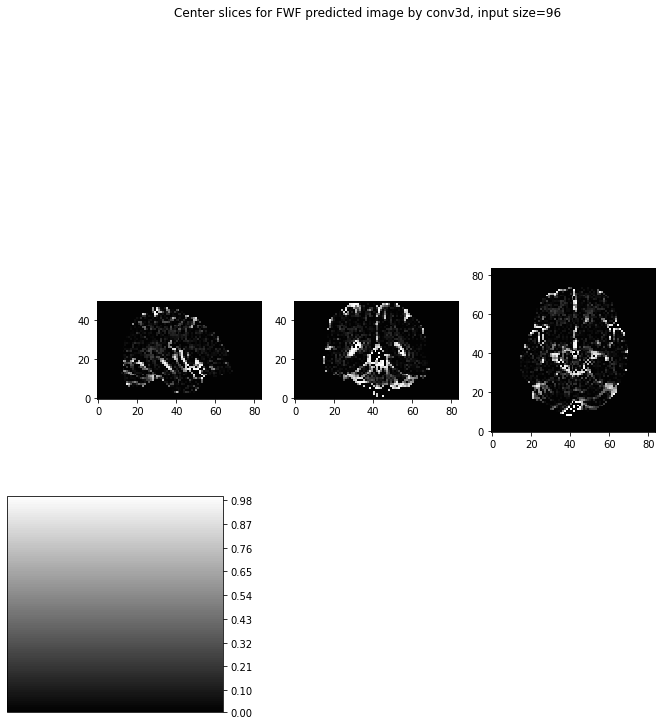

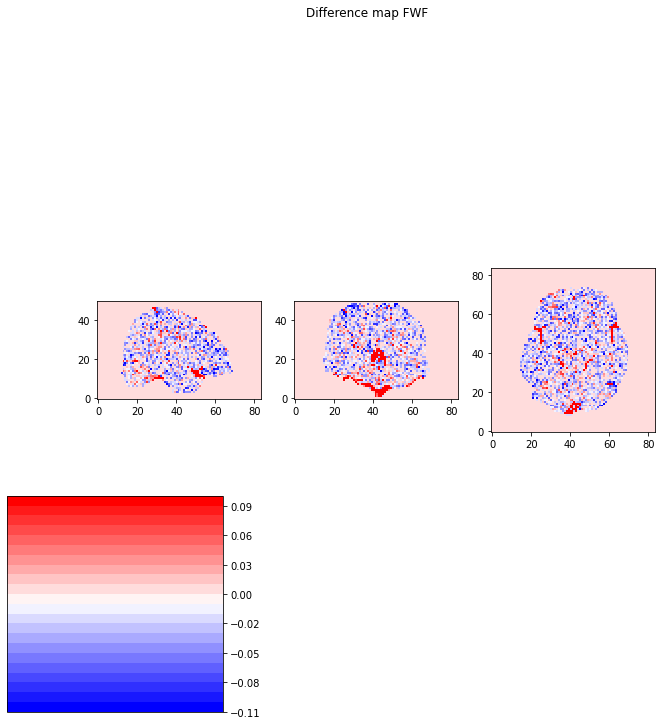

In [105]:
# load the reference img and pred img
visualise0(s02_FWF_img_data)
visualise3(s02_FWF_img_data, 96, 's02_still', 'fc1d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv2d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv3d',layer, s02_FWF_affine)

<strong>5 layer</strong>

In [106]:
layer = 5

ANN

96
Model: "functional_289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_104 (Dense)            (None, 150)               14550     
_________________________________________________________________
dense_105 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_106 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_107 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_108 (Dense)            (None, 150)               22650     
_________________________________________________________________
dropout_96 (Dropout)         (None, 150)         

2022-04-08 04:01:42.502355: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 04:01:42.502452: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 04:01:42.941238: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 04:01:42.964312: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 04:01:42.964608: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 04:01:42.965927: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_04_01_42
2022-04-08 04:01:42.966518: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_04_01_42/vw.trace.json.gz
2022-04-08 04:01:42.966608: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 04:01:42.967651: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

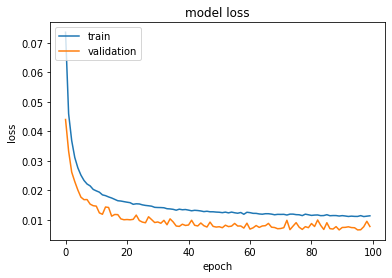

96-fc1d-patch_1-base_1-layer_5-label_FWFsynthetic
(84, 50, 96)
Model: "functional_293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_109 (Dense)            (None, 150)               14550     
_________________________________________________________________
dense_110 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_111 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_112 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_113 (Dense)            (None, 150)               22650     
_______________________________________________________

In [106]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_98 (Dropout)         (None, 1, 1, 150)   

2022-04-09 21:02:37.650242: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:02:37.650337: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 21:02:38.298754: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:02:38.323981: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 21:02:38.324295: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 21:02:38.325698: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_21_02_38
2022-04-09 21:02:38.326260: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_21_02_38/vw.trace.json.gz
2022-04-09 21:02:38.326338: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 21:02:38.327357: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

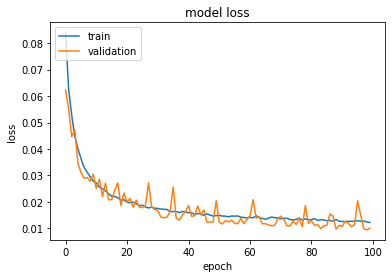

96-conv2d-patch_3-base_1-layer_5-label_FWFsynthetic
(84, 84, 96)
Model: "functional_297"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_100 (InputLayer)       [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 82, 82, 150)       22650     
_____________________________________________________

In [107]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_152 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_153 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_154 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_155 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_156 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_100 (Dropout)        (None, 1, 1, 1, 150)

2022-04-09 21:04:30.630603: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:04:30.630735: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 21:04:31.389719: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:04:31.415251: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 21:04:31.415561: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 21:04:31.417056: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_21_04_31
2022-04-09 21:04:31.417633: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_21_04_31/vw.trace.json.gz
2022-04-09 21:04:31.417715: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 21:04:31.418774: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

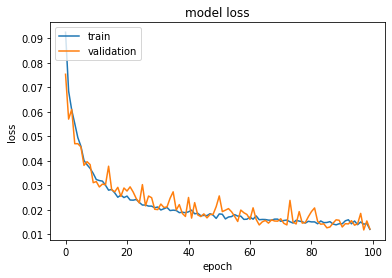

96-conv3d-patch_3-base_1-layer_5-label_FWFsynthetic
(84, 84, 50)
Model: "functional_303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_158 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_159 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_160 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_161 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_162 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [108]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9384169310481771
3
conv2d
96input size the ssim score for fwf is: 0.9338228514090023
3
conv3d
96input size the ssim score for fwf is: 0.9361616823687142


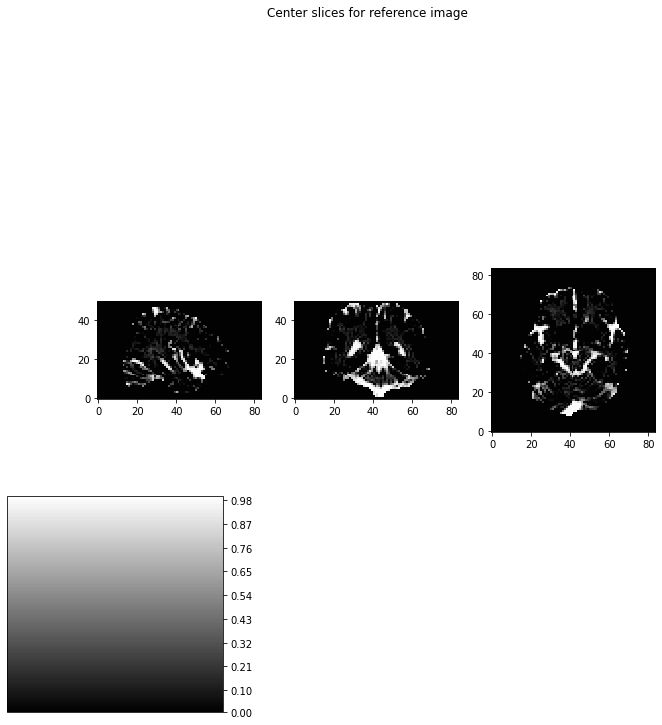

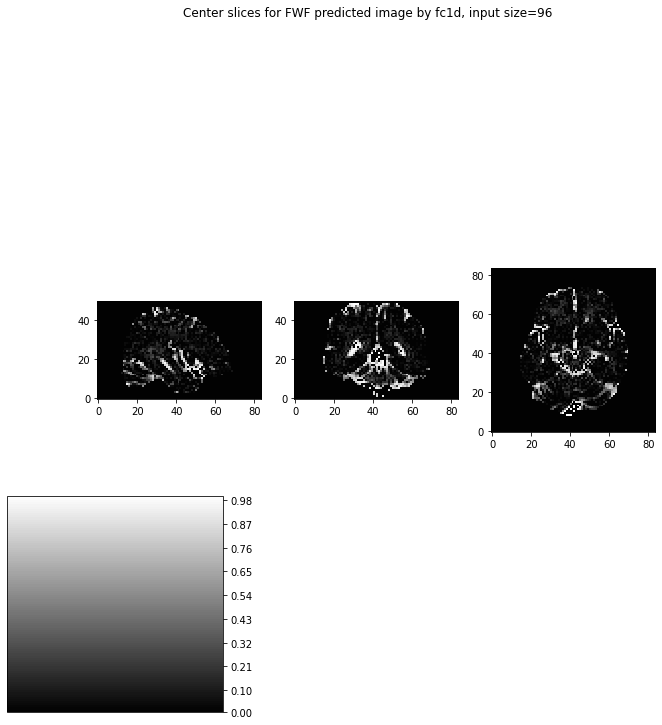

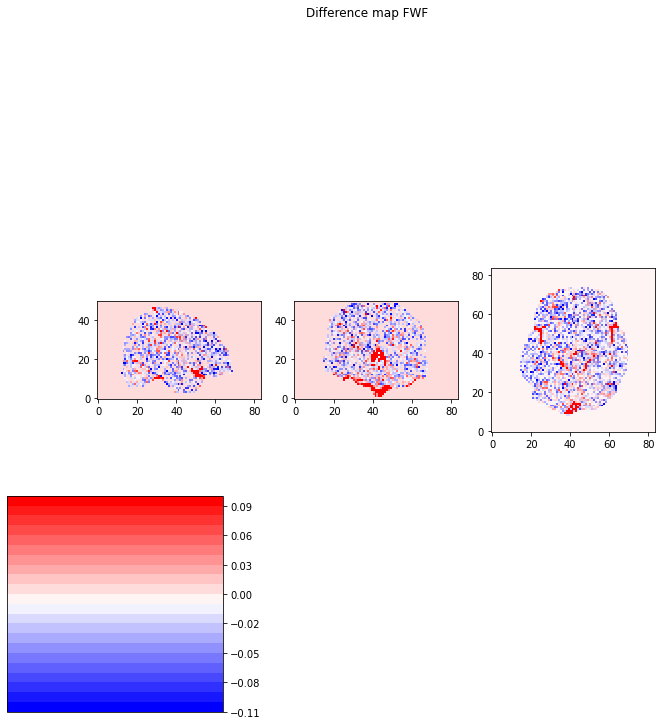

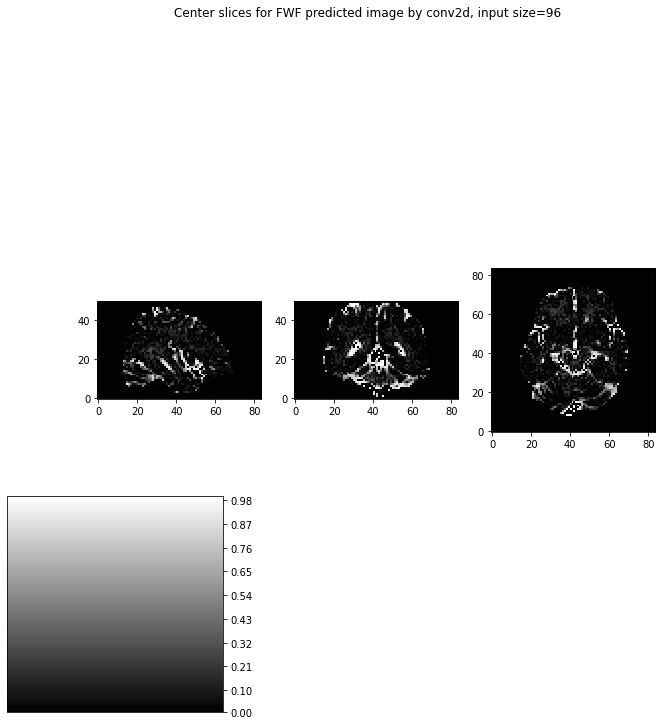

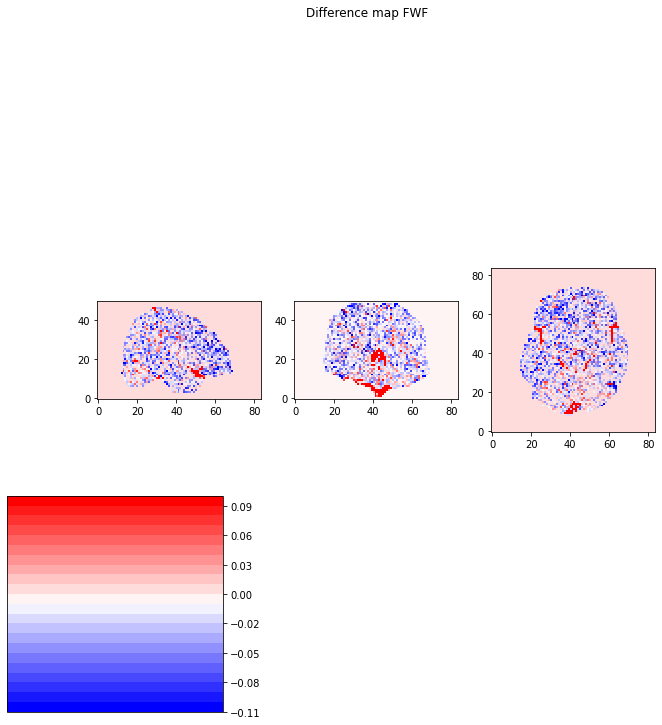

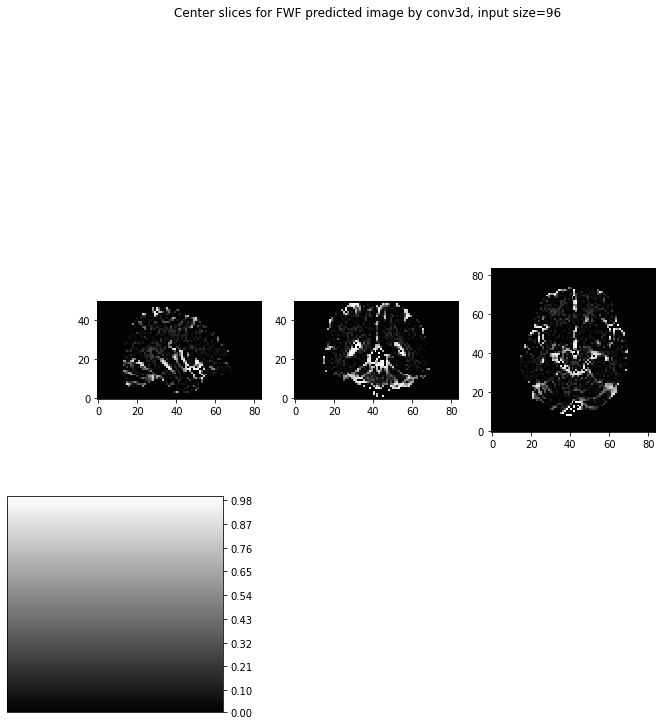

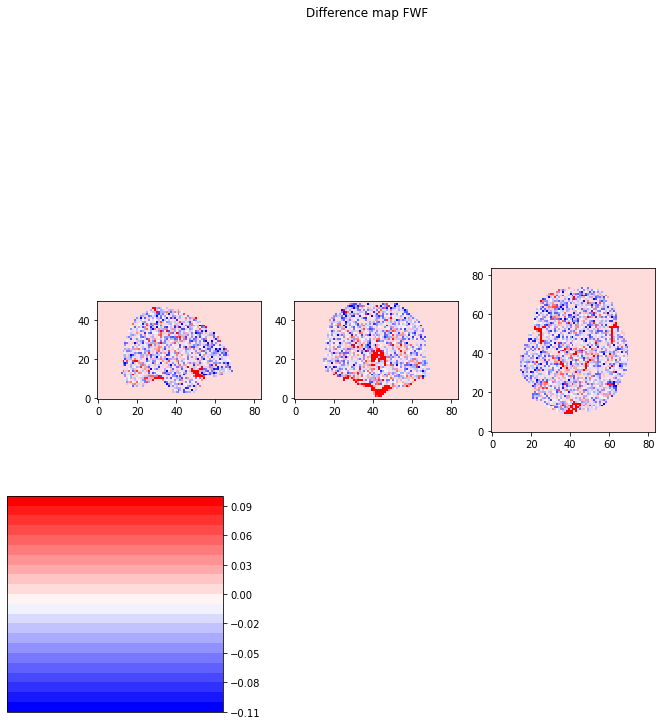

In [109]:
# load the reference img and pred img
visualise0(s02_FWF_img_data)
visualise3(s02_FWF_img_data, 96, 's02_still', 'fc1d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv2d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv3d',layer, s02_FWF_affine)

<strong>6 layer</strong>

In [110]:
layer = 6

ANN

96
Model: "functional_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_60 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_61 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_62 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_63 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_64 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_65 (Dense)             (None, 150)         

2022-04-09 20:29:44.937567: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:29:44.937658: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 20:29:45.320569: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 20:29:45.346951: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 20:29:45.347240: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 20:29:45.348614: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_20_29_45
2022-04-09 20:29:45.349186: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_20_29_45/vw.trace.json.gz
2022-04-09 20:29:45.349283: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 20:29:45.350395: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

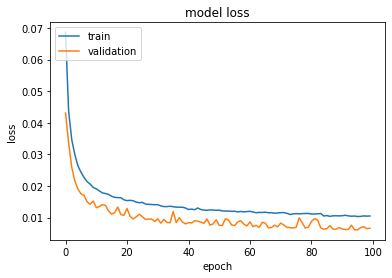

96-fc1d-patch_1-base_1-layer_6-label_FWFsynthetic
(84, 50, 96)
Model: "functional_213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_66 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_67 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_68 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_69 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_70 (Dense)             (None, 150)               22650     
_______________________________________________________

In [80]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_105 (InputLayer)       [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 1, 1, 150)   

2022-04-09 21:10:27.195467: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:10:27.195565: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 21:10:27.795066: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:10:27.819733: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 21:10:27.820042: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 21:10:27.821403: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_21_10_27
2022-04-09 21:10:27.821986: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_21_10_27/vw.trace.json.gz
2022-04-09 21:10:27.822063: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 21:10:27.823095: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

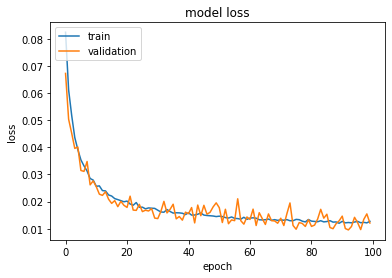

96-conv2d-patch_3-base_1-layer_6-label_FWFsynthetic
(84, 84, 96)
Model: "functional_315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_106 (InputLayer)       [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 82, 82, 150)       22650     
_____________________________________________________

In [112]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_317"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_164 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_165 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_166 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_167 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_168 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_169 (Conv3D)          (None, 1, 1, 1, 150)

2022-04-09 21:12:44.894195: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:12:44.894294: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 21:12:45.699790: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 21:12:45.725622: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 21:12:45.725953: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 21:12:45.731165: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_21_12_45
2022-04-09 21:12:45.731764: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_21_12_45/vw.trace.json.gz
2022-04-09 21:12:45.731854: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 21:12:45.732949: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

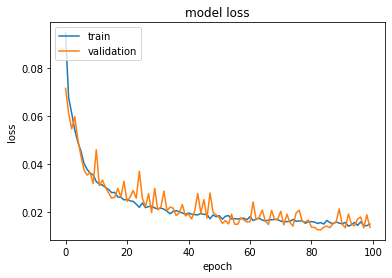

96-conv3d-patch_3-base_1-layer_6-label_FWFsynthetic
(84, 84, 50)
Model: "functional_321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_171 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_172 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_173 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_174 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_175 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [113]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9343045662820215
3
conv2d
96input size the ssim score for fwf is: 0.9295767858725111
3
conv3d
96input size the ssim score for fwf is: 0.9335536610051082


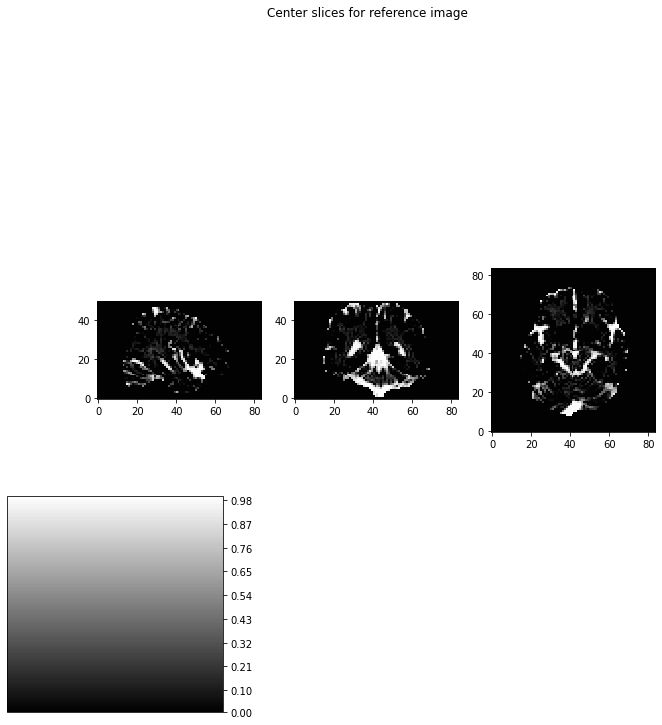

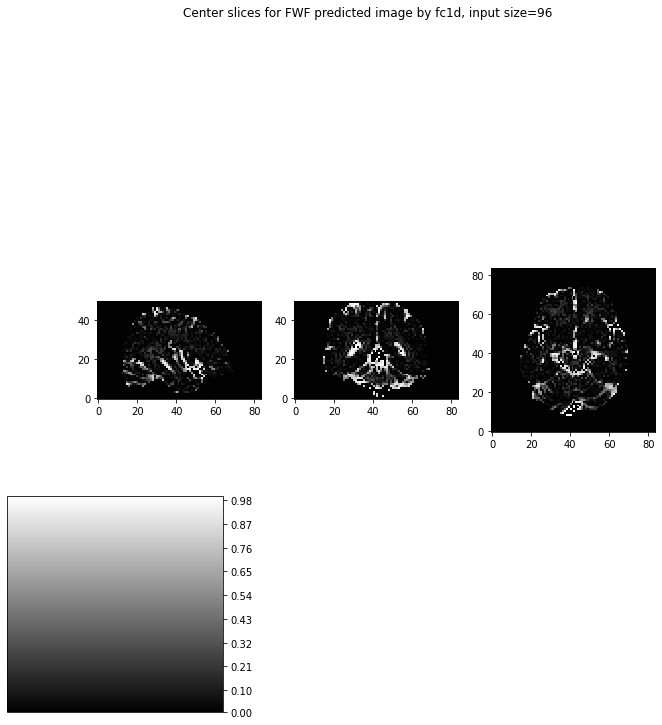

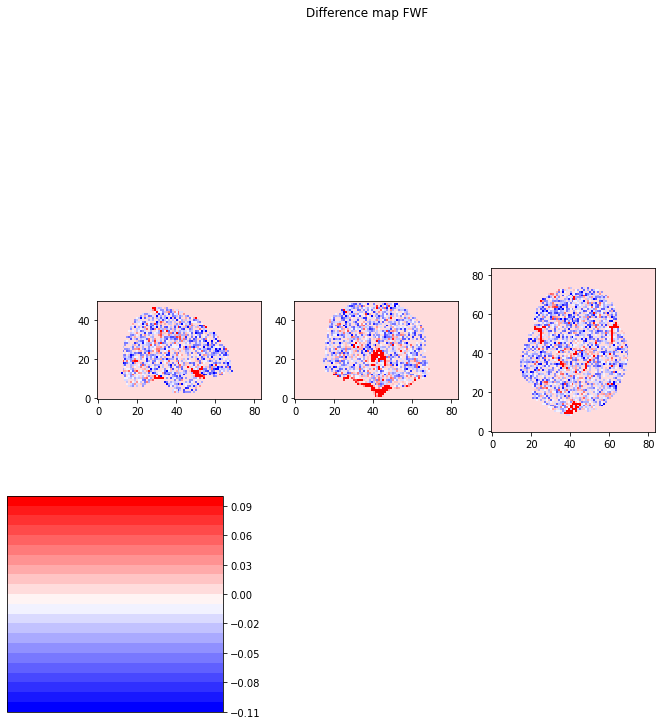

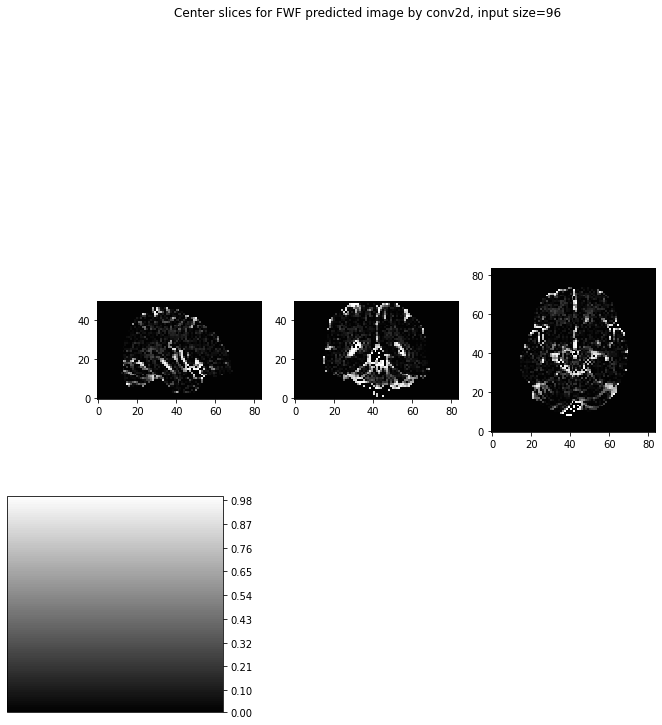

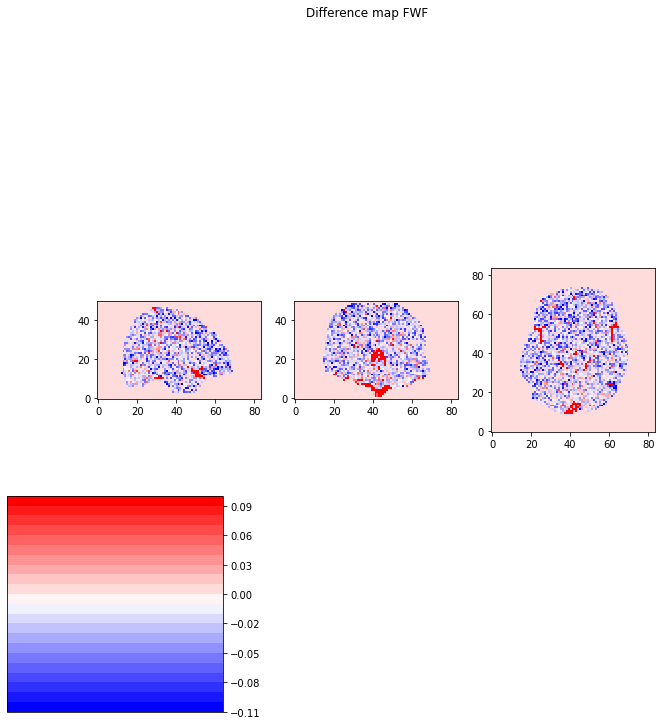

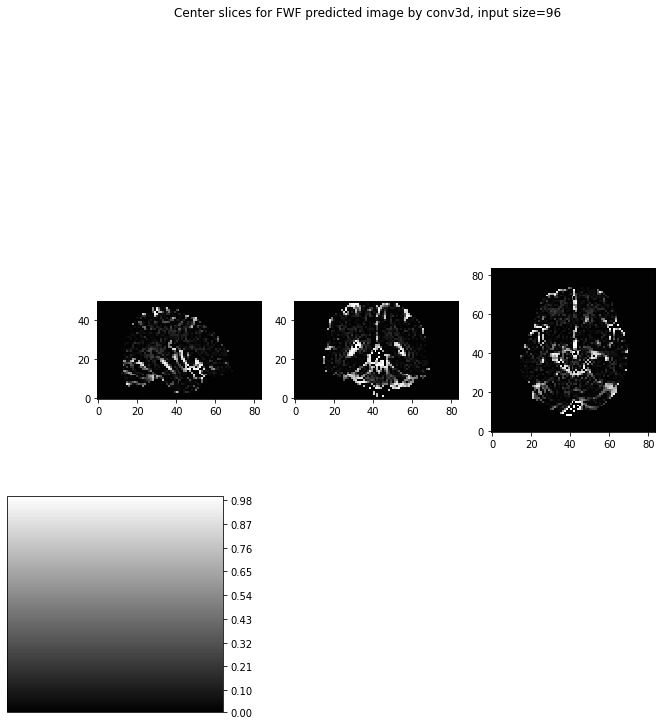

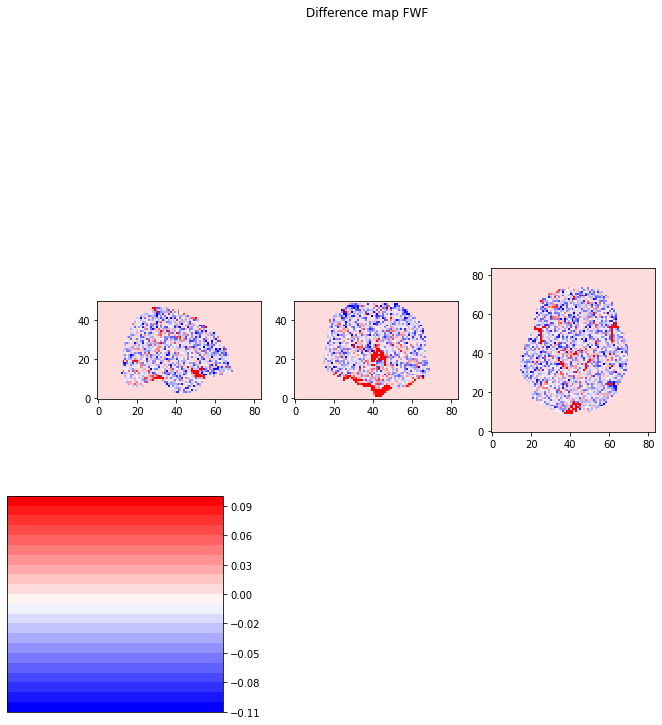

In [114]:
# load the reference img and pred img
visualise0(s02_FWF_img_data)
visualise3(s02_FWF_img_data, 96, 's02_still', 'fc1d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv2d',layer, s02_FWF_affine)
visualise3(s02_FWF_img_data, 96, 's02_still', 'conv3d',layer, s02_FWF_affine)

___

<h4>Test the performace of each network to generate each parameter with varied number of DWI as input size</h4>

Each network (ANN, 2D CNN and 3D CNN) should be implemented with 4 hidden layers. The choice is suggested from the obtained results from the previous experiment

<h4>Training</h4><br/>
ANN

In [115]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model fc1d --layer 4 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [116]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         print(i)
#         test_cmd = "--test_subjects s02_still --model fc1d --layer 4 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args) 

In [117]:
# # plot each derived image
# # specify the parameters
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# ref_img = [s02_NDI_img, s02_ODI_img, s02_FWF_img] # this is the ref img data list
# ref_img_data = [s02_NDI_img_data, s02_ODI_img_data, s02_FWF_img_data] # this is the ref img data list
# # iterate, so plot each param in order
# for i in range (len(params)):
#     # plot the reference img first
#     ref_slice_0 = ref_img_data[i][26, :, :]
#     ref_slice_1 = ref_img_data[i][:, 30, :]
#     ref_slice_2 = ref_img_data[i][:, :, 16]
#     show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
#     plt.suptitle("Center slices for s02_still_" + params[i] + " reference image")
    
#     affine = ref_img[i].affine
    
#     for j in np.arange(start=6, stop=97, step=10):
#         # plot the predicted imgs for different input size
#         pred_path = '../Net/nii/s02_still-' + str(j)+'-fc1d-patch_1-base_1-layer_4-label_'+params[i]+'.nii'
#         # load the img
#         pred_img = nib.load(pred_path)
#         # fetch the data
#         pred_data = pred_img.get_fdata()

#         # plot the pred img
#         pred0 = pred_data[26, :, :]
#         pred1 = pred_data[:, 30, :]
#         pred2 = pred_data[:, :, 16]
#         show_slices([pred0, pred1, pred2])
#         plt.suptitle("Center slices for s02_still_" + params[i] + " predicted image by ANN, input size="+str(j))

#         # plot the difference img
#         diff0 = ref_slice_0 - pred0
#         diff1 = ref_slice_1 - pred1
#         diff2 = ref_slice_2 - pred2
#         show_slices([diff0, diff1, diff2], grayscale=False)
#         plt.suptitle('Difference map')

#         diff_img_np = ref_img_data[i] - pred_data
#         diff_img = nib.Nifti1Image(diff_img_np, affine)
#         nib.save(diff_img, '../Net/nii/s02_still-' + str(j)+'-fc1d-patch_1-base_1-layer_4-label_'+params[i]+'_difference.nii')   

5 Layer


In [118]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [119]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         print(i)
#         test_cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args) 

2D CNN<br/>
repeat exactly the same process as above, but change the network to 2D CNN

In [120]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model conv2d --layer 4 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [121]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s02_still --model conv2d --layer 4 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)

In [122]:
# # plot each derived image
# # specify the parameters
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# ref_img = [s02_NDI_img, s02_ODI_img, s02_FWF_img] # this is the ref img data list
# ref_img_data = [s02_NDI_img_data, s02_ODI_img_data, s02_FWF_img_data] # this is the ref img data list
# # iterate, so plot each param in order
# for i in range (len(params)):
#     # plot the reference img first
#     ref_slice_0 = ref_img_data[i][26, :, :]
#     ref_slice_1 = ref_img_data[i][:, 30, :]
#     ref_slice_2 = ref_img_data[i][:, :, 16]
#     show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
#     plt.suptitle("Center slices for s02_still_" + params[i] + " reference image")
    
#     affine = ref_img[i].affine
    
#     for j in np.arange(start=6, stop=97, step=10):
#         # plot the predicted imgs for different input size
#         pred_path = '../Net/nii/s02_still-' + str(j)+'-conv2d-patch_3-base_1-layer_4-label_'+params[i]+'.nii'
#         # load the img
#         pred_img = nib.load(pred_path)
#         # fetch the data
#         pred_data = pred_img.get_fdata()

#         # plot the pred img
#         pred0 = pred_data[26, :, :]
#         pred1 = pred_data[:, 30, :]
#         pred2 = pred_data[:, :, 16]
#         show_slices([pred0, pred1, pred2])
#         plt.suptitle("Center slices for s02_still_" + params[i] + " predicted image by 2D CNN, input size="+str(j))

#         # plot the difference img
#         diff0 = ref_slice_0 - pred0
#         diff1 = ref_slice_1 - pred1
#         diff2 = ref_slice_2 - pred2
#         show_slices([diff0, diff1, diff2], grayscale=False)
#         plt.suptitle('Difference map')

#         diff_img_np = ref_img_data[i] - pred_data
#         diff_img = nib.Nifti1Image(diff_img_np, affine)
#         nib.save(diff_img, '../Net/nii/s02_still-' + str(j)+'-conv2d-patch_3-base_1-layer_4-label_'+params[i]+'_difference.nii')   

5 Layer

In [123]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [124]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)

3D CNN<br/>
repeat the same process as above

In [125]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model conv3d --layer 4 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [126]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s02_still --model conv3d --layer 4 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)

In [127]:
# # plot each derived image
# # specify the parameters
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# ref_img = [s02_NDI_img, s02_ODI_img, s02_FWF_img] # this is the ref img data list
# ref_img_data = [s02_NDI_img_data, s02_ODI_img_data, s02_FWF_img_data] # this is the ref img data list
# # iterate, so plot each param in order
# for i in range (len(params)):
#     # plot the reference img first
#     ref_slice_0 = ref_img_data[i][26, :, :]
#     ref_slice_1 = ref_img_data[i][:, 30, :]
#     ref_slice_2 = ref_img_data[i][:, :, 16]
#     show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
#     plt.suptitle("Center slices for s02_still_" + params[i] + " reference image")
    
#     affine = ref_img[i].affine
    
#     for j in np.arange(start=6, stop=97, step=10):
#         # plot the predicted imgs for different input size
#         pred_path = '../Net/nii/s02_still-' + str(j)+'-conv3d-patch_3-base_1-layer_4-label_'+params[i]+'.nii'
#         # load the img
#         pred_img = nib.load(pred_path)
#         # fetch the data
#         pred_data = pred_img.get_fdata()

#         # plot the pred img
#         pred0 = pred_data[26, :, :]
#         pred1 = pred_data[:, 30, :]
#         pred2 = pred_data[:, :, 16]
#         show_slices([pred0, pred1, pred2])
#         plt.suptitle("Center slices for s02_still_" + params[i] + " predicted image by 3D CNN, input size="+str(j))

#         # plot the difference img
#         diff0 = ref_slice_0 - pred0
#         diff1 = ref_slice_1 - pred1
#         diff2 = ref_slice_2 - pred2
#         show_slices([diff0, diff1, diff2], grayscale=False)
#         plt.suptitle('Difference map')

#         diff_img_np = ref_img_data[i] - pred_data
#         diff_img = nib.Nifti1Image(diff_img_np, affine)
#         nib.save(diff_img, '../Net/nii/s02_still-' + str(j)+'-conv3d-patch_1-base_1-layer_4-label_'+params[i]+'_difference.nii')   

5 Layer

In [128]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [129]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)
